In [3]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
from collections import defaultdict
from numpy import hamming
import os
import pickle
from sklearn.utils.class_weight import compute_class_weight

In [4]:
PATH = '../WESAD/'
SUBJECTS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17']
CHEST_SIGNALS = ['ECG', 'EMG', 'EDA', 'Resp', 'Temp', 'ACC']
CHEST_SAMPLING_RATE = 700

In [5]:
def read_subject_data(subject) :
    path = PATH + 'S' + subject + '/S' + subject + '.pkl'
    subject = pd.read_pickle(path)
    
    return subject

In [6]:
def visualize_raw(signal, duration, sampling_rate, title) :
    n = duration * sampling_rate
    l = len(signal)
    
    s = random.randint(0, l - n)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = np.arange(n)
    df['y'] = signal[s:s+n]
    
    plt.figure(figsize=(20, 5))
    sns.scatterplot(x = 'x', y = 'y', data = df, s = 3).set(title=title)

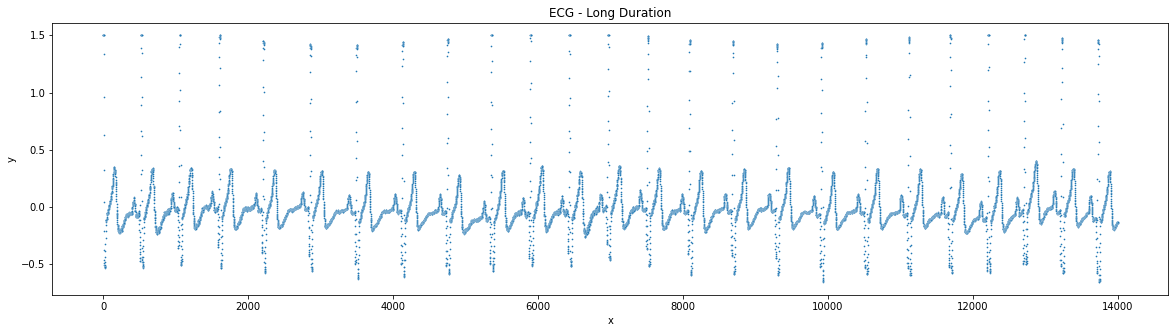

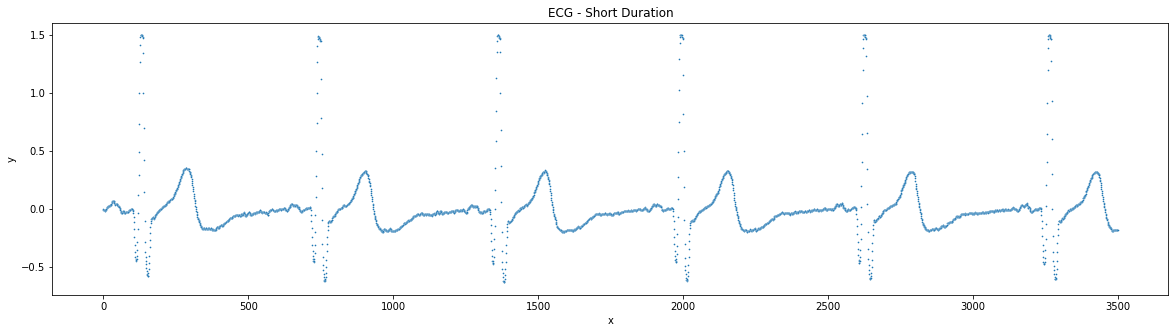

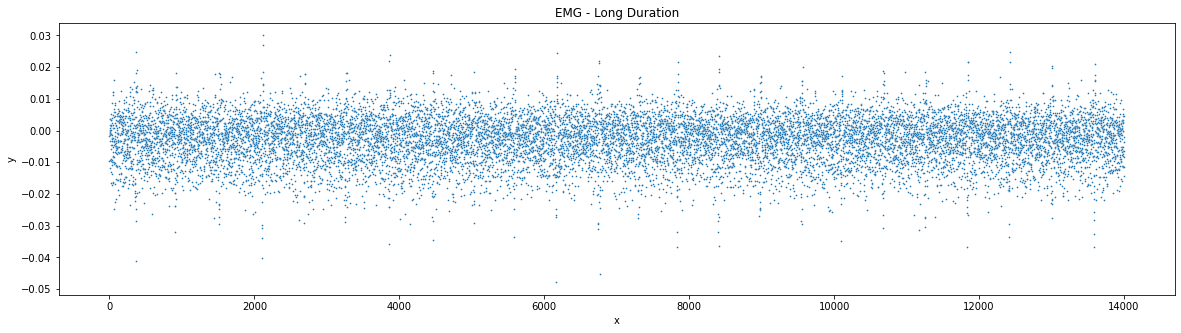

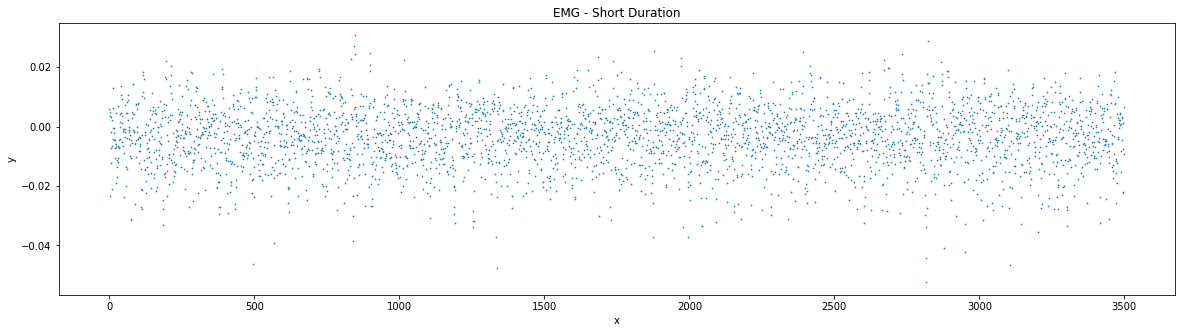

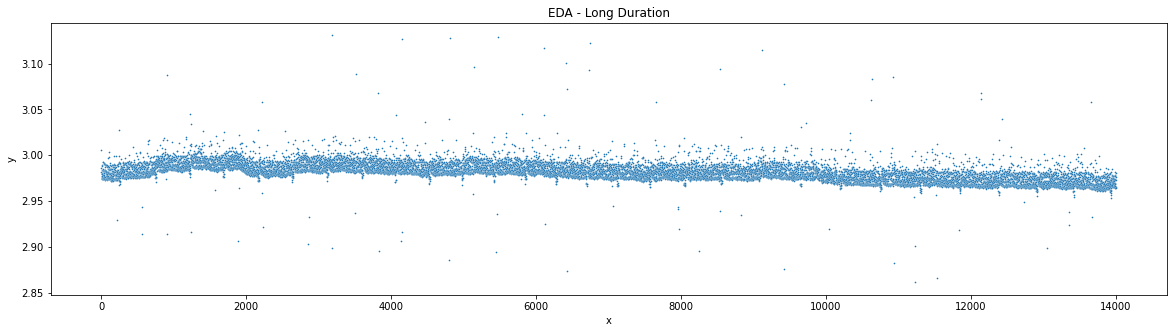

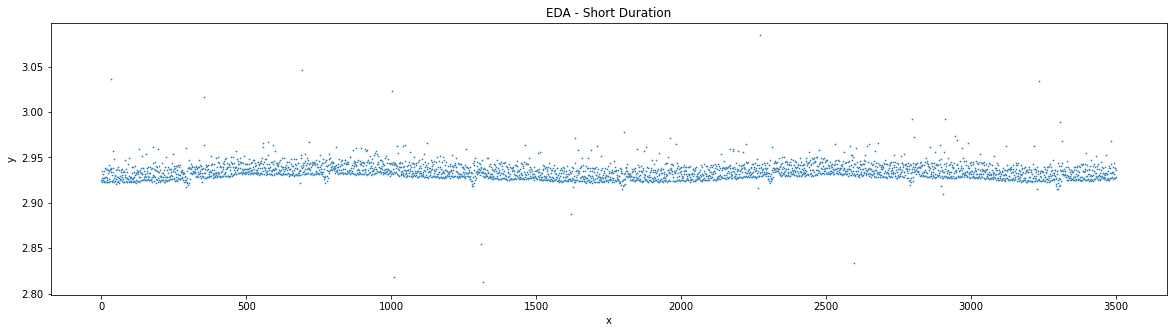

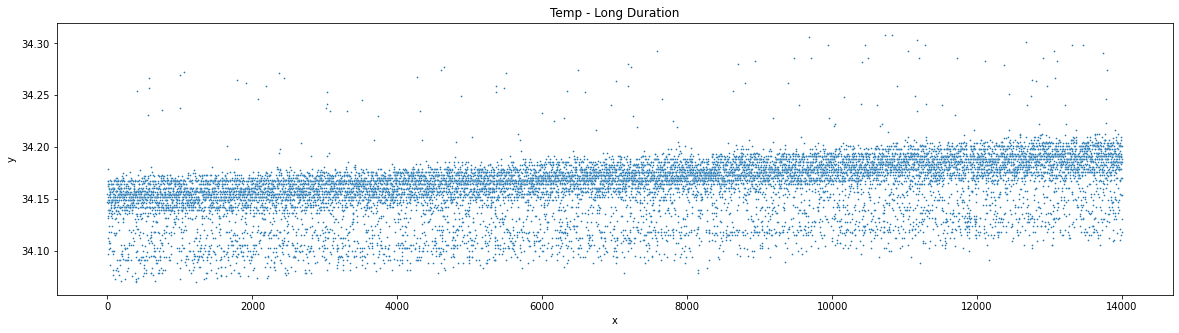

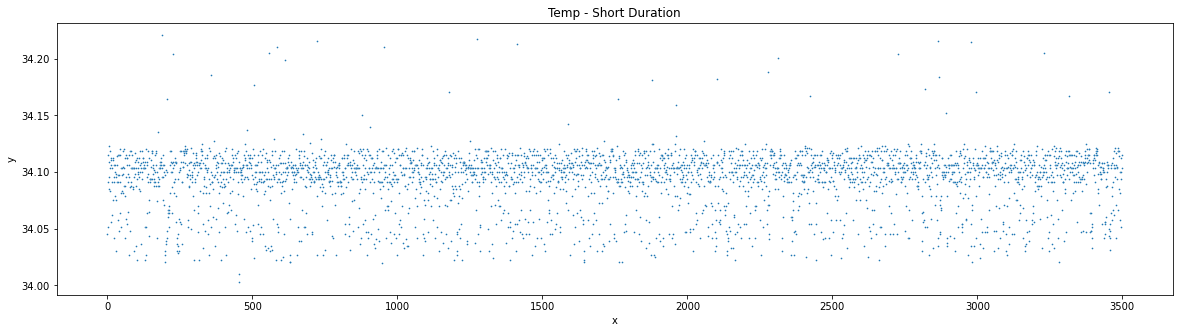

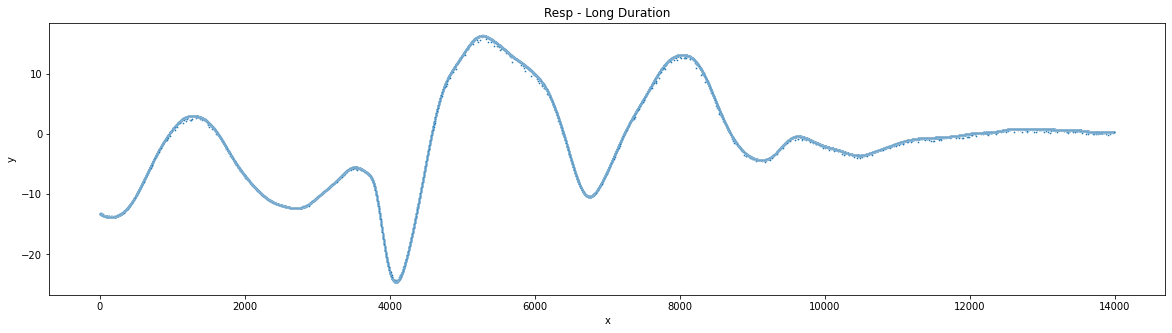

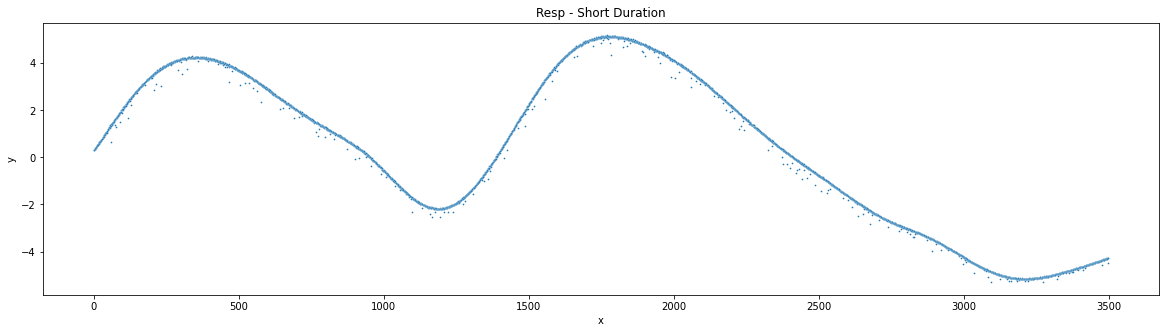

In [7]:
# Visualize the different chest signals for a random subject

SAMPLING_RATE = 700
LONG_DURATION = 20
SHORT_DURATION = 5

subject = random.choice(SUBJECTS)
subject_data = read_subject_data(subject)

chest_signals = subject_data['signal']['chest']

for signal_type in chest_signals :
    if signal_type == 'ACC' :
        continue
    
    signal = chest_signals[signal_type]
    visualize_raw(signal, LONG_DURATION, SAMPLING_RATE, signal_type + ' - Long Duration')
    visualize_raw(signal, SHORT_DURATION, SAMPLING_RATE, signal_type + ' - Short Duration')

In [8]:
# Get additional notes for the Subjects

for subject in SUBJECTS :
    with open(PATH + 'S' + subject + '/S' + subject + '_readme.txt', 'r') as file :
        print(subject, file.readlines()[16])

2 The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.

3 During the baseline condition, the subject was sitting in a sunny workplace.

4 -

5 Subject might have fallen asleep during the first meditation.

6 Subject claimed that he had a stressfull week and hence the study was rather relaxing for him.

7 -

8 Subject had already a rather stressful day, prior to the study.

9 -

10 -

11 -

13 -

14 -

15 Subject didn't really believe the cover story of the stress condition (TSST).

16 Subject felt rather cold in the room where the stress condition was carried out.

17 The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.



In [9]:
# https://imotions.com/blog/eda/
# https://www.scitepress.org/Papers/2021/102446/102446.pdf
# https://sci-hub.ee/10.1016/j.cmpb.2020.105482
WINDOW_LEN = 20
OVERLAP = 0.75
NUM_FEATURES = 10
EPOCH = 2048
BATCH_SIZE=48

In [10]:
# Identify the continuous intervals for each label
def find_intervals(labels) :
    intervals = []

    l = len(labels)
    i = 0
    label = labels[0]

    for j in range(l):
        if label != labels[j]:
            intervals.append({
                'label' : label, 
                'beg' : i,
                'end' : j
                })
            i = j
            label = labels[j]

    intervals.append({
        'label' : label, 
        'beg' : i,
        'end' : l
    })

    return intervals    

In [11]:
def extract_fft_features(signal, num_features) :
    window = hamming(len(signal))
    signal *= window
    coeffs = fft.fft(signal)
    l = len(coeffs)
    freqs = fft.fftfreq(l)
    
    # Discard the negative elems
    l //= 2
    amps = np.abs(coeffs[0:l])
    freqs = np.abs(freqs[0:l])
    
    # Sort descending w.r.t amp   
    p = amps.argsort()[::-1]
    freqs = freqs[p]
    amps = amps[p]
    
    features = [[amps[i], freqs[i]] for i in range(num_features)]   
    return np.array(features)

In [12]:
def normalize_fft_features(train_features, test_features) :
    feature_mean = np.mean(train_features, axis=0)
    print(np.shape(feature_mean))
    feature_std = np.std(train_features, axis=0)
    train_features -= feature_mean
    test_features -= feature_mean
    train_features = np.divide(train_features, feature_std, out=np.zeros_like(train_features), where=feature_std!=0)
    test_features = np.divide(test_features, feature_std, out=np.zeros_like(test_features), where=feature_std!=0)
    
    return train_features, test_features

In [13]:
TRANSIENT = 0
BASELINE = 1
STRESS = 2
AMUSEMENT = 3
MEDITATION = 4
IGNORE = 5

def extract_signal_features(signal, intervals, sampling_rate, window_len = WINDOW_LEN, overlap = OVERLAP, num_features = NUM_FEATURES) :
    segment_size = sampling_rate * window_len
    signal_features = {
        BASELINE : [],
        STRESS : [],
        AMUSEMENT : [],
        MEDITATION : []
    }
    
    baseline_av = 0
    
    for interval in intervals :
        label = interval['label']
        beg = interval['beg']
        end = interval['end']
        
        signal_of_interest = signal[beg:end]  
        
        if label >= IGNORE or label == TRANSIENT:
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
            continue      
            
        if label == BASELINE :
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
        
        signal_of_interest -= baseline_av
        
        l = end - beg        
        while l >= segment_size:
            segment = signal_of_interest[int(l - segment_size) : l]
            l -= int((1 - overlap) * segment_size)
            
            segment_features = extract_fft_features(segment, num_features)            
            signal_features[label].append(segment_features)
        
    return signal_features

In [14]:
# Get Joint test-train  Datasets combining all signals

def get_chest_signal_dataset(subjects, signal_types = CHEST_SIGNALS) :
    combined_subject_features = {}
    
    for subject in subjects :
        subject_data = read_subject_data(subject)
        intervals = find_intervals(subject_data['label'])
        
        subject_features = {
            BASELINE : [],
            STRESS : [],
            AMUSEMENT : [],
            MEDITATION : []
        }
        
        for signal_type in signal_types :
            if signal_type == 'ACC' :
                continue
                
            signal = np.array(subject_data['signal']['chest'][signal_type]).flatten()
            signal_features = extract_signal_features(signal, intervals, CHEST_SAMPLING_RATE)
            
            for label, features in signal_features.items() :
                subject_features[label].append(features)
                
        for label in subject_features :
            subject_features[label] = np.stack(subject_features[label], axis = -1)
            
        aggregate_subject_features = []
        aggregate_subject_labels = []
            
        for label, features in subject_features.items() :
            for feature in features :
                aggregate_subject_features.append(feature)
                aggregate_subject_labels.append(label)
                
        feature_mean = np.mean(aggregate_subject_features, axis=0)
        feature_std = np.std(aggregate_subject_features, axis=0)
        
        aggregate_subject_features = np.array(aggregate_subject_features) - feature_mean
        aggregate_subject_features = np.divide(aggregate_subject_features, feature_std, out=np.zeros_like(aggregate_subject_features), where=feature_std!=0)
                
        combined_subject_features[subject] = {
            'features' : aggregate_subject_features,
            'labels' : aggregate_subject_labels
        }

    return combined_subject_features

In [15]:
def generate_dataset(combined_subject_features, subjects) :
    features_dataset = []
    labels_dataset = []
    
    for subject in subjects :
        features_dataset += list(combined_subject_features[subject]['features'])
        labels_dataset += combined_subject_features[subject]['labels']
        
    return np.array(features_dataset), np.array(labels_dataset)

In [16]:
def encode_labels(labels) :
    encoder = {
        1 : [1, 0, 0, 0],
        2 : [0, 1, 0, 0],
        3 : [0, 0, 1, 0],
        4 : [0, 0, 0, 1]
    }
    
    return np.array([np.array(encoder[l]) for l in labels])

In [17]:
def get_confusion_matrix(model, test_features, test_labels) :
    predicted_labels = model.predict(test_features)

    confusion_matrix = np.zeros((4, 4))

    for test_label, predicted_label in zip(test_labels, predicted_labels) :
        i = np.argmax(test_label)
        j = np.argmax(predicted_label)

        confusion_matrix[i][j] += 1
        
    confusion_matrix /= np.sum(confusion_matrix, axis=1).reshape(4, 1)
    
    return confusion_matrix

In [18]:
def get_class_weights(train_labels) :
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights /= np.min(class_weights)
    return dict(enumerate(class_weights))

In [19]:
combined_subject_features = get_chest_signal_dataset(SUBJECTS)

In [20]:
init_weights = '../Models/init_weights.hdf5'
best_model = '../Models/best_model.hdf5'

In [21]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10, 2, 5)),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(1, 1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(3,1), activation='swish'),
    keras.layers.Conv2D(8, kernel_size=(1,2), activation='swish'),
    keras.layers.Conv2D(4, kernel_size=(2,1), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(units=12,  activation='swish'),
    keras.layers.Dense(units=4, activation='softmax')
])
model.save_weights(init_weights)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d (Depthwise  (None, 9, 2, 10)         30        
 Conv2D)                                                         
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 8, 2, 10)         30        
 seConv2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 8, 2, 6)           66        
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 6, 2, 6)          24        
 seConv2D)                                                       
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 4, 2, 6)          24        
 seConv2D)                                              

2021-11-10 15:56:48.598814: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [23]:
subject_conf_matrix = {}

for i in range(len(SUBJECTS)) :
    test_subject = SUBJECTS[i]
    train_subjects = SUBJECTS[:i] + SUBJECTS[i+1:]
    
    train_features, train_labels = generate_dataset(combined_subject_features, train_subjects)
    test_features, test_labels = generate_dataset(combined_subject_features, [test_subject])
    
    class_weights = get_class_weights(train_labels)
    
    train_labels = encode_labels(train_labels)
    test_labels = encode_labels(test_labels)
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=best_model,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=EPOCH//4,
        restore_best_weights=True,
        verbose=1
    )

    model.load_weights(init_weights)
    
    model.fit(
        train_features, train_labels, 
        epochs=EPOCH, batch_size = BATCH_SIZE, 
        verbose=1, shuffle=True, 
        class_weight=class_weights, 
        validation_data=(test_features,  test_labels),
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    
    model.load_weights(best_model)
    
    subject_conf_matrix[test_subject] = get_confusion_matrix(model, test_features, test_labels)  
    print('-------------', test_subject,'-------------')
    print('row - actual, col - predicted')
    print(subject_conf_matrix[test_subject])

    with open("../ExtraData/confusion_matrix.pkl", 'wb') as file :
        pickle.dump(subject_conf_matrix, file)

Epoch 1/2048
168/171 [============================>.] - ETA: 0s - loss: 1.8950 - accuracy: 0.4345
Epoch 00001: val_loss improved from inf to 0.96044, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 2s 4ms/step - loss: 1.8885 - accuracy: 0.4348 - val_loss: 0.9604 - val_accuracy: 0.4831
Epoch 2/2048
165/171 [===========================>..] - ETA: 0s - loss: 1.1887 - accuracy: 0.7341
Epoch 00002: val_loss improved from 0.96044 to 0.53872, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 1s 5ms/step - loss: 1.1797 - accuracy: 0.7362 - val_loss: 0.5387 - val_accuracy: 0.7308
Epoch 3/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.8756 - accuracy: 0.8153
Epoch 00003: val_loss did not improve from 0.53872
171/171 [==============================] - 1s 3ms/step - loss: 0.8680 - accuracy: 0.8163 - val_loss: 0.5546 - val_accuracy: 0.7558
Epoch 4/2048
165/171 [===========================>..] - ETA: 0s - loss

170/171 [============================>.] - ETA: 0s - loss: 0.3959 - accuracy: 0.9309
Epoch 00029: val_loss improved from 0.42782 to 0.39099, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 0s 3ms/step - loss: 0.3953 - accuracy: 0.9309 - val_loss: 0.3910 - val_accuracy: 0.8485
Epoch 30/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.4001 - accuracy: 0.9319
Epoch 00030: val_loss improved from 0.39099 to 0.39039, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 0s 3ms/step - loss: 0.3967 - accuracy: 0.9322 - val_loss: 0.3904 - val_accuracy: 0.8485
Epoch 31/2048
170/171 [============================>.] - ETA: 0s - loss: 0.3871 - accuracy: 0.9326
Epoch 00031: val_loss improved from 0.39039 to 0.34175, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 0s 3ms/step - loss: 0.3866 - accuracy: 0.9326 - val_loss: 0.3417 - val_accuracy: 0.8752
Epoch 32/2048
152/171 [=======

Epoch 57/2048
151/171 [=========================>....] - ETA: 0s - loss: 0.3063 - accuracy: 0.9480
Epoch 00057: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.3071 - accuracy: 0.9482 - val_loss: 0.3468 - val_accuracy: 0.8788
Epoch 58/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.3074 - accuracy: 0.9465
Epoch 00058: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.3057 - accuracy: 0.9467 - val_loss: 0.4163 - val_accuracy: 0.8663
Epoch 59/2048
152/171 [=========================>....] - ETA: 0s - loss: 0.3028 - accuracy: 0.9461
Epoch 00059: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.3034 - accuracy: 0.9451 - val_loss: 0.3657 - val_accuracy: 0.8788
Epoch 60/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.3082 - accuracy: 0.9464
Epoch 00060: val_loss did not improve from 0.19151
171/171

164/171 [===========================>..] - ETA: 0s - loss: 0.2765 - accuracy: 0.9494
Epoch 00086: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.2769 - accuracy: 0.9492 - val_loss: 0.5226 - val_accuracy: 0.8556
Epoch 87/2048
170/171 [============================>.] - ETA: 0s - loss: 0.2759 - accuracy: 0.9520
Epoch 00087: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.2753 - accuracy: 0.9521 - val_loss: 0.4678 - val_accuracy: 0.8627
Epoch 88/2048
167/171 [============================>.] - ETA: 0s - loss: 0.2837 - accuracy: 0.9480
Epoch 00088: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.2818 - accuracy: 0.9482 - val_loss: 0.5558 - val_accuracy: 0.8396
Epoch 89/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.2724 - accuracy: 0.9517
Epoch 00089: val_loss did not improve from 0.19151
171/171 [============

168/171 [============================>.] - ETA: 0s - loss: 0.2621 - accuracy: 0.9516
Epoch 00115: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.2601 - accuracy: 0.9520 - val_loss: 0.7405 - val_accuracy: 0.8235
Epoch 116/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.2576 - accuracy: 0.9515
Epoch 00116: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.2519 - accuracy: 0.9531 - val_loss: 0.8172 - val_accuracy: 0.8075
Epoch 117/2048
155/171 [==========================>...] - ETA: 0s - loss: 0.2537 - accuracy: 0.9519
Epoch 00117: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 2ms/step - loss: 0.2530 - accuracy: 0.9527 - val_loss: 0.7140 - val_accuracy: 0.8271
Epoch 118/2048
156/171 [==========================>...] - ETA: 0s - loss: 0.2485 - accuracy: 0.9553
Epoch 00118: val_loss did not improve from 0.19151
171/171 [=========

168/171 [============================>.] - ETA: 0s - loss: 0.2354 - accuracy: 0.9570
Epoch 00144: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.2351 - accuracy: 0.9571 - val_loss: 1.2164 - val_accuracy: 0.7629
Epoch 145/2048
151/171 [=========================>....] - ETA: 0s - loss: 0.2286 - accuracy: 0.9587
Epoch 00145: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.2327 - accuracy: 0.9578 - val_loss: 1.3663 - val_accuracy: 0.7344
Epoch 146/2048
159/171 [==========================>...] - ETA: 0s - loss: 0.2427 - accuracy: 0.9565
Epoch 00146: val_loss did not improve from 0.19151
171/171 [==============================] - 1s 3ms/step - loss: 0.2398 - accuracy: 0.9564 - val_loss: 0.8542 - val_accuracy: 0.8004
Epoch 147/2048
167/171 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.9572
Epoch 00147: val_loss did not improve from 0.19151
171/171 [=========

167/171 [============================>.] - ETA: 0s - loss: 0.2164 - accuracy: 0.9606
Epoch 00173: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.9608 - val_loss: 1.3733 - val_accuracy: 0.7576
Epoch 174/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.2115 - accuracy: 0.9607
Epoch 00174: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.2150 - accuracy: 0.9606 - val_loss: 1.3579 - val_accuracy: 0.7683
Epoch 175/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.2161 - accuracy: 0.9608
Epoch 00175: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.2163 - accuracy: 0.9606 - val_loss: 1.2722 - val_accuracy: 0.7701
Epoch 176/2048
160/171 [===========================>..] - ETA: 0s - loss: 0.2089 - accuracy: 0.9643
Epoch 00176: val_loss did not improve from 0.19151
171/171 [=========

168/171 [============================>.] - ETA: 0s - loss: 0.1849 - accuracy: 0.9664
Epoch 00202: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1841 - accuracy: 0.9666 - val_loss: 1.6437 - val_accuracy: 0.7094
Epoch 203/2048
166/171 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9646
Epoch 00203: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1861 - accuracy: 0.9641 - val_loss: 1.5151 - val_accuracy: 0.7380
Epoch 204/2048
166/171 [============================>.] - ETA: 0s - loss: 0.1870 - accuracy: 0.9640
Epoch 00204: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1866 - accuracy: 0.9643 - val_loss: 1.5018 - val_accuracy: 0.7326
Epoch 205/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.1847 - accuracy: 0.9661
Epoch 00205: val_loss did not improve from 0.19151
171/171 [=========

165/171 [===========================>..] - ETA: 0s - loss: 0.1511 - accuracy: 0.9701
Epoch 00231: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1548 - accuracy: 0.9696 - val_loss: 1.4614 - val_accuracy: 0.7237
Epoch 232/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.1525 - accuracy: 0.9674
Epoch 00232: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1491 - accuracy: 0.9691 - val_loss: 1.6793 - val_accuracy: 0.7237
Epoch 233/2048
170/171 [============================>.] - ETA: 0s - loss: 0.1518 - accuracy: 0.9706
Epoch 00233: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1519 - accuracy: 0.9705 - val_loss: 1.5977 - val_accuracy: 0.7130
Epoch 234/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.1561 - accuracy: 0.9685
Epoch 00234: val_loss did not improve from 0.19151
171/171 [=========

166/171 [============================>.] - ETA: 0s - loss: 0.1428 - accuracy: 0.9719
Epoch 00260: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1410 - accuracy: 0.9719 - val_loss: 1.7926 - val_accuracy: 0.7130
Epoch 261/2048
169/171 [============================>.] - ETA: 0s - loss: 0.1397 - accuracy: 0.9723
Epoch 00261: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1403 - accuracy: 0.9724 - val_loss: 2.0671 - val_accuracy: 0.7005
Epoch 262/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.1436 - accuracy: 0.9715
Epoch 00262: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1434 - accuracy: 0.9718 - val_loss: 2.0652 - val_accuracy: 0.7005
Epoch 263/2048
158/171 [==========================>...] - ETA: 0s - loss: 0.1478 - accuracy: 0.9710
Epoch 00263: val_loss did not improve from 0.19151
171/171 [=========

169/171 [============================>.] - ETA: 0s - loss: 0.1303 - accuracy: 0.9747
Epoch 00289: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1296 - accuracy: 0.9749 - val_loss: 1.9966 - val_accuracy: 0.7201
Epoch 290/2048
168/171 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9736
Epoch 00290: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1249 - accuracy: 0.9737 - val_loss: 1.9101 - val_accuracy: 0.7219
Epoch 291/2048
147/171 [========================>.....] - ETA: 0s - loss: 0.1214 - accuracy: 0.9769
Epoch 00291: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1254 - accuracy: 0.9760 - val_loss: 2.1336 - val_accuracy: 0.7184
Epoch 292/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.1310 - accuracy: 0.9733
Epoch 00292: val_loss did not improve from 0.19151
171/171 [=========

164/171 [===========================>..] - ETA: 0s - loss: 0.1195 - accuracy: 0.9745
Epoch 00318: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1222 - accuracy: 0.9736 - val_loss: 1.9380 - val_accuracy: 0.7237
Epoch 319/2048
166/171 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9750
Epoch 00319: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1190 - accuracy: 0.9752 - val_loss: 1.8995 - val_accuracy: 0.7130
Epoch 320/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.1184 - accuracy: 0.9756
Epoch 00320: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1165 - accuracy: 0.9762 - val_loss: 2.3028 - val_accuracy: 0.7041
Epoch 321/2048
158/171 [==========================>...] - ETA: 0s - loss: 0.1150 - accuracy: 0.9751
Epoch 00321: val_loss did not improve from 0.19151
171/171 [=========

170/171 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9779
Epoch 00347: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1075 - accuracy: 0.9779 - val_loss: 2.4126 - val_accuracy: 0.7166
Epoch 348/2048
168/171 [============================>.] - ETA: 0s - loss: 0.1133 - accuracy: 0.9773
Epoch 00348: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1128 - accuracy: 0.9773 - val_loss: 2.4196 - val_accuracy: 0.7023
Epoch 349/2048
152/171 [=========================>....] - ETA: 0s - loss: 0.1192 - accuracy: 0.9756
Epoch 00349: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1152 - accuracy: 0.9767 - val_loss: 2.4965 - val_accuracy: 0.7094
Epoch 350/2048
160/171 [===========================>..] - ETA: 0s - loss: 0.1022 - accuracy: 0.9781
Epoch 00350: val_loss did not improve from 0.19151
171/171 [=========

165/171 [===========================>..] - ETA: 0s - loss: 0.1012 - accuracy: 0.9788
Epoch 00376: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1031 - accuracy: 0.9787 - val_loss: 2.2201 - val_accuracy: 0.7041
Epoch 377/2048
170/171 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9792
Epoch 00377: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1066 - accuracy: 0.9791 - val_loss: 2.5161 - val_accuracy: 0.7166
Epoch 378/2048
167/171 [============================>.] - ETA: 0s - loss: 0.1023 - accuracy: 0.9783
Epoch 00378: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1027 - accuracy: 0.9781 - val_loss: 2.3313 - val_accuracy: 0.7077
Epoch 379/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.1070 - accuracy: 0.9779
Epoch 00379: val_loss did not improve from 0.19151
171/171 [=========

167/171 [============================>.] - ETA: 0s - loss: 0.0908 - accuracy: 0.9815
Epoch 00405: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0904 - accuracy: 0.9814 - val_loss: 2.4350 - val_accuracy: 0.7112
Epoch 406/2048
147/171 [========================>.....] - ETA: 0s - loss: 0.0945 - accuracy: 0.9819
Epoch 00406: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0968 - accuracy: 0.9809 - val_loss: 2.6865 - val_accuracy: 0.6970
Epoch 407/2048
171/171 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9801
Epoch 00407: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1049 - accuracy: 0.9801 - val_loss: 2.6714 - val_accuracy: 0.7005
Epoch 408/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.0988 - accuracy: 0.9798
Epoch 00408: val_loss did not improve from 0.19151
171/171 [=========

167/171 [============================>.] - ETA: 0s - loss: 0.0936 - accuracy: 0.9795
Epoch 00434: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0934 - accuracy: 0.9796 - val_loss: 2.3758 - val_accuracy: 0.7023
Epoch 435/2048
151/171 [=========================>....] - ETA: 0s - loss: 0.0962 - accuracy: 0.9793
Epoch 00435: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0979 - accuracy: 0.9795 - val_loss: 2.5428 - val_accuracy: 0.7005
Epoch 436/2048
151/171 [=========================>....] - ETA: 0s - loss: 0.1041 - accuracy: 0.9801
Epoch 00436: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.1027 - accuracy: 0.9798 - val_loss: 2.7532 - val_accuracy: 0.7059
Epoch 437/2048
161/171 [===========================>..] - ETA: 0s - loss: 0.0863 - accuracy: 0.9819
Epoch 00437: val_loss did not improve from 0.19151
171/171 [=========

164/171 [===========================>..] - ETA: 0s - loss: 0.0841 - accuracy: 0.9823
Epoch 00463: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0823 - accuracy: 0.9828 - val_loss: 2.6507 - val_accuracy: 0.7005
Epoch 464/2048
170/171 [============================>.] - ETA: 0s - loss: 0.0818 - accuracy: 0.9831
Epoch 00464: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0822 - accuracy: 0.9830 - val_loss: 2.6252 - val_accuracy: 0.7005
Epoch 465/2048
149/171 [=========================>....] - ETA: 0s - loss: 0.0876 - accuracy: 0.9818
Epoch 00465: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0879 - accuracy: 0.9814 - val_loss: 2.4723 - val_accuracy: 0.7112
Epoch 466/2048
158/171 [==========================>...] - ETA: 0s - loss: 0.0826 - accuracy: 0.9835
Epoch 00466: val_loss did not improve from 0.19151
171/171 [=========

162/171 [===========================>..] - ETA: 0s - loss: 0.0857 - accuracy: 0.9833
Epoch 00492: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0849 - accuracy: 0.9834 - val_loss: 2.4663 - val_accuracy: 0.6952
Epoch 493/2048
171/171 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9831
Epoch 00493: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0785 - accuracy: 0.9831 - val_loss: 2.6779 - val_accuracy: 0.7005
Epoch 494/2048
167/171 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9814
Epoch 00494: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0890 - accuracy: 0.9812 - val_loss: 2.6049 - val_accuracy: 0.7041
Epoch 495/2048
158/171 [==========================>...] - ETA: 0s - loss: 0.1544 - accuracy: 0.9746
Epoch 00495: val_loss did not improve from 0.19151
171/171 [=========

167/171 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9843
Epoch 00521: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0801 - accuracy: 0.9841 - val_loss: 2.3465 - val_accuracy: 0.7041
Epoch 522/2048
170/171 [============================>.] - ETA: 0s - loss: 0.0814 - accuracy: 0.9827
Epoch 00522: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0816 - accuracy: 0.9826 - val_loss: 2.3929 - val_accuracy: 0.7023
Epoch 523/2048
167/171 [============================>.] - ETA: 0s - loss: 0.0885 - accuracy: 0.9825
Epoch 00523: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0874 - accuracy: 0.9826 - val_loss: 2.4589 - val_accuracy: 0.7059
Epoch 524/2048
158/171 [==========================>...] - ETA: 0s - loss: 0.0871 - accuracy: 0.9815
Epoch 00524: val_loss did not improve from 0.19151
171/171 [=========

167/171 [============================>.] - ETA: 0s - loss: 0.0762 - accuracy: 0.9839
Epoch 00550: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0752 - accuracy: 0.9842 - val_loss: 2.5662 - val_accuracy: 0.6988
Epoch 551/2048
171/171 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9835
Epoch 00551: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0784 - accuracy: 0.9835 - val_loss: 2.3344 - val_accuracy: 0.7094
Epoch 552/2048
148/171 [========================>.....] - ETA: 0s - loss: 0.0793 - accuracy: 0.9827
Epoch 00552: val_loss did not improve from 0.19151
171/171 [==============================] - 0s 3ms/step - loss: 0.0809 - accuracy: 0.9825 - val_loss: 2.4031 - val_accuracy: 0.7077
Epoch 553/2048
157/171 [==========================>...] - ETA: 0s - loss: 0.0748 - accuracy: 0.9841
Epoch 00553: val_loss did not improve from 0.19151
171/171 [=========

167/171 [============================>.] - ETA: 0s - loss: 0.5810 - accuracy: 0.8836
Epoch 00020: val_loss improved from 0.33825 to 0.32788, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 0s 3ms/step - loss: 0.5829 - accuracy: 0.8837 - val_loss: 0.3279 - val_accuracy: 0.8459
Epoch 21/2048
168/171 [============================>.] - ETA: 0s - loss: 0.5622 - accuracy: 0.8883
Epoch 00021: val_loss did not improve from 0.32788
171/171 [==============================] - 0s 3ms/step - loss: 0.5616 - accuracy: 0.8889 - val_loss: 0.3518 - val_accuracy: 0.8476
Epoch 22/2048
171/171 [==============================] - ETA: 0s - loss: 0.5463 - accuracy: 0.8950
Epoch 00022: val_loss did not improve from 0.32788
171/171 [==============================] - 0s 3ms/step - loss: 0.5463 - accuracy: 0.8950 - val_loss: 0.3574 - val_accuracy: 0.8494
Epoch 23/2048
167/171 [============================>.] - ETA: 0s - loss: 0.5290 - accuracy: 0.8967
Epoch 00023: val_loss imp

Epoch 48/2048
169/171 [============================>.] - ETA: 0s - loss: 0.3571 - accuracy: 0.9361
Epoch 00048: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.3574 - accuracy: 0.9361 - val_loss: 0.2181 - val_accuracy: 0.9194
Epoch 49/2048
170/171 [============================>.] - ETA: 0s - loss: 0.3493 - accuracy: 0.9395
Epoch 00049: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.3495 - accuracy: 0.9394 - val_loss: 0.2462 - val_accuracy: 0.9124
Epoch 50/2048
171/171 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.9386
Epoch 00050: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.3559 - accuracy: 0.9386 - val_loss: 0.2059 - val_accuracy: 0.9264
Epoch 51/2048
149/171 [=========================>....] - ETA: 0s - loss: 0.3377 - accuracy: 0.9400
Epoch 00051: val_loss did not improve from 0.19717
171/171

163/171 [===========================>..] - ETA: 0s - loss: 0.2943 - accuracy: 0.9496
Epoch 00077: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2978 - accuracy: 0.9497 - val_loss: 0.2376 - val_accuracy: 0.9159
Epoch 78/2048
149/171 [=========================>....] - ETA: 0s - loss: 0.2968 - accuracy: 0.9478
Epoch 00078: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2906 - accuracy: 0.9492 - val_loss: 0.2948 - val_accuracy: 0.9107
Epoch 79/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.2967 - accuracy: 0.9492
Epoch 00079: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2969 - accuracy: 0.9490 - val_loss: 0.2434 - val_accuracy: 0.9177
Epoch 80/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.2904 - accuracy: 0.9511
Epoch 00080: val_loss did not improve from 0.19717
171/171 [============

161/171 [===========================>..] - ETA: 0s - loss: 0.2642 - accuracy: 0.9538
Epoch 00106: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2654 - accuracy: 0.9537 - val_loss: 0.2735 - val_accuracy: 0.9212
Epoch 107/2048
169/171 [============================>.] - ETA: 0s - loss: 0.2726 - accuracy: 0.9522
Epoch 00107: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2718 - accuracy: 0.9523 - val_loss: 0.2839 - val_accuracy: 0.9159
Epoch 108/2048
168/171 [============================>.] - ETA: 0s - loss: 0.2572 - accuracy: 0.9544
Epoch 00108: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2564 - accuracy: 0.9545 - val_loss: 0.4871 - val_accuracy: 0.8774
Epoch 109/2048
152/171 [=========================>....] - ETA: 0s - loss: 0.2724 - accuracy: 0.9526
Epoch 00109: val_loss did not improve from 0.19717
171/171 [=========

170/171 [============================>.] - ETA: 0s - loss: 0.2391 - accuracy: 0.9566
Epoch 00135: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2388 - accuracy: 0.9567 - val_loss: 0.3336 - val_accuracy: 0.9107
Epoch 136/2048
169/171 [============================>.] - ETA: 0s - loss: 0.2465 - accuracy: 0.9573
Epoch 00136: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2466 - accuracy: 0.9574 - val_loss: 0.3184 - val_accuracy: 0.9142
Epoch 137/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.2366 - accuracy: 0.9578
Epoch 00137: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 2ms/step - loss: 0.2433 - accuracy: 0.9557 - val_loss: 0.3663 - val_accuracy: 0.9019
Epoch 138/2048
171/171 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.9556
Epoch 00138: val_loss did not improve from 0.19717
171/171 [=========

160/171 [===========================>..] - ETA: 0s - loss: 0.2311 - accuracy: 0.9596
Epoch 00164: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2284 - accuracy: 0.9594 - val_loss: 0.3927 - val_accuracy: 0.9089
Epoch 165/2048
171/171 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9595
Epoch 00165: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2233 - accuracy: 0.9595 - val_loss: 0.4194 - val_accuracy: 0.8844
Epoch 166/2048
167/171 [============================>.] - ETA: 0s - loss: 0.2197 - accuracy: 0.9612
Epoch 00166: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2217 - accuracy: 0.9608 - val_loss: 0.4583 - val_accuracy: 0.8949
Epoch 167/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.2221 - accuracy: 0.9589
Epoch 00167: val_loss did not improve from 0.19717
171/171 [=========

152/171 [=========================>....] - ETA: 0s - loss: 0.2188 - accuracy: 0.9600
Epoch 00193: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2173 - accuracy: 0.9606 - val_loss: 0.5039 - val_accuracy: 0.8739
Epoch 194/2048
170/171 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9625
Epoch 00194: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2112 - accuracy: 0.9623 - val_loss: 0.5423 - val_accuracy: 0.8669
Epoch 195/2048
151/171 [=========================>....] - ETA: 0s - loss: 0.2226 - accuracy: 0.9599
Epoch 00195: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2183 - accuracy: 0.9613 - val_loss: 0.4428 - val_accuracy: 0.8879
Epoch 196/2048
151/171 [=========================>....] - ETA: 0s - loss: 0.2016 - accuracy: 0.9636
Epoch 00196: val_loss did not improve from 0.19717
171/171 [=========

165/171 [===========================>..] - ETA: 0s - loss: 0.2044 - accuracy: 0.9615
Epoch 00222: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2026 - accuracy: 0.9616 - val_loss: 0.5808 - val_accuracy: 0.8722
Epoch 223/2048
149/171 [=========================>....] - ETA: 0s - loss: 0.1925 - accuracy: 0.9631
Epoch 00223: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1972 - accuracy: 0.9630 - val_loss: 0.5326 - val_accuracy: 0.8651
Epoch 224/2048
151/171 [=========================>....] - ETA: 0s - loss: 0.1976 - accuracy: 0.9637
Epoch 00224: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.2055 - accuracy: 0.9623 - val_loss: 0.4381 - val_accuracy: 0.8354
Epoch 225/2048
148/171 [========================>.....] - ETA: 0s - loss: 0.1961 - accuracy: 0.9635
Epoch 00225: val_loss did not improve from 0.19717
171/171 [=========

160/171 [===========================>..] - ETA: 0s - loss: 0.1896 - accuracy: 0.9645
Epoch 00251: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1892 - accuracy: 0.9649 - val_loss: 0.5757 - val_accuracy: 0.8406
Epoch 252/2048
152/171 [=========================>....] - ETA: 0s - loss: 0.1927 - accuracy: 0.9633
Epoch 00252: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1959 - accuracy: 0.9637 - val_loss: 0.4881 - val_accuracy: 0.8669
Epoch 253/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.1929 - accuracy: 0.9635
Epoch 00253: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 2ms/step - loss: 0.1943 - accuracy: 0.9635 - val_loss: 0.7357 - val_accuracy: 0.8546
Epoch 254/2048
152/171 [=========================>....] - ETA: 0s - loss: 0.1990 - accuracy: 0.9608
Epoch 00254: val_loss did not improve from 0.19717
171/171 [=========

169/171 [============================>.] - ETA: 0s - loss: 0.1760 - accuracy: 0.9647
Epoch 00280: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1778 - accuracy: 0.9645 - val_loss: 0.6555 - val_accuracy: 0.8214
Epoch 281/2048
168/171 [============================>.] - ETA: 0s - loss: 0.1826 - accuracy: 0.9645
Epoch 00281: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1828 - accuracy: 0.9646 - val_loss: 0.8113 - val_accuracy: 0.8529
Epoch 282/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.1733 - accuracy: 0.9664
Epoch 00282: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1700 - accuracy: 0.9670 - val_loss: 0.7339 - val_accuracy: 0.8371
Epoch 283/2048
151/171 [=========================>....] - ETA: 0s - loss: 0.1719 - accuracy: 0.9680
Epoch 00283: val_loss did not improve from 0.19717
171/171 [=========

170/171 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9690
Epoch 00309: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1650 - accuracy: 0.9689 - val_loss: 0.8318 - val_accuracy: 0.8301
Epoch 310/2048
158/171 [==========================>...] - ETA: 0s - loss: 0.1600 - accuracy: 0.9690
Epoch 00310: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1607 - accuracy: 0.9693 - val_loss: 0.9216 - val_accuracy: 0.8336
Epoch 311/2048
152/171 [=========================>....] - ETA: 0s - loss: 0.1592 - accuracy: 0.9697
Epoch 00311: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1651 - accuracy: 0.9679 - val_loss: 0.8032 - val_accuracy: 0.8056
Epoch 312/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.1648 - accuracy: 0.9685
Epoch 00312: val_loss did not improve from 0.19717
171/171 [=========

169/171 [============================>.] - ETA: 0s - loss: 0.1549 - accuracy: 0.9714
Epoch 00338: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1554 - accuracy: 0.9715 - val_loss: 0.8910 - val_accuracy: 0.8126
Epoch 339/2048
171/171 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9711
Epoch 00339: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1512 - accuracy: 0.9711 - val_loss: 0.8255 - val_accuracy: 0.8126
Epoch 340/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.1441 - accuracy: 0.9730
Epoch 00340: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1412 - accuracy: 0.9736 - val_loss: 1.0132 - val_accuracy: 0.8004
Epoch 341/2048
170/171 [============================>.] - ETA: 0s - loss: 0.1542 - accuracy: 0.9705
Epoch 00341: val_loss did not improve from 0.19717
171/171 [=========

171/171 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9744
Epoch 00367: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1358 - accuracy: 0.9744 - val_loss: 1.1661 - val_accuracy: 0.8091
Epoch 368/2048
165/171 [===========================>..] - ETA: 0s - loss: 0.1357 - accuracy: 0.9749
Epoch 00368: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1370 - accuracy: 0.9744 - val_loss: 0.8835 - val_accuracy: 0.8231
Epoch 369/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.1441 - accuracy: 0.9722
Epoch 00369: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1428 - accuracy: 0.9723 - val_loss: 1.1754 - val_accuracy: 0.7583
Epoch 370/2048
166/171 [============================>.] - ETA: 0s - loss: 0.1377 - accuracy: 0.9748
Epoch 00370: val_loss did not improve from 0.19717
171/171 [=========

153/171 [=========================>....] - ETA: 0s - loss: 0.1259 - accuracy: 0.9760
Epoch 00396: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1267 - accuracy: 0.9758 - val_loss: 1.2929 - val_accuracy: 0.8214
Epoch 397/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.1355 - accuracy: 0.9744
Epoch 00397: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1336 - accuracy: 0.9753 - val_loss: 1.2219 - val_accuracy: 0.7898
Epoch 398/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.1261 - accuracy: 0.9773
Epoch 00398: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1256 - accuracy: 0.9772 - val_loss: 1.2826 - val_accuracy: 0.8144
Epoch 399/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.1191 - accuracy: 0.9781
Epoch 00399: val_loss did not improve from 0.19717
171/171 [=========

157/171 [==========================>...] - ETA: 0s - loss: 0.1223 - accuracy: 0.9770
Epoch 00425: val_loss did not improve from 0.19717
171/171 [==============================] - 1s 3ms/step - loss: 0.1213 - accuracy: 0.9775 - val_loss: 1.1783 - val_accuracy: 0.8109
Epoch 426/2048
155/171 [==========================>...] - ETA: 0s - loss: 0.1104 - accuracy: 0.9805
Epoch 00426: val_loss did not improve from 0.19717
171/171 [==============================] - 1s 3ms/step - loss: 0.1110 - accuracy: 0.9803 - val_loss: 1.4524 - val_accuracy: 0.7863
Epoch 427/2048
156/171 [==========================>...] - ETA: 0s - loss: 0.1063 - accuracy: 0.9812
Epoch 00427: val_loss did not improve from 0.19717
171/171 [==============================] - 1s 3ms/step - loss: 0.1078 - accuracy: 0.9813 - val_loss: 1.5959 - val_accuracy: 0.8144
Epoch 428/2048
168/171 [============================>.] - ETA: 0s - loss: 0.1185 - accuracy: 0.9797
Epoch 00428: val_loss did not improve from 0.19717
171/171 [=========

150/171 [=========================>....] - ETA: 0s - loss: 0.1174 - accuracy: 0.9771
Epoch 00454: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1158 - accuracy: 0.9777 - val_loss: 1.4147 - val_accuracy: 0.7986
Epoch 455/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.1046 - accuracy: 0.9802
Epoch 00455: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1085 - accuracy: 0.9799 - val_loss: 1.3527 - val_accuracy: 0.8004
Epoch 456/2048
168/171 [============================>.] - ETA: 0s - loss: 0.1110 - accuracy: 0.9778
Epoch 00456: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1110 - accuracy: 0.9778 - val_loss: 1.3185 - val_accuracy: 0.8004
Epoch 457/2048
151/171 [=========================>....] - ETA: 0s - loss: 0.1026 - accuracy: 0.9812
Epoch 00457: val_loss did not improve from 0.19717
171/171 [=========

165/171 [===========================>..] - ETA: 0s - loss: 0.0991 - accuracy: 0.9831
Epoch 00483: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1004 - accuracy: 0.9827 - val_loss: 1.5608 - val_accuracy: 0.8476
Epoch 484/2048
161/171 [===========================>..] - ETA: 0s - loss: 0.0979 - accuracy: 0.9824
Epoch 00484: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.0982 - accuracy: 0.9829 - val_loss: 1.2763 - val_accuracy: 0.8161
Epoch 485/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.0924 - accuracy: 0.9834
Epoch 00485: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.0988 - accuracy: 0.9825 - val_loss: 1.4683 - val_accuracy: 0.8196
Epoch 486/2048
167/171 [============================>.] - ETA: 0s - loss: 0.1033 - accuracy: 0.9812
Epoch 00486: val_loss did not improve from 0.19717
171/171 [=========

165/171 [===========================>..] - ETA: 0s - loss: 0.1023 - accuracy: 0.9818
Epoch 00512: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.1038 - accuracy: 0.9815 - val_loss: 1.4688 - val_accuracy: 0.8021
Epoch 513/2048
171/171 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9821
Epoch 00513: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.0957 - accuracy: 0.9821 - val_loss: 1.5793 - val_accuracy: 0.7986
Epoch 514/2048
170/171 [============================>.] - ETA: 0s - loss: 0.0965 - accuracy: 0.9824
Epoch 00514: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.0965 - accuracy: 0.9824 - val_loss: 1.4231 - val_accuracy: 0.7986
Epoch 515/2048
149/171 [=========================>....] - ETA: 0s - loss: 0.0948 - accuracy: 0.9822
Epoch 00515: val_loss did not improve from 0.19717
171/171 [=========

167/171 [============================>.] - ETA: 0s - loss: 0.0847 - accuracy: 0.9843
Epoch 00541: val_loss did not improve from 0.19717
171/171 [==============================] - 1s 3ms/step - loss: 0.0843 - accuracy: 0.9842 - val_loss: 1.5267 - val_accuracy: 0.8179
Epoch 542/2048
169/171 [============================>.] - ETA: 0s - loss: 0.0855 - accuracy: 0.9840
Epoch 00542: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.0856 - accuracy: 0.9838 - val_loss: 1.6363 - val_accuracy: 0.8406
Epoch 543/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.0846 - accuracy: 0.9852
Epoch 00543: val_loss did not improve from 0.19717
171/171 [==============================] - 0s 3ms/step - loss: 0.0854 - accuracy: 0.9849 - val_loss: 1.6538 - val_accuracy: 0.8354
Epoch 544/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.0894 - accuracy: 0.9837
Epoch 00544: val_loss did not improve from 0.19717
171/171 [=========

170/171 [============================>.] - ETA: 0s - loss: 0.8879 - accuracy: 0.8061
Epoch 00013: val_loss improved from 0.50136 to 0.44549, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 1s 3ms/step - loss: 0.8878 - accuracy: 0.8062 - val_loss: 0.4455 - val_accuracy: 0.7504
Epoch 14/2048
165/171 [===========================>..] - ETA: 0s - loss: 0.8166 - accuracy: 0.8198
Epoch 00014: val_loss did not improve from 0.44549
171/171 [==============================] - 1s 3ms/step - loss: 0.8149 - accuracy: 0.8208 - val_loss: 0.4562 - val_accuracy: 0.7418
Epoch 15/2048
156/171 [==========================>...] - ETA: 0s - loss: 0.7960 - accuracy: 0.8263
Epoch 00015: val_loss improved from 0.44549 to 0.42682, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 1s 3ms/step - loss: 0.8019 - accuracy: 0.8242 - val_loss: 0.4268 - val_accuracy: 0.7626
Epoch 16/2048
155/171 [==========================>...] - ETA: 0s - loss: 0.79

Epoch 41/2048
170/171 [============================>.] - ETA: 0s - loss: 0.4797 - accuracy: 0.9131
Epoch 00041: val_loss improved from 0.31666 to 0.30245, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 1s 3ms/step - loss: 0.4795 - accuracy: 0.9132 - val_loss: 0.3025 - val_accuracy: 0.8700
Epoch 42/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.4628 - accuracy: 0.9144
Epoch 00042: val_loss improved from 0.30245 to 0.28276, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 1s 3ms/step - loss: 0.4652 - accuracy: 0.9143 - val_loss: 0.2828 - val_accuracy: 0.8821
Epoch 43/2048
156/171 [==========================>...] - ETA: 0s - loss: 0.4522 - accuracy: 0.9179
Epoch 00043: val_loss did not improve from 0.28276
171/171 [==============================] - 0s 3ms/step - loss: 0.4542 - accuracy: 0.9170 - val_loss: 0.3479 - val_accuracy: 0.8475
Epoch 44/2048
164/171 [===========================>..] - ETA: 0

Epoch 69/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.3329 - accuracy: 0.9414
Epoch 00069: val_loss did not improve from 0.18740
171/171 [==============================] - 0s 3ms/step - loss: 0.3385 - accuracy: 0.9397 - val_loss: 0.2679 - val_accuracy: 0.8977
Epoch 70/2048
165/171 [===========================>..] - ETA: 0s - loss: 0.3417 - accuracy: 0.9402
Epoch 00070: val_loss did not improve from 0.18740
171/171 [==============================] - 1s 3ms/step - loss: 0.3385 - accuracy: 0.9406 - val_loss: 0.2825 - val_accuracy: 0.8856
Epoch 71/2048
168/171 [============================>.] - ETA: 0s - loss: 0.3353 - accuracy: 0.9407
Epoch 00071: val_loss did not improve from 0.18740
171/171 [==============================] - 1s 3ms/step - loss: 0.3359 - accuracy: 0.9408 - val_loss: 0.2780 - val_accuracy: 0.8839
Epoch 72/2048
155/171 [==========================>...] - ETA: 0s - loss: 0.3315 - accuracy: 0.9401
Epoch 00072: val_loss did not improve from 0.18740
171/171

Epoch 98/2048
169/171 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.9483
Epoch 00098: val_loss did not improve from 0.16954
171/171 [==============================] - 0s 3ms/step - loss: 0.2969 - accuracy: 0.9482 - val_loss: 0.3230 - val_accuracy: 0.8787
Epoch 99/2048
171/171 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.9456
Epoch 00099: val_loss did not improve from 0.16954
171/171 [==============================] - 0s 3ms/step - loss: 0.3047 - accuracy: 0.9456 - val_loss: 0.3058 - val_accuracy: 0.8856
Epoch 100/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.3031 - accuracy: 0.9459
Epoch 00100: val_loss did not improve from 0.16954
171/171 [==============================] - 1s 3ms/step - loss: 0.3042 - accuracy: 0.9459 - val_loss: 0.1865 - val_accuracy: 0.9307
Epoch 101/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.3006 - accuracy: 0.9475
Epoch 00101: val_loss did not improve from 0.16954
171/1

Epoch 127/2048
167/171 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.9505
Epoch 00127: val_loss did not improve from 0.16851
171/171 [==============================] - 1s 3ms/step - loss: 0.2827 - accuracy: 0.9509 - val_loss: 0.3600 - val_accuracy: 0.8614
Epoch 128/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.2739 - accuracy: 0.9530
Epoch 00128: val_loss did not improve from 0.16851
171/171 [==============================] - 0s 3ms/step - loss: 0.2825 - accuracy: 0.9511 - val_loss: 0.2605 - val_accuracy: 0.9029
Epoch 129/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.2877 - accuracy: 0.9502
Epoch 00129: val_loss did not improve from 0.16851
171/171 [==============================] - 0s 3ms/step - loss: 0.2856 - accuracy: 0.9505 - val_loss: 0.3826 - val_accuracy: 0.8544
Epoch 130/2048
171/171 [==============================] - ETA: 0s - loss: 0.2836 - accuracy: 0.9491
Epoch 00130: val_loss did not improve from 0.16851
171

Epoch 156/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.2727 - accuracy: 0.9498
Epoch 00156: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2705 - accuracy: 0.9499 - val_loss: 0.3570 - val_accuracy: 0.8718
Epoch 157/2048
157/171 [==========================>...] - ETA: 0s - loss: 0.2654 - accuracy: 0.9533
Epoch 00157: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.2652 - accuracy: 0.9530 - val_loss: 0.2133 - val_accuracy: 0.9289
Epoch 158/2048
171/171 [==============================] - ETA: 0s - loss: 0.2693 - accuracy: 0.9522
Epoch 00158: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2693 - accuracy: 0.9522 - val_loss: 0.3105 - val_accuracy: 0.8839
Epoch 159/2048
157/171 [==========================>...] - ETA: 0s - loss: 0.2612 - accuracy: 0.9541
Epoch 00159: val_loss did not improve from 0.13062
171

165/171 [===========================>..] - ETA: 0s - loss: 0.2589 - accuracy: 0.9530
Epoch 00185: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.2578 - accuracy: 0.9527 - val_loss: 0.2515 - val_accuracy: 0.9012
Epoch 186/2048
152/171 [=========================>....] - ETA: 0s - loss: 0.2508 - accuracy: 0.9564
Epoch 00186: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2531 - accuracy: 0.9554 - val_loss: 0.2702 - val_accuracy: 0.8960
Epoch 187/2048
159/171 [==========================>...] - ETA: 0s - loss: 0.2600 - accuracy: 0.9523
Epoch 00187: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.2554 - accuracy: 0.9532 - val_loss: 0.3829 - val_accuracy: 0.8544
Epoch 188/2048
170/171 [============================>.] - ETA: 0s - loss: 0.2615 - accuracy: 0.9506
Epoch 00188: val_loss did not improve from 0.13062
171/171 [=========

169/171 [============================>.] - ETA: 0s - loss: 0.2481 - accuracy: 0.9539
Epoch 00214: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2519 - accuracy: 0.9536 - val_loss: 0.2601 - val_accuracy: 0.9099
Epoch 215/2048
156/171 [==========================>...] - ETA: 0s - loss: 0.2513 - accuracy: 0.9526
Epoch 00215: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2511 - accuracy: 0.9526 - val_loss: 0.3020 - val_accuracy: 0.8718
Epoch 216/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.2462 - accuracy: 0.9542
Epoch 00216: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2486 - accuracy: 0.9538 - val_loss: 0.2632 - val_accuracy: 0.9081
Epoch 217/2048
155/171 [==========================>...] - ETA: 0s - loss: 0.2516 - accuracy: 0.9544
Epoch 00217: val_loss did not improve from 0.13062
171/171 [=========

166/171 [============================>.] - ETA: 0s - loss: 0.2406 - accuracy: 0.9557
Epoch 00243: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.2413 - accuracy: 0.9553 - val_loss: 0.2266 - val_accuracy: 0.9151
Epoch 244/2048
160/171 [===========================>..] - ETA: 0s - loss: 0.2429 - accuracy: 0.9568
Epoch 00244: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.2441 - accuracy: 0.9564 - val_loss: 0.3062 - val_accuracy: 0.8856
Epoch 245/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.2344 - accuracy: 0.9579
Epoch 00245: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2359 - accuracy: 0.9575 - val_loss: 0.3967 - val_accuracy: 0.8440
Epoch 246/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.2513 - accuracy: 0.9537
Epoch 00246: val_loss did not improve from 0.13062
171/171 [=========

171/171 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.9569
Epoch 00272: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2334 - accuracy: 0.9569 - val_loss: 0.3310 - val_accuracy: 0.8700
Epoch 273/2048
155/171 [==========================>...] - ETA: 0s - loss: 0.2326 - accuracy: 0.9542
Epoch 00273: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2263 - accuracy: 0.9560 - val_loss: 0.3690 - val_accuracy: 0.8631
Epoch 274/2048
170/171 [============================>.] - ETA: 0s - loss: 0.2376 - accuracy: 0.9576
Epoch 00274: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2374 - accuracy: 0.9576 - val_loss: 0.3031 - val_accuracy: 0.8700
Epoch 275/2048
171/171 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9575
Epoch 00275: val_loss did not improve from 0.13062
171/171 [=========

152/171 [=========================>....] - ETA: 0s - loss: 0.2229 - accuracy: 0.9592
Epoch 00301: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2244 - accuracy: 0.9588 - val_loss: 0.2148 - val_accuracy: 0.9220
Epoch 302/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.2253 - accuracy: 0.9581
Epoch 00302: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2263 - accuracy: 0.9573 - val_loss: 0.2267 - val_accuracy: 0.9133
Epoch 303/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.2369 - accuracy: 0.9579
Epoch 00303: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2314 - accuracy: 0.9585 - val_loss: 0.2664 - val_accuracy: 0.9029
Epoch 304/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.2267 - accuracy: 0.9590
Epoch 00304: val_loss did not improve from 0.13062
171/171 [=========

154/171 [==========================>...] - ETA: 0s - loss: 0.2223 - accuracy: 0.9574
Epoch 00330: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2263 - accuracy: 0.9568 - val_loss: 0.2658 - val_accuracy: 0.9081
Epoch 331/2048
158/171 [==========================>...] - ETA: 0s - loss: 0.2251 - accuracy: 0.9573
Epoch 00331: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.2243 - accuracy: 0.9568 - val_loss: 0.2583 - val_accuracy: 0.8977
Epoch 332/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.2251 - accuracy: 0.9562
Epoch 00332: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2258 - accuracy: 0.9569 - val_loss: 0.4858 - val_accuracy: 0.8059
Epoch 333/2048
151/171 [=========================>....] - ETA: 0s - loss: 0.2129 - accuracy: 0.9599
Epoch 00333: val_loss did not improve from 0.13062
171/171 [=========

150/171 [=========================>....] - ETA: 0s - loss: 0.2135 - accuracy: 0.9576
Epoch 00359: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2188 - accuracy: 0.9573 - val_loss: 0.3600 - val_accuracy: 0.8666
Epoch 360/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.2125 - accuracy: 0.9608
Epoch 00360: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2103 - accuracy: 0.9606 - val_loss: 0.2623 - val_accuracy: 0.9047
Epoch 361/2048
165/171 [===========================>..] - ETA: 0s - loss: 0.2071 - accuracy: 0.9609
Epoch 00361: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.2071 - accuracy: 0.9606 - val_loss: 0.3253 - val_accuracy: 0.8821
Epoch 362/2048
167/171 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9622
Epoch 00362: val_loss did not improve from 0.13062
171/171 [=========

167/171 [============================>.] - ETA: 0s - loss: 0.2089 - accuracy: 0.9602
Epoch 00388: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.2092 - accuracy: 0.9602 - val_loss: 0.2259 - val_accuracy: 0.9185
Epoch 389/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.2016 - accuracy: 0.9619
Epoch 00389: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2078 - accuracy: 0.9607 - val_loss: 0.4024 - val_accuracy: 0.8423
Epoch 390/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.2013 - accuracy: 0.9634
Epoch 00390: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2026 - accuracy: 0.9631 - val_loss: 0.1672 - val_accuracy: 0.9549
Epoch 391/2048
152/171 [=========================>....] - ETA: 0s - loss: 0.2140 - accuracy: 0.9605
Epoch 00391: val_loss did not improve from 0.13062
171/171 [=========

170/171 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9580
Epoch 00417: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.2214 - accuracy: 0.9580 - val_loss: 0.3813 - val_accuracy: 0.8614
Epoch 418/2048
156/171 [==========================>...] - ETA: 0s - loss: 0.2037 - accuracy: 0.9602
Epoch 00418: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.2021 - accuracy: 0.9608 - val_loss: 0.2697 - val_accuracy: 0.9081
Epoch 419/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.1969 - accuracy: 0.9641
Epoch 00419: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.1971 - accuracy: 0.9639 - val_loss: 0.3016 - val_accuracy: 0.9099
Epoch 420/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.1963 - accuracy: 0.9644
Epoch 00420: val_loss did not improve from 0.13062
171/171 [=========

169/171 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9628
Epoch 00446: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1965 - accuracy: 0.9625 - val_loss: 0.2409 - val_accuracy: 0.9255
Epoch 447/2048
166/171 [============================>.] - ETA: 0s - loss: 0.2009 - accuracy: 0.9640
Epoch 00447: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.2007 - accuracy: 0.9640 - val_loss: 0.3131 - val_accuracy: 0.8925
Epoch 448/2048
167/171 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9638
Epoch 00448: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.1925 - accuracy: 0.9640 - val_loss: 0.3096 - val_accuracy: 0.8960
Epoch 449/2048
170/171 [============================>.] - ETA: 0s - loss: 0.1981 - accuracy: 0.9612
Epoch 00449: val_loss did not improve from 0.13062
171/171 [=========

152/171 [=========================>....] - ETA: 0s - loss: 0.1829 - accuracy: 0.9663
Epoch 00475: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1827 - accuracy: 0.9658 - val_loss: 0.2691 - val_accuracy: 0.9151
Epoch 476/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.1817 - accuracy: 0.9651
Epoch 00476: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1858 - accuracy: 0.9647 - val_loss: 0.4424 - val_accuracy: 0.8440
Epoch 477/2048
169/171 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9646
Epoch 00477: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1894 - accuracy: 0.9645 - val_loss: 0.1844 - val_accuracy: 0.9376
Epoch 478/2048
155/171 [==========================>...] - ETA: 0s - loss: 0.1918 - accuracy: 0.9640
Epoch 00478: val_loss did not improve from 0.13062
171/171 [=========

151/171 [=========================>....] - ETA: 0s - loss: 0.1892 - accuracy: 0.9644
Epoch 00504: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1913 - accuracy: 0.9642 - val_loss: 0.3289 - val_accuracy: 0.8908
Epoch 505/2048
160/171 [===========================>..] - ETA: 0s - loss: 0.1801 - accuracy: 0.9658
Epoch 00505: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.1819 - accuracy: 0.9646 - val_loss: 0.4084 - val_accuracy: 0.8683
Epoch 506/2048
156/171 [==========================>...] - ETA: 0s - loss: 0.1957 - accuracy: 0.9615
Epoch 00506: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1973 - accuracy: 0.9613 - val_loss: 0.2978 - val_accuracy: 0.9133
Epoch 507/2048
156/171 [==========================>...] - ETA: 0s - loss: 0.1868 - accuracy: 0.9642
Epoch 00507: val_loss did not improve from 0.13062
171/171 [=========

164/171 [===========================>..] - ETA: 0s - loss: 0.1950 - accuracy: 0.9640
Epoch 00533: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.1946 - accuracy: 0.9644 - val_loss: 0.3300 - val_accuracy: 0.8925
Epoch 534/2048
155/171 [==========================>...] - ETA: 0s - loss: 0.1800 - accuracy: 0.9684
Epoch 00534: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1837 - accuracy: 0.9675 - val_loss: 0.4227 - val_accuracy: 0.8579
Epoch 535/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.1877 - accuracy: 0.9631
Epoch 00535: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.1859 - accuracy: 0.9636 - val_loss: 0.2631 - val_accuracy: 0.9289
Epoch 536/2048
169/171 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9651
Epoch 00536: val_loss did not improve from 0.13062
171/171 [=========

165/171 [===========================>..] - ETA: 0s - loss: 0.1827 - accuracy: 0.9660
Epoch 00562: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.1819 - accuracy: 0.9666 - val_loss: 0.4079 - val_accuracy: 0.8683
Epoch 563/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.1839 - accuracy: 0.9648
Epoch 00563: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1841 - accuracy: 0.9652 - val_loss: 0.3202 - val_accuracy: 0.8891
Epoch 564/2048
168/171 [============================>.] - ETA: 0s - loss: 0.1820 - accuracy: 0.9655
Epoch 00564: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1815 - accuracy: 0.9657 - val_loss: 0.4530 - val_accuracy: 0.8510
Epoch 565/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.1737 - accuracy: 0.9679
Epoch 00565: val_loss did not improve from 0.13062
171/171 [=========

166/171 [============================>.] - ETA: 0s - loss: 0.1810 - accuracy: 0.9662
Epoch 00591: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.1789 - accuracy: 0.9667 - val_loss: 0.4723 - val_accuracy: 0.8440
Epoch 592/2048
159/171 [==========================>...] - ETA: 0s - loss: 0.1688 - accuracy: 0.9679
Epoch 00592: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.1716 - accuracy: 0.9672 - val_loss: 0.5600 - val_accuracy: 0.8232
Epoch 593/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.1859 - accuracy: 0.9629
Epoch 00593: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1825 - accuracy: 0.9637 - val_loss: 0.3682 - val_accuracy: 0.8908
Epoch 594/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.1814 - accuracy: 0.9673
Epoch 00594: val_loss did not improve from 0.13062
171/171 [=========

169/171 [============================>.] - ETA: 0s - loss: 0.1751 - accuracy: 0.9684
Epoch 00620: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1746 - accuracy: 0.9686 - val_loss: 0.3194 - val_accuracy: 0.8943
Epoch 621/2048
157/171 [==========================>...] - ETA: 0s - loss: 0.1809 - accuracy: 0.9654
Epoch 00621: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1813 - accuracy: 0.9663 - val_loss: 0.3539 - val_accuracy: 0.8804
Epoch 622/2048
154/171 [==========================>...] - ETA: 0s - loss: 0.1739 - accuracy: 0.9670
Epoch 00622: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1732 - accuracy: 0.9672 - val_loss: 0.3896 - val_accuracy: 0.8614
Epoch 623/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.1765 - accuracy: 0.9682
Epoch 00623: val_loss did not improve from 0.13062
171/171 [=========

161/171 [===========================>..] - ETA: 0s - loss: 0.1729 - accuracy: 0.9678
Epoch 00649: val_loss did not improve from 0.13062
171/171 [==============================] - 1s 3ms/step - loss: 0.1745 - accuracy: 0.9674 - val_loss: 0.3352 - val_accuracy: 0.8977
Epoch 650/2048
170/171 [============================>.] - ETA: 0s - loss: 0.1742 - accuracy: 0.9684
Epoch 00650: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1741 - accuracy: 0.9684 - val_loss: 0.3414 - val_accuracy: 0.8908
Epoch 651/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.1716 - accuracy: 0.9664
Epoch 00651: val_loss did not improve from 0.13062
171/171 [==============================] - 0s 3ms/step - loss: 0.1672 - accuracy: 0.9678 - val_loss: 0.3877 - val_accuracy: 0.8856
Epoch 652/2048
156/171 [==========================>...] - ETA: 0s - loss: 0.1752 - accuracy: 0.9661
Epoch 00652: val_loss did not improve from 0.13062
171/171 [=========

170/170 [==============================] - 0s 3ms/step - loss: 0.7373 - accuracy: 0.8378 - val_loss: 0.5941 - val_accuracy: 0.7043
Epoch 16/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.7251 - accuracy: 0.8453
Epoch 00016: val_loss did not improve from 0.59406
170/170 [==============================] - 0s 3ms/step - loss: 0.7354 - accuracy: 0.8422 - val_loss: 0.6315 - val_accuracy: 0.7094
Epoch 17/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.7258 - accuracy: 0.8435
Epoch 00017: val_loss did not improve from 0.59406
170/170 [==============================] - 0s 3ms/step - loss: 0.7258 - accuracy: 0.8438 - val_loss: 0.7133 - val_accuracy: 0.6940
Epoch 18/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.7266 - accuracy: 0.8412
Epoch 00018: val_loss did not improve from 0.59406
170/170 [==============================] - 0s 3ms/step - loss: 0.7274 - accuracy: 0.8406 - val_loss: 0.6317 - val_accuracy: 0.6991
Epoch 19/2048
149/170 [===

Epoch 45/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.6328 - accuracy: 0.8628
Epoch 00045: val_loss did not improve from 0.59406
170/170 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.8620 - val_loss: 0.8767 - val_accuracy: 0.7179
Epoch 46/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.6406 - accuracy: 0.8597
Epoch 00046: val_loss did not improve from 0.59406
170/170 [==============================] - 0s 2ms/step - loss: 0.6368 - accuracy: 0.8602 - val_loss: 0.6928 - val_accuracy: 0.7128
Epoch 47/2048
147/170 [========================>.....] - ETA: 0s - loss: 0.6298 - accuracy: 0.8692
Epoch 00047: val_loss did not improve from 0.59406
170/170 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.8704 - val_loss: 0.7803 - val_accuracy: 0.7179
Epoch 48/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.6182 - accuracy: 0.8676
Epoch 00048: val_loss did not improve from 0.59406
170/170

157/170 [==========================>...] - ETA: 0s - loss: 0.3812 - accuracy: 0.9294
Epoch 00073: val_loss did not improve from 0.34538
170/170 [==============================] - 0s 3ms/step - loss: 0.3805 - accuracy: 0.9295 - val_loss: 0.3962 - val_accuracy: 0.8496
Epoch 74/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.3847 - accuracy: 0.9280
Epoch 00074: val_loss did not improve from 0.34538
170/170 [==============================] - 0s 3ms/step - loss: 0.3845 - accuracy: 0.9269 - val_loss: 0.4526 - val_accuracy: 0.8051
Epoch 75/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.3853 - accuracy: 0.9266
Epoch 00075: val_loss improved from 0.34538 to 0.33869, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 0s 3ms/step - loss: 0.3879 - accuracy: 0.9262 - val_loss: 0.3387 - val_accuracy: 0.8889
Epoch 76/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.3747 - accuracy: 0.9299
Epoch 00076: val_loss did

Epoch 102/2048
167/170 [============================>.] - ETA: 0s - loss: 0.3149 - accuracy: 0.9429
Epoch 00102: val_loss did not improve from 0.31168
170/170 [==============================] - 0s 3ms/step - loss: 0.3143 - accuracy: 0.9432 - val_loss: 0.3204 - val_accuracy: 0.8906
Epoch 103/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.3091 - accuracy: 0.9441
Epoch 00103: val_loss did not improve from 0.31168
170/170 [==============================] - 0s 3ms/step - loss: 0.3110 - accuracy: 0.9436 - val_loss: 0.3802 - val_accuracy: 0.8667
Epoch 104/2048
166/170 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.9444
Epoch 00104: val_loss did not improve from 0.31168
170/170 [==============================] - 0s 3ms/step - loss: 0.3095 - accuracy: 0.9446 - val_loss: 0.3896 - val_accuracy: 0.8393
Epoch 105/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.3054 - accuracy: 0.9441
Epoch 00105: val_loss did not improve from 0.31168
170

Epoch 131/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.2726 - accuracy: 0.9510
Epoch 00131: val_loss did not improve from 0.28939
170/170 [==============================] - 0s 2ms/step - loss: 0.2752 - accuracy: 0.9503 - val_loss: 0.3714 - val_accuracy: 0.8632
Epoch 132/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.3060 - accuracy: 0.9422
Epoch 00132: val_loss did not improve from 0.28939
170/170 [==============================] - 0s 3ms/step - loss: 0.3024 - accuracy: 0.9427 - val_loss: 0.4890 - val_accuracy: 0.8137
Epoch 133/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2760 - accuracy: 0.9496
Epoch 00133: val_loss did not improve from 0.28939
170/170 [==============================] - 0s 3ms/step - loss: 0.2737 - accuracy: 0.9500 - val_loss: 0.3434 - val_accuracy: 0.8786
Epoch 134/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2823 - accuracy: 0.9473
Epoch 00134: val_loss did not improve from 0.28939
170

153/170 [==========================>...] - ETA: 0s - loss: 0.2598 - accuracy: 0.9536
Epoch 00160: val_loss did not improve from 0.28939
170/170 [==============================] - 0s 3ms/step - loss: 0.2615 - accuracy: 0.9524 - val_loss: 0.3618 - val_accuracy: 0.8513
Epoch 161/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2655 - accuracy: 0.9526
Epoch 00161: val_loss did not improve from 0.28939
170/170 [==============================] - 0s 2ms/step - loss: 0.2623 - accuracy: 0.9529 - val_loss: 0.3284 - val_accuracy: 0.8735
Epoch 162/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2617 - accuracy: 0.9519
Epoch 00162: val_loss did not improve from 0.28939
170/170 [==============================] - 0s 3ms/step - loss: 0.2620 - accuracy: 0.9518 - val_loss: 0.3167 - val_accuracy: 0.8769
Epoch 163/2048
170/170 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9533
Epoch 00163: val_loss did not improve from 0.28939
170/170 [=========

148/170 [=========================>....] - ETA: 0s - loss: 0.2483 - accuracy: 0.9552
Epoch 00189: val_loss did not improve from 0.28939
170/170 [==============================] - 0s 3ms/step - loss: 0.2432 - accuracy: 0.9557 - val_loss: 0.3921 - val_accuracy: 0.8479
Epoch 190/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.2545 - accuracy: 0.9527
Epoch 00190: val_loss did not improve from 0.28939
170/170 [==============================] - 0s 3ms/step - loss: 0.2510 - accuracy: 0.9529 - val_loss: 0.3975 - val_accuracy: 0.8427
Epoch 191/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.2452 - accuracy: 0.9545
Epoch 00191: val_loss did not improve from 0.28939
170/170 [==============================] - 0s 3ms/step - loss: 0.2458 - accuracy: 0.9544 - val_loss: 0.4247 - val_accuracy: 0.8359
Epoch 192/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.2271 - accuracy: 0.9578
Epoch 00192: val_loss did not improve from 0.28939
170/170 [=========

Epoch 218/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9570
Epoch 00218: val_loss did not improve from 0.26521
170/170 [==============================] - 0s 3ms/step - loss: 0.2333 - accuracy: 0.9572 - val_loss: 0.3704 - val_accuracy: 0.8547
Epoch 219/2048
170/170 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.9584
Epoch 00219: val_loss did not improve from 0.26521
170/170 [==============================] - 0s 3ms/step - loss: 0.2329 - accuracy: 0.9584 - val_loss: 0.3348 - val_accuracy: 0.8718
Epoch 220/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.2356 - accuracy: 0.9571
Epoch 00220: val_loss did not improve from 0.26521
170/170 [==============================] - 0s 3ms/step - loss: 0.2316 - accuracy: 0.9577 - val_loss: 0.3210 - val_accuracy: 0.8769
Epoch 221/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2361 - accuracy: 0.9564
Epoch 00221: val_loss did not improve from 0.26521
170

Epoch 247/2048
147/170 [========================>.....] - ETA: 0s - loss: 0.2252 - accuracy: 0.9586
Epoch 00247: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2209 - accuracy: 0.9592 - val_loss: 0.2853 - val_accuracy: 0.9077
Epoch 248/2048
170/170 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9597
Epoch 00248: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2256 - accuracy: 0.9597 - val_loss: 0.3913 - val_accuracy: 0.8496
Epoch 249/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2225 - accuracy: 0.9608
Epoch 00249: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2203 - accuracy: 0.9611 - val_loss: 0.3544 - val_accuracy: 0.8752
Epoch 250/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.2239 - accuracy: 0.9598
Epoch 00250: val_loss did not improve from 0.26326
170

168/170 [============================>.] - ETA: 0s - loss: 0.2167 - accuracy: 0.9611
Epoch 00276: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9611 - val_loss: 0.3259 - val_accuracy: 0.9009
Epoch 277/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.2115 - accuracy: 0.9603
Epoch 00277: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2117 - accuracy: 0.9608 - val_loss: 0.3780 - val_accuracy: 0.8684
Epoch 278/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2118 - accuracy: 0.9605
Epoch 00278: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2126 - accuracy: 0.9604 - val_loss: 0.3675 - val_accuracy: 0.8581
Epoch 279/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2020 - accuracy: 0.9635
Epoch 00279: val_loss did not improve from 0.26326
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.2052 - accuracy: 0.9617
Epoch 00305: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2066 - accuracy: 0.9616 - val_loss: 0.3217 - val_accuracy: 0.8957
Epoch 306/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2130 - accuracy: 0.9626
Epoch 00306: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 2ms/step - loss: 0.2095 - accuracy: 0.9633 - val_loss: 0.3857 - val_accuracy: 0.8701
Epoch 307/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.2183 - accuracy: 0.9574
Epoch 00307: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2161 - accuracy: 0.9587 - val_loss: 0.5648 - val_accuracy: 0.8171
Epoch 308/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2116 - accuracy: 0.9612
Epoch 00308: val_loss did not improve from 0.26326
170/170 [=========

156/170 [==========================>...] - ETA: 0s - loss: 0.2130 - accuracy: 0.9587
Epoch 00334: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2152 - accuracy: 0.9584 - val_loss: 0.5753 - val_accuracy: 0.8120
Epoch 335/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2027 - accuracy: 0.9631
Epoch 00335: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2021 - accuracy: 0.9619 - val_loss: 0.3963 - val_accuracy: 0.8615
Epoch 336/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.1949 - accuracy: 0.9652
Epoch 00336: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2008 - accuracy: 0.9648 - val_loss: 0.4447 - val_accuracy: 0.8427
Epoch 337/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1997 - accuracy: 0.9642
Epoch 00337: val_loss did not improve from 0.26326
170/170 [=========

150/170 [=========================>....] - ETA: 0s - loss: 0.2003 - accuracy: 0.9661
Epoch 00363: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.2035 - accuracy: 0.9647 - val_loss: 0.4519 - val_accuracy: 0.8427
Epoch 364/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2081 - accuracy: 0.9608
Epoch 00364: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 2ms/step - loss: 0.2027 - accuracy: 0.9613 - val_loss: 0.4048 - val_accuracy: 0.8667
Epoch 365/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1901 - accuracy: 0.9650
Epoch 00365: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1945 - accuracy: 0.9644 - val_loss: 0.4078 - val_accuracy: 0.8855
Epoch 366/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1861 - accuracy: 0.9678
Epoch 00366: val_loss did not improve from 0.26326
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9648
Epoch 00392: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1931 - accuracy: 0.9652 - val_loss: 0.6292 - val_accuracy: 0.8120
Epoch 393/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.1912 - accuracy: 0.9650
Epoch 00393: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1931 - accuracy: 0.9640 - val_loss: 0.5103 - val_accuracy: 0.8325
Epoch 394/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.1880 - accuracy: 0.9657
Epoch 00394: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 2ms/step - loss: 0.1859 - accuracy: 0.9662 - val_loss: 0.4168 - val_accuracy: 0.8701
Epoch 395/2048
149/170 [=========================>....] - ETA: 0s - loss: 0.1957 - accuracy: 0.9628
Epoch 00395: val_loss did not improve from 0.26326
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.1884 - accuracy: 0.9661
Epoch 00421: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1886 - accuracy: 0.9660 - val_loss: 0.5521 - val_accuracy: 0.8581
Epoch 422/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1935 - accuracy: 0.9656
Epoch 00422: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1885 - accuracy: 0.9667 - val_loss: 0.5580 - val_accuracy: 0.8376
Epoch 423/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1869 - accuracy: 0.9658
Epoch 00423: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1874 - accuracy: 0.9656 - val_loss: 0.5541 - val_accuracy: 0.8256
Epoch 424/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1857 - accuracy: 0.9672
Epoch 00424: val_loss did not improve from 0.26326
170/170 [=========

170/170 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9673
Epoch 00450: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1798 - accuracy: 0.9673 - val_loss: 0.6400 - val_accuracy: 0.8222
Epoch 451/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1735 - accuracy: 0.9691
Epoch 00451: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1745 - accuracy: 0.9689 - val_loss: 0.6798 - val_accuracy: 0.8171
Epoch 452/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.1823 - accuracy: 0.9676
Epoch 00452: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1777 - accuracy: 0.9681 - val_loss: 0.6132 - val_accuracy: 0.8427
Epoch 453/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1825 - accuracy: 0.9673
Epoch 00453: val_loss did not improve from 0.26326
170/170 [=========

170/170 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.9685
Epoch 00479: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1784 - accuracy: 0.9685 - val_loss: 0.6929 - val_accuracy: 0.8291
Epoch 480/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.1749 - accuracy: 0.9685
Epoch 00480: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1761 - accuracy: 0.9689 - val_loss: 0.7377 - val_accuracy: 0.8034
Epoch 481/2048
149/170 [=========================>....] - ETA: 0s - loss: 0.1750 - accuracy: 0.9673
Epoch 00481: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1710 - accuracy: 0.9679 - val_loss: 0.6761 - val_accuracy: 0.8256
Epoch 482/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1713 - accuracy: 0.9691
Epoch 00482: val_loss did not improve from 0.26326
170/170 [=========

170/170 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9680
Epoch 00508: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1754 - accuracy: 0.9680 - val_loss: 0.9008 - val_accuracy: 0.7880
Epoch 509/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1703 - accuracy: 0.9665
Epoch 00509: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1747 - accuracy: 0.9652 - val_loss: 0.6641 - val_accuracy: 0.8137
Epoch 510/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1683 - accuracy: 0.9698
Epoch 00510: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1688 - accuracy: 0.9696 - val_loss: 0.6752 - val_accuracy: 0.8154
Epoch 511/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1677 - accuracy: 0.9704
Epoch 00511: val_loss did not improve from 0.26326
170/170 [=========

161/170 [===========================>..] - ETA: 0s - loss: 0.1560 - accuracy: 0.9717
Epoch 00537: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1617 - accuracy: 0.9711 - val_loss: 0.7286 - val_accuracy: 0.8274
Epoch 538/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1734 - accuracy: 0.9688
Epoch 00538: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1701 - accuracy: 0.9696 - val_loss: 0.5875 - val_accuracy: 0.8410
Epoch 539/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1619 - accuracy: 0.9717
Epoch 00539: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1610 - accuracy: 0.9716 - val_loss: 0.8512 - val_accuracy: 0.7932
Epoch 540/2048
170/170 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.9708
Epoch 00540: val_loss did not improve from 0.26326
170/170 [=========

170/170 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9712
Epoch 00566: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1519 - accuracy: 0.9712 - val_loss: 0.8479 - val_accuracy: 0.7983
Epoch 567/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.1599 - accuracy: 0.9706
Epoch 00567: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1602 - accuracy: 0.9705 - val_loss: 0.7470 - val_accuracy: 0.8410
Epoch 568/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.1713 - accuracy: 0.9679
Epoch 00568: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1730 - accuracy: 0.9682 - val_loss: 0.7948 - val_accuracy: 0.8171
Epoch 569/2048
149/170 [=========================>....] - ETA: 0s - loss: 0.1653 - accuracy: 0.9695
Epoch 00569: val_loss did not improve from 0.26326
170/170 [=========

161/170 [===========================>..] - ETA: 0s - loss: 0.1641 - accuracy: 0.9696
Epoch 00595: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1612 - accuracy: 0.9705 - val_loss: 0.8489 - val_accuracy: 0.7966
Epoch 596/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1500 - accuracy: 0.9727
Epoch 00596: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1527 - accuracy: 0.9723 - val_loss: 1.0792 - val_accuracy: 0.7607
Epoch 597/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1586 - accuracy: 0.9715
Epoch 00597: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1559 - accuracy: 0.9720 - val_loss: 0.8661 - val_accuracy: 0.7863
Epoch 598/2048
170/170 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9709
Epoch 00598: val_loss did not improve from 0.26326
170/170 [=========

148/170 [=========================>....] - ETA: 0s - loss: 0.1643 - accuracy: 0.9695
Epoch 00624: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1625 - accuracy: 0.9702 - val_loss: 0.8360 - val_accuracy: 0.8205
Epoch 625/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1477 - accuracy: 0.9733
Epoch 00625: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9734 - val_loss: 1.0241 - val_accuracy: 0.7709
Epoch 626/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1467 - accuracy: 0.9738
Epoch 00626: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 2ms/step - loss: 0.1452 - accuracy: 0.9740 - val_loss: 1.0482 - val_accuracy: 0.7915
Epoch 627/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1469 - accuracy: 0.9723
Epoch 00627: val_loss did not improve from 0.26326
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.1506 - accuracy: 0.9735
Epoch 00653: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1507 - accuracy: 0.9734 - val_loss: 1.1968 - val_accuracy: 0.7556
Epoch 654/2048
147/170 [========================>.....] - ETA: 0s - loss: 0.1520 - accuracy: 0.9722
Epoch 00654: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1567 - accuracy: 0.9717 - val_loss: 0.9713 - val_accuracy: 0.7863
Epoch 655/2048
170/170 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9749
Epoch 00655: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1417 - accuracy: 0.9749 - val_loss: 0.9969 - val_accuracy: 0.7829
Epoch 656/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1516 - accuracy: 0.9734
Epoch 00656: val_loss did not improve from 0.26326
170/170 [=========

148/170 [=========================>....] - ETA: 0s - loss: 0.1402 - accuracy: 0.9766
Epoch 00682: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1409 - accuracy: 0.9761 - val_loss: 0.8553 - val_accuracy: 0.8068
Epoch 683/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.1350 - accuracy: 0.9768
Epoch 00683: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1357 - accuracy: 0.9768 - val_loss: 1.0361 - val_accuracy: 0.7829
Epoch 684/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.1370 - accuracy: 0.9762
Epoch 00684: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1394 - accuracy: 0.9757 - val_loss: 1.0205 - val_accuracy: 0.7915
Epoch 685/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1323 - accuracy: 0.9763
Epoch 00685: val_loss did not improve from 0.26326
170/170 [=========

149/170 [=========================>....] - ETA: 0s - loss: 0.1355 - accuracy: 0.9757
Epoch 00711: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1389 - accuracy: 0.9746 - val_loss: 1.1712 - val_accuracy: 0.7812
Epoch 712/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1377 - accuracy: 0.9766
Epoch 00712: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1440 - accuracy: 0.9756 - val_loss: 1.0916 - val_accuracy: 0.7880
Epoch 713/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1304 - accuracy: 0.9778
Epoch 00713: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1317 - accuracy: 0.9777 - val_loss: 1.1232 - val_accuracy: 0.7675
Epoch 714/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1403 - accuracy: 0.9765
Epoch 00714: val_loss did not improve from 0.26326
170/170 [=========

149/170 [=========================>....] - ETA: 0s - loss: 0.1400 - accuracy: 0.9729
Epoch 00740: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1373 - accuracy: 0.9733 - val_loss: 1.0590 - val_accuracy: 0.7897
Epoch 741/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1313 - accuracy: 0.9777
Epoch 00741: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1310 - accuracy: 0.9779 - val_loss: 0.9966 - val_accuracy: 0.8034
Epoch 742/2048
148/170 [=========================>....] - ETA: 0s - loss: 0.1393 - accuracy: 0.9740
Epoch 00742: val_loss did not improve from 0.26326
170/170 [==============================] - 0s 3ms/step - loss: 0.1377 - accuracy: 0.9745 - val_loss: 0.9527 - val_accuracy: 0.7966
Epoch 743/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1310 - accuracy: 0.9767
Epoch 00743: val_loss did not improve from 0.26326
170/170 [=========

Epoch 13/2048
160/170 [===========================>..] - ETA: 0s - loss: 1.6055 - accuracy: 0.5337
Epoch 00013: val_loss improved from 1.10859 to 1.00952, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 1.6037 - accuracy: 0.5330 - val_loss: 1.0095 - val_accuracy: 0.5344
Epoch 14/2048
170/170 [==============================] - ETA: 0s - loss: 1.4841 - accuracy: 0.5701
Epoch 00014: val_loss improved from 1.00952 to 0.84791, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 1.4841 - accuracy: 0.5701 - val_loss: 0.8479 - val_accuracy: 0.6014
Epoch 15/2048
157/170 [==========================>...] - ETA: 0s - loss: 1.1192 - accuracy: 0.7354
Epoch 00015: val_loss improved from 0.84791 to 0.44059, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 1.1007 - accuracy: 0.7411 - val_loss: 0.4406 - val_accuracy: 0.8041
Epoch 16/2048
15

Epoch 39/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.3867 - accuracy: 0.9344
Epoch 00039: val_loss improved from 0.15991 to 0.15541, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.3941 - accuracy: 0.9328 - val_loss: 0.1554 - val_accuracy: 0.9502
Epoch 40/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.3972 - accuracy: 0.9318
Epoch 00040: val_loss did not improve from 0.15541
170/170 [==============================] - 1s 3ms/step - loss: 0.3968 - accuracy: 0.9316 - val_loss: 0.1847 - val_accuracy: 0.9313
Epoch 41/2048
168/170 [============================>.] - ETA: 0s - loss: 0.3853 - accuracy: 0.9319
Epoch 00041: val_loss did not improve from 0.15541
170/170 [==============================] - 1s 3ms/step - loss: 0.3849 - accuracy: 0.9317 - val_loss: 0.1640 - val_accuracy: 0.9467
Epoch 42/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.3847 - accuracy: 0.9350
Epoch 00042

Epoch 68/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.3221 - accuracy: 0.9406
Epoch 00068: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.3205 - accuracy: 0.9414 - val_loss: 0.1888 - val_accuracy: 0.9399
Epoch 69/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.3253 - accuracy: 0.9430
Epoch 00069: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.3209 - accuracy: 0.9440 - val_loss: 0.1693 - val_accuracy: 0.9313
Epoch 70/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.3106 - accuracy: 0.9461
Epoch 00070: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.3069 - accuracy: 0.9469 - val_loss: 0.1698 - val_accuracy: 0.9347
Epoch 71/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.3104 - accuracy: 0.9469
Epoch 00071: val_loss did not improve from 0.15262
170/170

157/170 [==========================>...] - ETA: 0s - loss: 0.2786 - accuracy: 0.9516
Epoch 00097: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2805 - accuracy: 0.9507 - val_loss: 0.1806 - val_accuracy: 0.9416
Epoch 98/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.9514
Epoch 00098: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2722 - accuracy: 0.9512 - val_loss: 0.1884 - val_accuracy: 0.9313
Epoch 99/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2681 - accuracy: 0.9538
Epoch 00099: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2677 - accuracy: 0.9536 - val_loss: 0.1817 - val_accuracy: 0.9296
Epoch 100/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2733 - accuracy: 0.9512
Epoch 00100: val_loss did not improve from 0.15262
170/170 [===========

169/170 [============================>.] - ETA: 0s - loss: 0.2497 - accuracy: 0.9560
Epoch 00126: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2504 - accuracy: 0.9560 - val_loss: 0.1978 - val_accuracy: 0.9278
Epoch 127/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2586 - accuracy: 0.9554
Epoch 00127: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2588 - accuracy: 0.9556 - val_loss: 0.2227 - val_accuracy: 0.9192
Epoch 128/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2583 - accuracy: 0.9529
Epoch 00128: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2579 - accuracy: 0.9536 - val_loss: 0.1885 - val_accuracy: 0.9296
Epoch 129/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2449 - accuracy: 0.9579
Epoch 00129: val_loss did not improve from 0.15262
170/170 [=========

152/170 [=========================>....] - ETA: 0s - loss: 0.2303 - accuracy: 0.9593
Epoch 00155: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2338 - accuracy: 0.9598 - val_loss: 0.1740 - val_accuracy: 0.9399
Epoch 156/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2311 - accuracy: 0.9578
Epoch 00156: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2363 - accuracy: 0.9572 - val_loss: 0.2090 - val_accuracy: 0.9227
Epoch 157/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.2348 - accuracy: 0.9577
Epoch 00157: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2349 - accuracy: 0.9577 - val_loss: 0.2029 - val_accuracy: 0.9210
Epoch 158/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.2340 - accuracy: 0.9591
Epoch 00158: val_loss did not improve from 0.15262
170/170 [=========

154/170 [==========================>...] - ETA: 0s - loss: 0.2234 - accuracy: 0.9606
Epoch 00184: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2323 - accuracy: 0.9585 - val_loss: 0.2265 - val_accuracy: 0.9244
Epoch 185/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2158 - accuracy: 0.9618
Epoch 00185: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2210 - accuracy: 0.9608 - val_loss: 0.2189 - val_accuracy: 0.9347
Epoch 186/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.2119 - accuracy: 0.9640
Epoch 00186: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2196 - accuracy: 0.9620 - val_loss: 0.1852 - val_accuracy: 0.9467
Epoch 187/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2240 - accuracy: 0.9587
Epoch 00187: val_loss did not improve from 0.15262
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.2039 - accuracy: 0.9628
Epoch 00213: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2078 - accuracy: 0.9621 - val_loss: 0.2463 - val_accuracy: 0.9210
Epoch 214/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.2095 - accuracy: 0.9641
Epoch 00214: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2086 - accuracy: 0.9637 - val_loss: 0.1941 - val_accuracy: 0.9399
Epoch 215/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2066 - accuracy: 0.9624
Epoch 00215: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2071 - accuracy: 0.9625 - val_loss: 0.2552 - val_accuracy: 0.9227
Epoch 216/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9611
Epoch 00216: val_loss did not improve from 0.15262
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.2033 - accuracy: 0.9624
Epoch 00242: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.2013 - accuracy: 0.9632 - val_loss: 0.2204 - val_accuracy: 0.9381
Epoch 243/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1889 - accuracy: 0.9660
Epoch 00243: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1936 - accuracy: 0.9654 - val_loss: 0.2905 - val_accuracy: 0.9158
Epoch 244/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1932 - accuracy: 0.9636
Epoch 00244: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1925 - accuracy: 0.9638 - val_loss: 0.2656 - val_accuracy: 0.9124
Epoch 245/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9665
Epoch 00245: val_loss did not improve from 0.15262
170/170 [=========

157/170 [==========================>...] - ETA: 0s - loss: 0.1859 - accuracy: 0.9675
Epoch 00271: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1855 - accuracy: 0.9672 - val_loss: 0.3179 - val_accuracy: 0.9141
Epoch 272/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1864 - accuracy: 0.9670
Epoch 00272: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1813 - accuracy: 0.9678 - val_loss: 0.2528 - val_accuracy: 0.9330
Epoch 273/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1819 - accuracy: 0.9675
Epoch 00273: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1802 - accuracy: 0.9680 - val_loss: 0.2835 - val_accuracy: 0.9227
Epoch 274/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1758 - accuracy: 0.9686
Epoch 00274: val_loss did not improve from 0.15262
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.1653 - accuracy: 0.9701
Epoch 00300: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1675 - accuracy: 0.9692 - val_loss: 0.3072 - val_accuracy: 0.9141
Epoch 301/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1686 - accuracy: 0.9686
Epoch 00301: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1703 - accuracy: 0.9691 - val_loss: 0.3512 - val_accuracy: 0.9089
Epoch 302/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1804 - accuracy: 0.9666
Epoch 00302: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1803 - accuracy: 0.9663 - val_loss: 0.2953 - val_accuracy: 0.9175
Epoch 303/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1652 - accuracy: 0.9716
Epoch 00303: val_loss did not improve from 0.15262
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.1640 - accuracy: 0.9697
Epoch 00329: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1623 - accuracy: 0.9702 - val_loss: 0.3095 - val_accuracy: 0.9261
Epoch 330/2048
170/170 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9716
Epoch 00330: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1573 - accuracy: 0.9716 - val_loss: 0.3352 - val_accuracy: 0.9192
Epoch 331/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1665 - accuracy: 0.9696
Epoch 00331: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1648 - accuracy: 0.9702 - val_loss: 0.3191 - val_accuracy: 0.9244
Epoch 332/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1661 - accuracy: 0.9707
Epoch 00332: val_loss did not improve from 0.15262
170/170 [=========

169/170 [============================>.] - ETA: 0s - loss: 0.1485 - accuracy: 0.9741
Epoch 00358: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 4ms/step - loss: 0.1492 - accuracy: 0.9739 - val_loss: 0.3802 - val_accuracy: 0.9175
Epoch 359/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1489 - accuracy: 0.9733
Epoch 00359: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1500 - accuracy: 0.9732 - val_loss: 0.3919 - val_accuracy: 0.9107
Epoch 360/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9726
Epoch 00360: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 4ms/step - loss: 0.1504 - accuracy: 0.9727 - val_loss: 0.3425 - val_accuracy: 0.9227
Epoch 361/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9728
Epoch 00361: val_loss did not improve from 0.15262
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.1611 - accuracy: 0.9711
Epoch 00387: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1594 - accuracy: 0.9718 - val_loss: 0.3677 - val_accuracy: 0.9175
Epoch 388/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1410 - accuracy: 0.9741
Epoch 00388: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1417 - accuracy: 0.9739 - val_loss: 0.3678 - val_accuracy: 0.9089
Epoch 389/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9731
Epoch 00389: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1475 - accuracy: 0.9733 - val_loss: 0.4080 - val_accuracy: 0.9158
Epoch 390/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1408 - accuracy: 0.9747
Epoch 00390: val_loss did not improve from 0.15262
170/170 [=========

167/170 [============================>.] - ETA: 0s - loss: 0.1343 - accuracy: 0.9763
Epoch 00416: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1323 - accuracy: 0.9767 - val_loss: 0.3608 - val_accuracy: 0.9261
Epoch 417/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1433 - accuracy: 0.9713
Epoch 00417: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1459 - accuracy: 0.9710 - val_loss: 0.3368 - val_accuracy: 0.9210
Epoch 418/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1383 - accuracy: 0.9766
Epoch 00418: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1357 - accuracy: 0.9768 - val_loss: 0.3868 - val_accuracy: 0.9175
Epoch 419/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1309 - accuracy: 0.9760
Epoch 00419: val_loss did not improve from 0.15262
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1294 - accuracy: 0.9759
Epoch 00445: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1288 - accuracy: 0.9760 - val_loss: 0.3479 - val_accuracy: 0.9296
Epoch 446/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1340 - accuracy: 0.9741
Epoch 00446: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1363 - accuracy: 0.9743 - val_loss: 0.3806 - val_accuracy: 0.9175
Epoch 447/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1390 - accuracy: 0.9733
Epoch 00447: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1398 - accuracy: 0.9729 - val_loss: 0.4349 - val_accuracy: 0.9141
Epoch 448/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1256 - accuracy: 0.9769
Epoch 00448: val_loss did not improve from 0.15262
170/170 [=========

167/170 [============================>.] - ETA: 0s - loss: 0.1159 - accuracy: 0.9777
Epoch 00474: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1163 - accuracy: 0.9776 - val_loss: 0.4966 - val_accuracy: 0.8969
Epoch 475/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1295 - accuracy: 0.9763
Epoch 00475: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1299 - accuracy: 0.9757 - val_loss: 0.4038 - val_accuracy: 0.9278
Epoch 476/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1245 - accuracy: 0.9763
Epoch 00476: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1266 - accuracy: 0.9760 - val_loss: 0.4656 - val_accuracy: 0.9175
Epoch 477/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1149 - accuracy: 0.9778
Epoch 00477: val_loss did not improve from 0.15262
170/170 [=========

162/170 [===========================>..] - ETA: 0s - loss: 0.1103 - accuracy: 0.9798
Epoch 00503: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1117 - accuracy: 0.9794 - val_loss: 0.3716 - val_accuracy: 0.9210
Epoch 504/2048
170/170 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9789
Epoch 00504: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1172 - accuracy: 0.9789 - val_loss: 0.4834 - val_accuracy: 0.9055
Epoch 505/2048
170/170 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9789
Epoch 00505: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1101 - accuracy: 0.9789 - val_loss: 0.3995 - val_accuracy: 0.9158
Epoch 506/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1081 - accuracy: 0.9792
Epoch 00506: val_loss did not improve from 0.15262
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.1012 - accuracy: 0.9817
Epoch 00532: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1004 - accuracy: 0.9816 - val_loss: 0.4367 - val_accuracy: 0.9141
Epoch 533/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.1021 - accuracy: 0.9800
Epoch 00533: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1042 - accuracy: 0.9799 - val_loss: 0.4335 - val_accuracy: 0.9158
Epoch 534/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1114 - accuracy: 0.9809
Epoch 00534: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1116 - accuracy: 0.9809 - val_loss: 0.6150 - val_accuracy: 0.8814
Epoch 535/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.0980 - accuracy: 0.9823
Epoch 00535: val_loss did not improve from 0.15262
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.0995 - accuracy: 0.9802
Epoch 00561: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1000 - accuracy: 0.9804 - val_loss: 0.4128 - val_accuracy: 0.9141
Epoch 562/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1018 - accuracy: 0.9818
Epoch 00562: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1018 - accuracy: 0.9817 - val_loss: 0.6718 - val_accuracy: 0.8814
Epoch 563/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1114 - accuracy: 0.9786
Epoch 00563: val_loss did not improve from 0.15262
170/170 [==============================] - 1s 3ms/step - loss: 0.1084 - accuracy: 0.9793 - val_loss: 0.5396 - val_accuracy: 0.8986
Epoch 564/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.0999 - accuracy: 0.9814
Epoch 00564: val_loss did not improve from 0.15262
170/170 [=========

Epoch 13/2048
159/171 [==========================>...] - ETA: 0s - loss: 0.8595 - accuracy: 0.8158
Epoch 00013: val_loss improved from 0.45850 to 0.40583, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 1s 3ms/step - loss: 0.8623 - accuracy: 0.8140 - val_loss: 0.4058 - val_accuracy: 0.7522
Epoch 14/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.8203 - accuracy: 0.8254
Epoch 00014: val_loss did not improve from 0.40583
171/171 [==============================] - 0s 3ms/step - loss: 0.8163 - accuracy: 0.8256 - val_loss: 0.4651 - val_accuracy: 0.7504
Epoch 15/2048
168/171 [============================>.] - ETA: 0s - loss: 0.7902 - accuracy: 0.8327
Epoch 00015: val_loss did not improve from 0.40583
171/171 [==============================] - 1s 3ms/step - loss: 0.7907 - accuracy: 0.8327 - val_loss: 0.5419 - val_accuracy: 0.7590
Epoch 16/2048
171/171 [==============================] - ETA: 0s - loss: 0.7771 - accuracy: 0.8310
Epoch 00016

Epoch 41/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.4344 - accuracy: 0.9190
Epoch 00041: val_loss did not improve from 0.13755
171/171 [==============================] - 0s 3ms/step - loss: 0.4366 - accuracy: 0.9186 - val_loss: 0.3332 - val_accuracy: 0.8864
Epoch 42/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.4458 - accuracy: 0.9164
Epoch 00042: val_loss did not improve from 0.13755
171/171 [==============================] - 0s 3ms/step - loss: 0.4426 - accuracy: 0.9168 - val_loss: 0.1544 - val_accuracy: 0.9312
Epoch 43/2048
155/171 [==========================>...] - ETA: 0s - loss: 0.4370 - accuracy: 0.9167
Epoch 00043: val_loss improved from 0.13755 to 0.11201, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 1s 3ms/step - loss: 0.4296 - accuracy: 0.9181 - val_loss: 0.1120 - val_accuracy: 0.9570
Epoch 44/2048
158/171 [==========================>...] - ETA: 0s - loss: 0.4260 - accuracy: 0.9214
Epoch 00044

161/171 [===========================>..] - ETA: 0s - loss: 0.3373 - accuracy: 0.9392
Epoch 00069: val_loss did not improve from 0.09297
171/171 [==============================] - 0s 3ms/step - loss: 0.3343 - accuracy: 0.9387 - val_loss: 0.0972 - val_accuracy: 0.9639
Epoch 70/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.3284 - accuracy: 0.9397
Epoch 00070: val_loss did not improve from 0.09297
171/171 [==============================] - 1s 3ms/step - loss: 0.3334 - accuracy: 0.9385 - val_loss: 0.1328 - val_accuracy: 0.9346
Epoch 71/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.3304 - accuracy: 0.9375
Epoch 00071: val_loss did not improve from 0.09297
171/171 [==============================] - 0s 3ms/step - loss: 0.3320 - accuracy: 0.9376 - val_loss: 0.0965 - val_accuracy: 0.9621
Epoch 72/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.3282 - accuracy: 0.9394
Epoch 00072: val_loss did not improve from 0.09297
171/171 [============

169/171 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.9465
Epoch 00098: val_loss did not improve from 0.08245
171/171 [==============================] - 1s 3ms/step - loss: 0.3023 - accuracy: 0.9467 - val_loss: 0.1439 - val_accuracy: 0.9380
Epoch 99/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.2881 - accuracy: 0.9481
Epoch 00099: val_loss improved from 0.08245 to 0.07817, saving model to ../Models/best_model.hdf5
171/171 [==============================] - 0s 3ms/step - loss: 0.2899 - accuracy: 0.9478 - val_loss: 0.0782 - val_accuracy: 0.9673
Epoch 100/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.2996 - accuracy: 0.9441
Epoch 00100: val_loss did not improve from 0.07817
171/171 [==============================] - 0s 3ms/step - loss: 0.2977 - accuracy: 0.9452 - val_loss: 0.1116 - val_accuracy: 0.9552
Epoch 101/2048
160/171 [===========================>..] - ETA: 0s - loss: 0.2986 - accuracy: 0.9466
Epoch 00101: val_loss d

Epoch 127/2048
161/171 [===========================>..] - ETA: 0s - loss: 0.2771 - accuracy: 0.9489
Epoch 00127: val_loss did not improve from 0.07734
171/171 [==============================] - 0s 3ms/step - loss: 0.2775 - accuracy: 0.9491 - val_loss: 0.0785 - val_accuracy: 0.9725
Epoch 128/2048
161/171 [===========================>..] - ETA: 0s - loss: 0.2663 - accuracy: 0.9506
Epoch 00128: val_loss did not improve from 0.07734
171/171 [==============================] - 0s 3ms/step - loss: 0.2682 - accuracy: 0.9505 - val_loss: 0.1218 - val_accuracy: 0.9449
Epoch 129/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.2686 - accuracy: 0.9526
Epoch 00129: val_loss did not improve from 0.07734
171/171 [==============================] - 0s 3ms/step - loss: 0.2720 - accuracy: 0.9520 - val_loss: 0.0778 - val_accuracy: 0.9639
Epoch 130/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.2613 - accuracy: 0.9513
Epoch 00130: val_loss did not improve from 0.07734
171

Epoch 156/2048
165/171 [===========================>..] - ETA: 0s - loss: 0.2498 - accuracy: 0.9558
Epoch 00156: val_loss did not improve from 0.06454
171/171 [==============================] - 0s 3ms/step - loss: 0.2517 - accuracy: 0.9548 - val_loss: 0.1096 - val_accuracy: 0.9501
Epoch 157/2048
157/171 [==========================>...] - ETA: 0s - loss: 0.2952 - accuracy: 0.9465
Epoch 00157: val_loss did not improve from 0.06454
171/171 [==============================] - 0s 3ms/step - loss: 0.2939 - accuracy: 0.9466 - val_loss: 0.0936 - val_accuracy: 0.9621
Epoch 158/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.2546 - accuracy: 0.9519
Epoch 00158: val_loss did not improve from 0.06454
171/171 [==============================] - 0s 3ms/step - loss: 0.2543 - accuracy: 0.9523 - val_loss: 0.1235 - val_accuracy: 0.9466
Epoch 159/2048
159/171 [==========================>...] - ETA: 0s - loss: 0.2737 - accuracy: 0.9492
Epoch 00159: val_loss did not improve from 0.06454
171

Epoch 185/2048
171/171 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.9563
Epoch 00185: val_loss did not improve from 0.06127
171/171 [==============================] - 0s 3ms/step - loss: 0.2392 - accuracy: 0.9563 - val_loss: 0.0687 - val_accuracy: 0.9811
Epoch 186/2048
158/171 [==========================>...] - ETA: 0s - loss: 0.2372 - accuracy: 0.9586
Epoch 00186: val_loss did not improve from 0.06127
171/171 [==============================] - 0s 3ms/step - loss: 0.2321 - accuracy: 0.9587 - val_loss: 0.0997 - val_accuracy: 0.9656
Epoch 187/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.2389 - accuracy: 0.9577
Epoch 00187: val_loss did not improve from 0.06127
171/171 [==============================] - 0s 3ms/step - loss: 0.2367 - accuracy: 0.9583 - val_loss: 0.1278 - val_accuracy: 0.9518
Epoch 188/2048
166/171 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9546
Epoch 00188: val_loss did not improve from 0.06127
171

Epoch 214/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.2340 - accuracy: 0.9572
Epoch 00214: val_loss did not improve from 0.06127
171/171 [==============================] - 0s 3ms/step - loss: 0.2292 - accuracy: 0.9580 - val_loss: 0.0807 - val_accuracy: 0.9707
Epoch 215/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.2362 - accuracy: 0.9551
Epoch 00215: val_loss did not improve from 0.06127
171/171 [==============================] - 0s 3ms/step - loss: 0.2355 - accuracy: 0.9553 - val_loss: 0.0792 - val_accuracy: 0.9707
Epoch 216/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.2339 - accuracy: 0.9583
Epoch 00216: val_loss did not improve from 0.06127
171/171 [==============================] - 0s 3ms/step - loss: 0.2325 - accuracy: 0.9583 - val_loss: 0.0870 - val_accuracy: 0.9656
Epoch 217/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.2305 - accuracy: 0.9578
Epoch 00217: val_loss did not improve from 0.06127
171

Epoch 243/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.2253 - accuracy: 0.9569
Epoch 00243: val_loss did not improve from 0.05758
171/171 [==============================] - 0s 3ms/step - loss: 0.2283 - accuracy: 0.9569 - val_loss: 0.0820 - val_accuracy: 0.9742
Epoch 244/2048
160/171 [===========================>..] - ETA: 0s - loss: 0.2178 - accuracy: 0.9587
Epoch 00244: val_loss did not improve from 0.05758
171/171 [==============================] - 0s 3ms/step - loss: 0.2190 - accuracy: 0.9592 - val_loss: 0.0685 - val_accuracy: 0.9776
Epoch 245/2048
153/171 [=========================>....] - ETA: 0s - loss: 0.2132 - accuracy: 0.9611
Epoch 00245: val_loss did not improve from 0.05758
171/171 [==============================] - 0s 3ms/step - loss: 0.2158 - accuracy: 0.9597 - val_loss: 0.0753 - val_accuracy: 0.9742
Epoch 246/2048
165/171 [===========================>..] - ETA: 0s - loss: 0.2184 - accuracy: 0.9602
Epoch 00246: val_loss did not improve from 0.05758
171

Epoch 272/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.2144 - accuracy: 0.9599
Epoch 00272: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.2150 - accuracy: 0.9598 - val_loss: 0.1143 - val_accuracy: 0.9587
Epoch 273/2048
157/171 [==========================>...] - ETA: 0s - loss: 0.2077 - accuracy: 0.9620
Epoch 00273: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.2061 - accuracy: 0.9624 - val_loss: 0.1272 - val_accuracy: 0.9501
Epoch 274/2048
165/171 [===========================>..] - ETA: 0s - loss: 0.2105 - accuracy: 0.9612
Epoch 00274: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.2080 - accuracy: 0.9619 - val_loss: 0.1025 - val_accuracy: 0.9656
Epoch 275/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.2104 - accuracy: 0.9595
Epoch 00275: val_loss did not improve from 0.05624
171

159/171 [==========================>...] - ETA: 0s - loss: 0.2012 - accuracy: 0.9612
Epoch 00301: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.2019 - accuracy: 0.9616 - val_loss: 0.2942 - val_accuracy: 0.9208
Epoch 302/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.2081 - accuracy: 0.9593
Epoch 00302: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.2073 - accuracy: 0.9596 - val_loss: 0.1044 - val_accuracy: 0.9656
Epoch 303/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.2006 - accuracy: 0.9631
Epoch 00303: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.2013 - accuracy: 0.9627 - val_loss: 0.0787 - val_accuracy: 0.9742
Epoch 304/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.1959 - accuracy: 0.9627
Epoch 00304: val_loss did not improve from 0.05624
171/171 [=========

161/171 [===========================>..] - ETA: 0s - loss: 0.1854 - accuracy: 0.9655
Epoch 00330: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1884 - accuracy: 0.9651 - val_loss: 0.0728 - val_accuracy: 0.9811
Epoch 331/2048
165/171 [===========================>..] - ETA: 0s - loss: 0.1894 - accuracy: 0.9631
Epoch 00331: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1913 - accuracy: 0.9624 - val_loss: 0.0947 - val_accuracy: 0.9742
Epoch 332/2048
150/171 [=========================>....] - ETA: 0s - loss: 0.1966 - accuracy: 0.9625
Epoch 00332: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1869 - accuracy: 0.9650 - val_loss: 0.0738 - val_accuracy: 0.9690
Epoch 333/2048
166/171 [============================>.] - ETA: 0s - loss: 0.1902 - accuracy: 0.9647
Epoch 00333: val_loss did not improve from 0.05624
171/171 [=========

169/171 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9679
Epoch 00359: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1758 - accuracy: 0.9680 - val_loss: 0.2164 - val_accuracy: 0.9380
Epoch 360/2048
161/171 [===========================>..] - ETA: 0s - loss: 0.1823 - accuracy: 0.9625
Epoch 00360: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1818 - accuracy: 0.9631 - val_loss: 0.1043 - val_accuracy: 0.9604
Epoch 361/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.1785 - accuracy: 0.9658
Epoch 00361: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1797 - accuracy: 0.9652 - val_loss: 0.1516 - val_accuracy: 0.9398
Epoch 362/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.1832 - accuracy: 0.9659
Epoch 00362: val_loss did not improve from 0.05624
171/171 [=========

161/171 [===========================>..] - ETA: 0s - loss: 0.1650 - accuracy: 0.9701
Epoch 00388: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1630 - accuracy: 0.9703 - val_loss: 0.1688 - val_accuracy: 0.9380
Epoch 389/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.1700 - accuracy: 0.9681
Epoch 00389: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1696 - accuracy: 0.9684 - val_loss: 0.1521 - val_accuracy: 0.9518
Epoch 390/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.1707 - accuracy: 0.9685
Epoch 00390: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1695 - accuracy: 0.9688 - val_loss: 0.1255 - val_accuracy: 0.9604
Epoch 391/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.1772 - accuracy: 0.9653
Epoch 00391: val_loss did not improve from 0.05624
171/171 [=========

162/171 [===========================>..] - ETA: 0s - loss: 0.2053 - accuracy: 0.9633
Epoch 00417: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.2022 - accuracy: 0.9636 - val_loss: 0.1382 - val_accuracy: 0.9535
Epoch 418/2048
171/171 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9702
Epoch 00418: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1618 - accuracy: 0.9702 - val_loss: 0.1675 - val_accuracy: 0.9415
Epoch 419/2048
169/171 [============================>.] - ETA: 0s - loss: 0.1694 - accuracy: 0.9686
Epoch 00419: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1692 - accuracy: 0.9686 - val_loss: 0.1322 - val_accuracy: 0.9501
Epoch 420/2048
151/171 [=========================>....] - ETA: 0s - loss: 0.1606 - accuracy: 0.9710
Epoch 00420: val_loss did not improve from 0.05624
171/171 [=========

157/171 [==========================>...] - ETA: 0s - loss: 0.1533 - accuracy: 0.9713
Epoch 00446: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1576 - accuracy: 0.9707 - val_loss: 0.1384 - val_accuracy: 0.9466
Epoch 447/2048
159/171 [==========================>...] - ETA: 0s - loss: 0.1617 - accuracy: 0.9695
Epoch 00447: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1593 - accuracy: 0.9699 - val_loss: 0.1350 - val_accuracy: 0.9518
Epoch 448/2048
158/171 [==========================>...] - ETA: 0s - loss: 0.1515 - accuracy: 0.9706
Epoch 00448: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1535 - accuracy: 0.9706 - val_loss: 0.1659 - val_accuracy: 0.9415
Epoch 449/2048
166/171 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.9716
Epoch 00449: val_loss did not improve from 0.05624
171/171 [=========

158/171 [==========================>...] - ETA: 0s - loss: 0.1493 - accuracy: 0.9724
Epoch 00475: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.9735 - val_loss: 0.1282 - val_accuracy: 0.9570
Epoch 476/2048
157/171 [==========================>...] - ETA: 0s - loss: 0.1493 - accuracy: 0.9731
Epoch 00476: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1477 - accuracy: 0.9732 - val_loss: 0.1163 - val_accuracy: 0.9570
Epoch 477/2048
167/171 [============================>.] - ETA: 0s - loss: 0.1643 - accuracy: 0.9718
Epoch 00477: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1629 - accuracy: 0.9722 - val_loss: 0.1125 - val_accuracy: 0.9570
Epoch 478/2048
167/171 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9697
Epoch 00478: val_loss did not improve from 0.05624
171/171 [=========

156/171 [==========================>...] - ETA: 0s - loss: 0.1458 - accuracy: 0.9729
Epoch 00504: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1450 - accuracy: 0.9719 - val_loss: 0.1436 - val_accuracy: 0.9518
Epoch 505/2048
160/171 [===========================>..] - ETA: 0s - loss: 0.1441 - accuracy: 0.9753
Epoch 00505: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1426 - accuracy: 0.9755 - val_loss: 0.1384 - val_accuracy: 0.9432
Epoch 506/2048
160/171 [===========================>..] - ETA: 0s - loss: 0.1433 - accuracy: 0.9724
Epoch 00506: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1433 - accuracy: 0.9726 - val_loss: 0.1866 - val_accuracy: 0.9329
Epoch 507/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.1462 - accuracy: 0.9742
Epoch 00507: val_loss did not improve from 0.05624
171/171 [=========

165/171 [===========================>..] - ETA: 0s - loss: 0.1391 - accuracy: 0.9735
Epoch 00533: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1375 - accuracy: 0.9738 - val_loss: 0.1725 - val_accuracy: 0.9380
Epoch 534/2048
170/171 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9755
Epoch 00534: val_loss did not improve from 0.05624
171/171 [==============================] - 1s 3ms/step - loss: 0.1341 - accuracy: 0.9755 - val_loss: 0.1454 - val_accuracy: 0.9449
Epoch 535/2048
165/171 [===========================>..] - ETA: 0s - loss: 0.1376 - accuracy: 0.9744
Epoch 00535: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1371 - accuracy: 0.9743 - val_loss: 0.1861 - val_accuracy: 0.9329
Epoch 536/2048
158/171 [==========================>...] - ETA: 0s - loss: 0.1290 - accuracy: 0.9785
Epoch 00536: val_loss did not improve from 0.05624
171/171 [=========

161/171 [===========================>..] - ETA: 0s - loss: 0.1326 - accuracy: 0.9755
Epoch 00562: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1336 - accuracy: 0.9755 - val_loss: 0.1869 - val_accuracy: 0.9312
Epoch 563/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.1370 - accuracy: 0.9757
Epoch 00563: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1345 - accuracy: 0.9760 - val_loss: 0.1729 - val_accuracy: 0.9398
Epoch 564/2048
159/171 [==========================>...] - ETA: 0s - loss: 0.1329 - accuracy: 0.9760
Epoch 00564: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1308 - accuracy: 0.9760 - val_loss: 0.1567 - val_accuracy: 0.9432
Epoch 565/2048
161/171 [===========================>..] - ETA: 0s - loss: 0.1279 - accuracy: 0.9762
Epoch 00565: val_loss did not improve from 0.05624
171/171 [=========

153/171 [=========================>....] - ETA: 0s - loss: 0.1240 - accuracy: 0.9771
Epoch 00591: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1248 - accuracy: 0.9766 - val_loss: 0.2299 - val_accuracy: 0.9208
Epoch 592/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.1249 - accuracy: 0.9770
Epoch 00592: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1239 - accuracy: 0.9770 - val_loss: 0.1982 - val_accuracy: 0.9312
Epoch 593/2048
161/171 [===========================>..] - ETA: 0s - loss: 0.1338 - accuracy: 0.9749
Epoch 00593: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1339 - accuracy: 0.9745 - val_loss: 0.2796 - val_accuracy: 0.9071
Epoch 594/2048
166/171 [============================>.] - ETA: 0s - loss: 0.1300 - accuracy: 0.9757
Epoch 00594: val_loss did not improve from 0.05624
171/171 [=========

161/171 [===========================>..] - ETA: 0s - loss: 0.1275 - accuracy: 0.9774
Epoch 00620: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1276 - accuracy: 0.9770 - val_loss: 0.2074 - val_accuracy: 0.9243
Epoch 621/2048
159/171 [==========================>...] - ETA: 0s - loss: 0.1207 - accuracy: 0.9775
Epoch 00621: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.9779 - val_loss: 0.2501 - val_accuracy: 0.9191
Epoch 622/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.1160 - accuracy: 0.9787
Epoch 00622: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1153 - accuracy: 0.9788 - val_loss: 0.2242 - val_accuracy: 0.9225
Epoch 623/2048
152/171 [=========================>....] - ETA: 0s - loss: 0.1157 - accuracy: 0.9775
Epoch 00623: val_loss did not improve from 0.05624
171/171 [=========

162/171 [===========================>..] - ETA: 0s - loss: 0.1097 - accuracy: 0.9807
Epoch 00649: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1080 - accuracy: 0.9809 - val_loss: 0.2997 - val_accuracy: 0.9088
Epoch 650/2048
165/171 [===========================>..] - ETA: 0s - loss: 0.1161 - accuracy: 0.9771
Epoch 00650: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1150 - accuracy: 0.9773 - val_loss: 0.2379 - val_accuracy: 0.9277
Epoch 651/2048
152/171 [=========================>....] - ETA: 0s - loss: 0.1182 - accuracy: 0.9788
Epoch 00651: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1217 - accuracy: 0.9788 - val_loss: 0.3107 - val_accuracy: 0.9002
Epoch 652/2048
161/171 [===========================>..] - ETA: 0s - loss: 0.1156 - accuracy: 0.9772
Epoch 00652: val_loss did not improve from 0.05624
171/171 [=========

158/171 [==========================>...] - ETA: 0s - loss: 0.1071 - accuracy: 0.9800
Epoch 00678: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1063 - accuracy: 0.9803 - val_loss: 0.3147 - val_accuracy: 0.9002
Epoch 679/2048
157/171 [==========================>...] - ETA: 0s - loss: 0.1056 - accuracy: 0.9784
Epoch 00679: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1074 - accuracy: 0.9784 - val_loss: 0.2600 - val_accuracy: 0.9174
Epoch 680/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.1089 - accuracy: 0.9803
Epoch 00680: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1102 - accuracy: 0.9804 - val_loss: 0.3005 - val_accuracy: 0.9019
Epoch 681/2048
167/171 [============================>.] - ETA: 0s - loss: 0.1083 - accuracy: 0.9797
Epoch 00681: val_loss did not improve from 0.05624
171/171 [=========

160/171 [===========================>..] - ETA: 0s - loss: 0.1070 - accuracy: 0.9789
Epoch 00707: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1088 - accuracy: 0.9789 - val_loss: 0.2659 - val_accuracy: 0.9225
Epoch 708/2048
162/171 [===========================>..] - ETA: 0s - loss: 0.1097 - accuracy: 0.9774
Epoch 00708: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1104 - accuracy: 0.9773 - val_loss: 0.2956 - val_accuracy: 0.9139
Epoch 709/2048
165/171 [===========================>..] - ETA: 0s - loss: 0.1006 - accuracy: 0.9821
Epoch 00709: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1007 - accuracy: 0.9822 - val_loss: 0.1972 - val_accuracy: 0.9312
Epoch 710/2048
161/171 [===========================>..] - ETA: 0s - loss: 0.1238 - accuracy: 0.9785
Epoch 00710: val_loss did not improve from 0.05624
171/171 [=========

159/171 [==========================>...] - ETA: 0s - loss: 0.0955 - accuracy: 0.9828
Epoch 00736: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.0963 - accuracy: 0.9825 - val_loss: 0.2968 - val_accuracy: 0.9208
Epoch 737/2048
163/171 [===========================>..] - ETA: 0s - loss: 0.1041 - accuracy: 0.9797
Epoch 00737: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.1043 - accuracy: 0.9798 - val_loss: 0.2595 - val_accuracy: 0.9277
Epoch 738/2048
164/171 [===========================>..] - ETA: 0s - loss: 0.0987 - accuracy: 0.9817
Epoch 00738: val_loss did not improve from 0.05624
171/171 [==============================] - 0s 3ms/step - loss: 0.0981 - accuracy: 0.9821 - val_loss: 0.3316 - val_accuracy: 0.9139
Epoch 739/2048
160/171 [===========================>..] - ETA: 0s - loss: 0.1087 - accuracy: 0.9798
Epoch 00739: val_loss did not improve from 0.05624
171/171 [=========

Epoch 5/2048
165/170 [============================>.] - ETA: 0s - loss: 2.2028 - accuracy: 0.2782
Epoch 00005: val_loss did not improve from 1.37965
170/170 [==============================] - 1s 3ms/step - loss: 2.2042 - accuracy: 0.2769 - val_loss: 1.3855 - val_accuracy: 0.2620
Epoch 6/2048
164/170 [===========================>..] - ETA: 0s - loss: 2.2001 - accuracy: 0.2992
Epoch 00006: val_loss did not improve from 1.37965
170/170 [==============================] - 1s 3ms/step - loss: 2.2033 - accuracy: 0.3011 - val_loss: 1.3898 - val_accuracy: 0.0976
Epoch 7/2048
153/170 [==========================>...] - ETA: 0s - loss: 2.2049 - accuracy: 0.2288
Epoch 00007: val_loss improved from 1.37965 to 1.37782, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 2.2025 - accuracy: 0.2329 - val_loss: 1.3778 - val_accuracy: 0.3938
Epoch 8/2048
169/170 [============================>.] - ETA: 0s - loss: 2.2009 - accuracy: 0.3072
Epoch 00008: va

161/170 [===========================>..] - ETA: 0s - loss: 0.7094 - accuracy: 0.8384
Epoch 00032: val_loss improved from 0.42695 to 0.42019, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 0s 3ms/step - loss: 0.7106 - accuracy: 0.8382 - val_loss: 0.4202 - val_accuracy: 0.8493
Epoch 33/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.7207 - accuracy: 0.8403
Epoch 00033: val_loss did not improve from 0.42019
170/170 [==============================] - 0s 3ms/step - loss: 0.7175 - accuracy: 0.8418 - val_loss: 0.5200 - val_accuracy: 0.8390
Epoch 34/2048
168/170 [============================>.] - ETA: 0s - loss: 0.6963 - accuracy: 0.8481
Epoch 00034: val_loss did not improve from 0.42019
170/170 [==============================] - 1s 3ms/step - loss: 0.6960 - accuracy: 0.8480 - val_loss: 0.4441 - val_accuracy: 0.8476
Epoch 35/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.6716 - accuracy: 0.8587
Epoch 00035: val_loss did

158/170 [==========================>...] - ETA: 0s - loss: 0.3519 - accuracy: 0.9378
Epoch 00060: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.3543 - accuracy: 0.9372 - val_loss: 0.3204 - val_accuracy: 0.8801
Epoch 61/2048
166/170 [============================>.] - ETA: 0s - loss: 0.3455 - accuracy: 0.9381
Epoch 00061: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.3473 - accuracy: 0.9382 - val_loss: 0.3326 - val_accuracy: 0.8647
Epoch 62/2048
167/170 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.9395
Epoch 00062: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.3416 - accuracy: 0.9398 - val_loss: 0.3064 - val_accuracy: 0.8801
Epoch 63/2048
167/170 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.9395
Epoch 00063: val_loss did not improve from 0.22215
170/170 [============

155/170 [==========================>...] - ETA: 0s - loss: 0.2964 - accuracy: 0.9472
Epoch 00089: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.3014 - accuracy: 0.9456 - val_loss: 0.3661 - val_accuracy: 0.8716
Epoch 90/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.9476
Epoch 00090: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2972 - accuracy: 0.9467 - val_loss: 0.4083 - val_accuracy: 0.8339
Epoch 91/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2909 - accuracy: 0.9508
Epoch 00091: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.2930 - accuracy: 0.9500 - val_loss: 0.3583 - val_accuracy: 0.8493
Epoch 92/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.2950 - accuracy: 0.9475
Epoch 00092: val_loss did not improve from 0.22215
170/170 [============

156/170 [==========================>...] - ETA: 0s - loss: 0.2671 - accuracy: 0.9539
Epoch 00118: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2730 - accuracy: 0.9524 - val_loss: 0.4363 - val_accuracy: 0.8271
Epoch 119/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.2724 - accuracy: 0.9513
Epoch 00119: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2718 - accuracy: 0.9512 - val_loss: 0.3724 - val_accuracy: 0.8613
Epoch 120/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.2752 - accuracy: 0.9493
Epoch 00120: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2722 - accuracy: 0.9500 - val_loss: 0.2725 - val_accuracy: 0.8973
Epoch 121/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2748 - accuracy: 0.9501
Epoch 00121: val_loss did not improve from 0.22215
170/170 [=========

161/170 [===========================>..] - ETA: 0s - loss: 0.2525 - accuracy: 0.9542
Epoch 00147: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2536 - accuracy: 0.9546 - val_loss: 0.3894 - val_accuracy: 0.8510
Epoch 148/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2601 - accuracy: 0.9521
Epoch 00148: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2592 - accuracy: 0.9516 - val_loss: 0.5539 - val_accuracy: 0.8134
Epoch 149/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.2596 - accuracy: 0.9543
Epoch 00149: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2596 - accuracy: 0.9543 - val_loss: 0.3991 - val_accuracy: 0.8390
Epoch 150/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2505 - accuracy: 0.9545
Epoch 00150: val_loss did not improve from 0.22215
170/170 [=========

152/170 [=========================>....] - ETA: 0s - loss: 0.2520 - accuracy: 0.9541
Epoch 00176: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2499 - accuracy: 0.9548 - val_loss: 0.5168 - val_accuracy: 0.7894
Epoch 177/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2403 - accuracy: 0.9573
Epoch 00177: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2402 - accuracy: 0.9573 - val_loss: 0.4301 - val_accuracy: 0.8613
Epoch 178/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.2340 - accuracy: 0.9582
Epoch 00178: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.9572 - val_loss: 0.4927 - val_accuracy: 0.8322
Epoch 179/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2401 - accuracy: 0.9575
Epoch 00179: val_loss did not improve from 0.22215
170/170 [=========

152/170 [=========================>....] - ETA: 0s - loss: 0.2209 - accuracy: 0.9623
Epoch 00205: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2236 - accuracy: 0.9611 - val_loss: 0.3462 - val_accuracy: 0.8887
Epoch 206/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.2252 - accuracy: 0.9601
Epoch 00206: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.2237 - accuracy: 0.9604 - val_loss: 0.4019 - val_accuracy: 0.8510
Epoch 207/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2247 - accuracy: 0.9601
Epoch 00207: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.2265 - accuracy: 0.9595 - val_loss: 0.4626 - val_accuracy: 0.8322
Epoch 208/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.2339 - accuracy: 0.9553
Epoch 00208: val_loss did not improve from 0.22215
170/170 [=========

159/170 [===========================>..] - ETA: 0s - loss: 0.2150 - accuracy: 0.9616
Epoch 00234: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2159 - accuracy: 0.9625 - val_loss: 0.4366 - val_accuracy: 0.8356
Epoch 235/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2262 - accuracy: 0.9568
Epoch 00235: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2257 - accuracy: 0.9571 - val_loss: 0.3680 - val_accuracy: 0.8562
Epoch 236/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.2155 - accuracy: 0.9598
Epoch 00236: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2145 - accuracy: 0.9600 - val_loss: 0.4761 - val_accuracy: 0.8408
Epoch 237/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.2264 - accuracy: 0.9573
Epoch 00237: val_loss did not improve from 0.22215
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9626
Epoch 00263: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.2109 - accuracy: 0.9622 - val_loss: 0.4488 - val_accuracy: 0.8219
Epoch 264/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.2134 - accuracy: 0.9608
Epoch 00264: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2166 - accuracy: 0.9605 - val_loss: 0.5426 - val_accuracy: 0.7894
Epoch 265/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2082 - accuracy: 0.9622
Epoch 00265: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2065 - accuracy: 0.9627 - val_loss: 0.5208 - val_accuracy: 0.8408
Epoch 266/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.2131 - accuracy: 0.9600
Epoch 00266: val_loss did not improve from 0.22215
170/170 [=========

164/170 [===========================>..] - ETA: 0s - loss: 0.2126 - accuracy: 0.9593
Epoch 00292: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.2105 - accuracy: 0.9598 - val_loss: 0.4026 - val_accuracy: 0.8801
Epoch 293/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9621
Epoch 00293: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.2016 - accuracy: 0.9621 - val_loss: 0.4712 - val_accuracy: 0.8425
Epoch 294/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1982 - accuracy: 0.9608
Epoch 00294: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1995 - accuracy: 0.9607 - val_loss: 0.4383 - val_accuracy: 0.8630
Epoch 295/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.2083 - accuracy: 0.9586
Epoch 00295: val_loss did not improve from 0.22215
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1884 - accuracy: 0.9623
Epoch 00321: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1912 - accuracy: 0.9619 - val_loss: 0.4704 - val_accuracy: 0.8510
Epoch 322/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1903 - accuracy: 0.9635
Epoch 00322: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1919 - accuracy: 0.9632 - val_loss: 0.4752 - val_accuracy: 0.8476
Epoch 323/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.9653
Epoch 00323: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1923 - accuracy: 0.9651 - val_loss: 0.3630 - val_accuracy: 0.8767
Epoch 324/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9631
Epoch 00324: val_loss did not improve from 0.22215
170/170 [=========

164/170 [===========================>..] - ETA: 0s - loss: 0.1897 - accuracy: 0.9623
Epoch 00350: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1900 - accuracy: 0.9626 - val_loss: 0.4575 - val_accuracy: 0.8647
Epoch 351/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1863 - accuracy: 0.9666
Epoch 00351: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1858 - accuracy: 0.9653 - val_loss: 0.3693 - val_accuracy: 0.8836
Epoch 352/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1766 - accuracy: 0.9664
Epoch 00352: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1810 - accuracy: 0.9658 - val_loss: 0.4397 - val_accuracy: 0.8613
Epoch 353/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9659
Epoch 00353: val_loss did not improve from 0.22215
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.1748 - accuracy: 0.9658
Epoch 00379: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1777 - accuracy: 0.9656 - val_loss: 0.4567 - val_accuracy: 0.8408
Epoch 380/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1822 - accuracy: 0.9645
Epoch 00380: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1777 - accuracy: 0.9657 - val_loss: 0.3375 - val_accuracy: 0.8904
Epoch 381/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1774 - accuracy: 0.9682
Epoch 00381: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1764 - accuracy: 0.9684 - val_loss: 0.4178 - val_accuracy: 0.8801
Epoch 382/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1742 - accuracy: 0.9663
Epoch 00382: val_loss did not improve from 0.22215
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.9684
Epoch 00408: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1676 - accuracy: 0.9686 - val_loss: 0.3698 - val_accuracy: 0.8887
Epoch 409/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9683
Epoch 00409: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1650 - accuracy: 0.9681 - val_loss: 0.4470 - val_accuracy: 0.8733
Epoch 410/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1643 - accuracy: 0.9694
Epoch 00410: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.9694 - val_loss: 0.4821 - val_accuracy: 0.8527
Epoch 411/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1695 - accuracy: 0.9674
Epoch 00411: val_loss did not improve from 0.22215
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9696
Epoch 00437: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1599 - accuracy: 0.9692 - val_loss: 0.4043 - val_accuracy: 0.8853
Epoch 438/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9695
Epoch 00438: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1669 - accuracy: 0.9692 - val_loss: 0.4328 - val_accuracy: 0.8699
Epoch 439/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1564 - accuracy: 0.9690
Epoch 00439: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1538 - accuracy: 0.9701 - val_loss: 0.6179 - val_accuracy: 0.8425
Epoch 440/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9682
Epoch 00440: val_loss did not improve from 0.22215
170/170 [=========

169/170 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.9683
Epoch 00466: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.9684 - val_loss: 0.6303 - val_accuracy: 0.8339
Epoch 467/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1554 - accuracy: 0.9706
Epoch 00467: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1546 - accuracy: 0.9708 - val_loss: 0.5032 - val_accuracy: 0.8596
Epoch 468/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9711
Epoch 00468: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1581 - accuracy: 0.9709 - val_loss: 0.4322 - val_accuracy: 0.8682
Epoch 469/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9706
Epoch 00469: val_loss did not improve from 0.22215
170/170 [=========

151/170 [=========================>....] - ETA: 0s - loss: 0.1489 - accuracy: 0.9741
Epoch 00495: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1477 - accuracy: 0.9736 - val_loss: 0.6331 - val_accuracy: 0.8356
Epoch 496/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1567 - accuracy: 0.9695
Epoch 00496: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1572 - accuracy: 0.9690 - val_loss: 0.6002 - val_accuracy: 0.8408
Epoch 497/2048
170/170 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9695
Epoch 00497: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1499 - accuracy: 0.9695 - val_loss: 0.5287 - val_accuracy: 0.8510
Epoch 498/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1439 - accuracy: 0.9726
Epoch 00498: val_loss did not improve from 0.22215
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.1462 - accuracy: 0.9729
Epoch 00524: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1467 - accuracy: 0.9730 - val_loss: 0.4340 - val_accuracy: 0.8767
Epoch 525/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9731
Epoch 00525: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1462 - accuracy: 0.9727 - val_loss: 0.5582 - val_accuracy: 0.8339
Epoch 526/2048
170/170 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.9690
Epoch 00526: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1544 - accuracy: 0.9690 - val_loss: 0.5032 - val_accuracy: 0.8613
Epoch 527/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1487 - accuracy: 0.9724
Epoch 00527: val_loss did not improve from 0.22215
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1400 - accuracy: 0.9730
Epoch 00553: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1451 - accuracy: 0.9722 - val_loss: 0.6162 - val_accuracy: 0.8202
Epoch 554/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1510 - accuracy: 0.9714
Epoch 00554: val_loss did not improve from 0.22215
170/170 [==============================] - 0s 3ms/step - loss: 0.1453 - accuracy: 0.9724 - val_loss: 0.4363 - val_accuracy: 0.8699
Epoch 555/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1506 - accuracy: 0.9728
Epoch 00555: val_loss did not improve from 0.22215
170/170 [==============================] - 1s 3ms/step - loss: 0.1484 - accuracy: 0.9732 - val_loss: 0.4315 - val_accuracy: 0.8784
Epoch 556/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1463 - accuracy: 0.9732
Epoch 00556: val_loss did not improve from 0.22215
170/170 [=========

170/170 [==============================] - 1s 3ms/step - loss: 0.7846 - accuracy: 0.8267 - val_loss: 0.3084 - val_accuracy: 0.9158
Epoch 16/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.7670 - accuracy: 0.8310
Epoch 00016: val_loss improved from 0.30841 to 0.27993, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.7697 - accuracy: 0.8301 - val_loss: 0.2799 - val_accuracy: 0.9313
Epoch 17/2048
168/170 [============================>.] - ETA: 0s - loss: 0.7634 - accuracy: 0.8335
Epoch 00017: val_loss improved from 0.27993 to 0.27299, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.7624 - accuracy: 0.8338 - val_loss: 0.2730 - val_accuracy: 0.9347
Epoch 18/2048
167/170 [============================>.] - ETA: 0s - loss: 0.7571 - accuracy: 0.8355
Epoch 00018: val_loss improved from 0.27299 to 0.26936, saving model to ../Models/best_model.hdf5
170/170 [=======

165/170 [============================>.] - ETA: 0s - loss: 0.4139 - accuracy: 0.9295
Epoch 00042: val_loss did not improve from 0.13559
170/170 [==============================] - 1s 3ms/step - loss: 0.4138 - accuracy: 0.9293 - val_loss: 0.1405 - val_accuracy: 0.9639
Epoch 43/2048
166/170 [============================>.] - ETA: 0s - loss: 0.4015 - accuracy: 0.9315
Epoch 00043: val_loss improved from 0.13559 to 0.12377, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.4041 - accuracy: 0.9311 - val_loss: 0.1238 - val_accuracy: 0.9656
Epoch 44/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.4052 - accuracy: 0.9300
Epoch 00044: val_loss improved from 0.12377 to 0.11972, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.4013 - accuracy: 0.9309 - val_loss: 0.1197 - val_accuracy: 0.9674
Epoch 45/2048
168/170 [============================>.] - ETA: 0s - loss: 0.38

Epoch 71/2048
165/170 [============================>.] - ETA: 0s - loss: 0.3147 - accuracy: 0.9472
Epoch 00071: val_loss did not improve from 0.11972
170/170 [==============================] - 1s 3ms/step - loss: 0.3169 - accuracy: 0.9463 - val_loss: 0.1589 - val_accuracy: 0.9485
Epoch 72/2048
166/170 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.9464
Epoch 00072: val_loss did not improve from 0.11972
170/170 [==============================] - 1s 3ms/step - loss: 0.3126 - accuracy: 0.9471 - val_loss: 0.1661 - val_accuracy: 0.9433
Epoch 73/2048
168/170 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.9475
Epoch 00073: val_loss did not improve from 0.11972
170/170 [==============================] - 0s 3ms/step - loss: 0.3170 - accuracy: 0.9473 - val_loss: 0.1589 - val_accuracy: 0.9467
Epoch 74/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.3146 - accuracy: 0.9467
Epoch 00074: val_loss did not improve from 0.11972
170/170

158/170 [==========================>...] - ETA: 0s - loss: 0.2932 - accuracy: 0.9475
Epoch 00100: val_loss did not improve from 0.11972
170/170 [==============================] - 1s 3ms/step - loss: 0.2879 - accuracy: 0.9488 - val_loss: 0.1355 - val_accuracy: 0.9536
Epoch 101/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2861 - accuracy: 0.9502
Epoch 00101: val_loss did not improve from 0.11972
170/170 [==============================] - 0s 3ms/step - loss: 0.2901 - accuracy: 0.9498 - val_loss: 0.1437 - val_accuracy: 0.9536
Epoch 102/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.2947 - accuracy: 0.9485
Epoch 00102: val_loss did not improve from 0.11972
170/170 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.9504 - val_loss: 0.1441 - val_accuracy: 0.9519
Epoch 103/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.9475
Epoch 00103: val_loss did not improve from 0.11972
170/170 [=========

Epoch 129/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2616 - accuracy: 0.9521
Epoch 00129: val_loss did not improve from 0.11950
170/170 [==============================] - 1s 3ms/step - loss: 0.2608 - accuracy: 0.9521 - val_loss: 0.1291 - val_accuracy: 0.9553
Epoch 130/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.2629 - accuracy: 0.9517
Epoch 00130: val_loss did not improve from 0.11950
170/170 [==============================] - 1s 3ms/step - loss: 0.2610 - accuracy: 0.9517 - val_loss: 0.1337 - val_accuracy: 0.9519
Epoch 131/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2627 - accuracy: 0.9534
Epoch 00131: val_loss did not improve from 0.11950
170/170 [==============================] - 0s 3ms/step - loss: 0.2623 - accuracy: 0.9534 - val_loss: 0.1652 - val_accuracy: 0.9399
Epoch 132/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.9530
Epoch 00132: val_loss did not improve from 0.11950
170

Epoch 158/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2461 - accuracy: 0.9559
Epoch 00158: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.2465 - accuracy: 0.9558 - val_loss: 0.1373 - val_accuracy: 0.9485
Epoch 159/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2574 - accuracy: 0.9540
Epoch 00159: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.2524 - accuracy: 0.9549 - val_loss: 0.1341 - val_accuracy: 0.9553
Epoch 160/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2400 - accuracy: 0.9582
Epoch 00160: val_loss did not improve from 0.11564
170/170 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.9582 - val_loss: 0.1307 - val_accuracy: 0.9536
Epoch 161/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2437 - accuracy: 0.9555
Epoch 00161: val_loss did not improve from 0.11564
170

166/170 [============================>.] - ETA: 0s - loss: 0.2436 - accuracy: 0.9576
Epoch 00187: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.2457 - accuracy: 0.9572 - val_loss: 0.1412 - val_accuracy: 0.9485
Epoch 188/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2420 - accuracy: 0.9559
Epoch 00188: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.2405 - accuracy: 0.9563 - val_loss: 0.1284 - val_accuracy: 0.9502
Epoch 189/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2306 - accuracy: 0.9561
Epoch 00189: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.2332 - accuracy: 0.9555 - val_loss: 0.1252 - val_accuracy: 0.9588
Epoch 190/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2311 - accuracy: 0.9575
Epoch 00190: val_loss did not improve from 0.11564
170/170 [=========

164/170 [===========================>..] - ETA: 0s - loss: 0.2297 - accuracy: 0.9602
Epoch 00216: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.2308 - accuracy: 0.9597 - val_loss: 0.1527 - val_accuracy: 0.9399
Epoch 217/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.2249 - accuracy: 0.9583
Epoch 00217: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.2245 - accuracy: 0.9583 - val_loss: 0.1393 - val_accuracy: 0.9536
Epoch 218/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2285 - accuracy: 0.9589
Epoch 00218: val_loss did not improve from 0.11564
170/170 [==============================] - 0s 3ms/step - loss: 0.2286 - accuracy: 0.9588 - val_loss: 0.1510 - val_accuracy: 0.9485
Epoch 219/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.2262 - accuracy: 0.9579
Epoch 00219: val_loss did not improve from 0.11564
170/170 [=========

162/170 [===========================>..] - ETA: 0s - loss: 0.2112 - accuracy: 0.9623
Epoch 00245: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.2115 - accuracy: 0.9620 - val_loss: 0.1242 - val_accuracy: 0.9605
Epoch 246/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2202 - accuracy: 0.9608
Epoch 00246: val_loss did not improve from 0.11564
170/170 [==============================] - 0s 3ms/step - loss: 0.2188 - accuracy: 0.9609 - val_loss: 0.1610 - val_accuracy: 0.9364
Epoch 247/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2095 - accuracy: 0.9622
Epoch 00247: val_loss did not improve from 0.11564
170/170 [==============================] - 0s 3ms/step - loss: 0.2098 - accuracy: 0.9621 - val_loss: 0.1182 - val_accuracy: 0.9605
Epoch 248/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2118 - accuracy: 0.9621
Epoch 00248: val_loss did not improve from 0.11564
170/170 [=========

157/170 [==========================>...] - ETA: 0s - loss: 0.2098 - accuracy: 0.9636
Epoch 00274: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.2114 - accuracy: 0.9625 - val_loss: 0.1817 - val_accuracy: 0.9381
Epoch 275/2048
170/170 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.9623
Epoch 00275: val_loss did not improve from 0.11564
170/170 [==============================] - 0s 3ms/step - loss: 0.2031 - accuracy: 0.9623 - val_loss: 0.1732 - val_accuracy: 0.9433
Epoch 276/2048
170/170 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9630
Epoch 00276: val_loss did not improve from 0.11564
170/170 [==============================] - 0s 3ms/step - loss: 0.2032 - accuracy: 0.9630 - val_loss: 0.1383 - val_accuracy: 0.9433
Epoch 277/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2088 - accuracy: 0.9620
Epoch 00277: val_loss did not improve from 0.11564
170/170 [=========

162/170 [===========================>..] - ETA: 0s - loss: 0.2016 - accuracy: 0.9613
Epoch 00303: val_loss did not improve from 0.11564
170/170 [==============================] - 0s 3ms/step - loss: 0.2056 - accuracy: 0.9608 - val_loss: 0.1487 - val_accuracy: 0.9467
Epoch 304/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1921 - accuracy: 0.9643
Epoch 00304: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.1977 - accuracy: 0.9629 - val_loss: 0.1712 - val_accuracy: 0.9416
Epoch 305/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9605
Epoch 00305: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.2113 - accuracy: 0.9612 - val_loss: 0.1744 - val_accuracy: 0.9416
Epoch 306/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2023 - accuracy: 0.9631
Epoch 00306: val_loss did not improve from 0.11564
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1952 - accuracy: 0.9622
Epoch 00332: val_loss did not improve from 0.11564
170/170 [==============================] - 1s 3ms/step - loss: 0.1976 - accuracy: 0.9620 - val_loss: 0.1393 - val_accuracy: 0.9433
Epoch 333/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.2002 - accuracy: 0.9605
Epoch 00333: val_loss improved from 0.11564 to 0.10941, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.2040 - accuracy: 0.9602 - val_loss: 0.1094 - val_accuracy: 0.9570
Epoch 334/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1978 - accuracy: 0.9637
Epoch 00334: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1960 - accuracy: 0.9641 - val_loss: 0.1851 - val_accuracy: 0.9330
Epoch 335/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1906 - accuracy: 0.9640
Epoch 00335: val_loss 

Epoch 361/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1883 - accuracy: 0.9658
Epoch 00361: val_loss did not improve from 0.10941
170/170 [==============================] - 0s 3ms/step - loss: 0.1866 - accuracy: 0.9661 - val_loss: 0.1470 - val_accuracy: 0.9433
Epoch 362/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1904 - accuracy: 0.9658
Epoch 00362: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1902 - accuracy: 0.9658 - val_loss: 0.1564 - val_accuracy: 0.9467
Epoch 363/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1832 - accuracy: 0.9665
Epoch 00363: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1841 - accuracy: 0.9663 - val_loss: 0.1717 - val_accuracy: 0.9416
Epoch 364/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1969 - accuracy: 0.9621
Epoch 00364: val_loss did not improve from 0.10941
170

165/170 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9678
Epoch 00390: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1807 - accuracy: 0.9675 - val_loss: 0.1672 - val_accuracy: 0.9450
Epoch 391/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9660
Epoch 00391: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1802 - accuracy: 0.9659 - val_loss: 0.2286 - val_accuracy: 0.9261
Epoch 392/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1778 - accuracy: 0.9678
Epoch 00392: val_loss did not improve from 0.10941
170/170 [==============================] - 0s 3ms/step - loss: 0.1780 - accuracy: 0.9679 - val_loss: 0.2689 - val_accuracy: 0.9158
Epoch 393/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9648
Epoch 00393: val_loss did not improve from 0.10941
170/170 [=========

156/170 [==========================>...] - ETA: 0s - loss: 0.1800 - accuracy: 0.9651
Epoch 00419: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1852 - accuracy: 0.9647 - val_loss: 0.1124 - val_accuracy: 0.9605
Epoch 420/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9681
Epoch 00420: val_loss did not improve from 0.10941
170/170 [==============================] - 0s 3ms/step - loss: 0.1782 - accuracy: 0.9678 - val_loss: 0.2128 - val_accuracy: 0.9296
Epoch 421/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1838 - accuracy: 0.9673
Epoch 00421: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1835 - accuracy: 0.9678 - val_loss: 0.1862 - val_accuracy: 0.9381
Epoch 422/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9697
Epoch 00422: val_loss did not improve from 0.10941
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1712 - accuracy: 0.9688
Epoch 00448: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1715 - accuracy: 0.9689 - val_loss: 0.1479 - val_accuracy: 0.9485
Epoch 449/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1811 - accuracy: 0.9654
Epoch 00449: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1786 - accuracy: 0.9654 - val_loss: 0.2270 - val_accuracy: 0.9296
Epoch 450/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9690
Epoch 00450: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1724 - accuracy: 0.9692 - val_loss: 0.1797 - val_accuracy: 0.9381
Epoch 451/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1749 - accuracy: 0.9681
Epoch 00451: val_loss did not improve from 0.10941
170/170 [=========

164/170 [===========================>..] - ETA: 0s - loss: 0.1732 - accuracy: 0.9668
Epoch 00477: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1723 - accuracy: 0.9668 - val_loss: 0.1488 - val_accuracy: 0.9519
Epoch 478/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1750 - accuracy: 0.9666
Epoch 00478: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1767 - accuracy: 0.9664 - val_loss: 0.1411 - val_accuracy: 0.9502
Epoch 479/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1707 - accuracy: 0.9690
Epoch 00479: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1713 - accuracy: 0.9688 - val_loss: 0.1692 - val_accuracy: 0.9433
Epoch 480/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9698
Epoch 00480: val_loss did not improve from 0.10941
170/170 [=========

162/170 [===========================>..] - ETA: 0s - loss: 0.1595 - accuracy: 0.9721
Epoch 00506: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1620 - accuracy: 0.9717 - val_loss: 0.1810 - val_accuracy: 0.9347
Epoch 507/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1672 - accuracy: 0.9693
Epoch 00507: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1670 - accuracy: 0.9695 - val_loss: 0.1837 - val_accuracy: 0.9399
Epoch 508/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1689 - accuracy: 0.9684
Epoch 00508: val_loss did not improve from 0.10941
170/170 [==============================] - 1s 3ms/step - loss: 0.1707 - accuracy: 0.9685 - val_loss: 0.1681 - val_accuracy: 0.9467
Epoch 509/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1698 - accuracy: 0.9674
Epoch 00509: val_loss did not improve from 0.10941
170/170 [=========

Epoch 535/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9713
Epoch 00535: val_loss did not improve from 0.10402
170/170 [==============================] - 1s 3ms/step - loss: 0.1608 - accuracy: 0.9713 - val_loss: 0.1711 - val_accuracy: 0.9433
Epoch 536/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9701
Epoch 00536: val_loss improved from 0.10402 to 0.10400, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.1671 - accuracy: 0.9700 - val_loss: 0.1040 - val_accuracy: 0.9674
Epoch 537/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9681
Epoch 00537: val_loss did not improve from 0.10400
170/170 [==============================] - 1s 3ms/step - loss: 0.1671 - accuracy: 0.9685 - val_loss: 0.1792 - val_accuracy: 0.9433
Epoch 538/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9698
Epoch 0

Epoch 564/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9710
Epoch 00564: val_loss did not improve from 0.10400
170/170 [==============================] - 0s 3ms/step - loss: 0.1607 - accuracy: 0.9710 - val_loss: 0.1416 - val_accuracy: 0.9536
Epoch 565/2048
170/170 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9690
Epoch 00565: val_loss did not improve from 0.10400
170/170 [==============================] - 1s 3ms/step - loss: 0.1581 - accuracy: 0.9690 - val_loss: 0.1671 - val_accuracy: 0.9485
Epoch 566/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9705
Epoch 00566: val_loss did not improve from 0.10400
170/170 [==============================] - 0s 3ms/step - loss: 0.1614 - accuracy: 0.9706 - val_loss: 0.1846 - val_accuracy: 0.9381
Epoch 567/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1639 - accuracy: 0.9691
Epoch 00567: val_loss did not improve from 0.10400
170

158/170 [==========================>...] - ETA: 0s - loss: 0.1598 - accuracy: 0.9703
Epoch 00593: val_loss did not improve from 0.10400
170/170 [==============================] - 1s 3ms/step - loss: 0.1550 - accuracy: 0.9717 - val_loss: 0.1343 - val_accuracy: 0.9570
Epoch 594/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.1538 - accuracy: 0.9721
Epoch 00594: val_loss did not improve from 0.10400
170/170 [==============================] - 0s 3ms/step - loss: 0.1546 - accuracy: 0.9716 - val_loss: 0.1785 - val_accuracy: 0.9416
Epoch 595/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1622 - accuracy: 0.9700
Epoch 00595: val_loss did not improve from 0.10400
170/170 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.9700 - val_loss: 0.1686 - val_accuracy: 0.9485
Epoch 596/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9699
Epoch 00596: val_loss did not improve from 0.10400
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.1547 - accuracy: 0.9707
Epoch 00622: val_loss did not improve from 0.10400
170/170 [==============================] - 1s 3ms/step - loss: 0.1556 - accuracy: 0.9705 - val_loss: 0.1932 - val_accuracy: 0.9416
Epoch 623/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9701
Epoch 00623: val_loss did not improve from 0.10400
170/170 [==============================] - 0s 3ms/step - loss: 0.1584 - accuracy: 0.9703 - val_loss: 0.1672 - val_accuracy: 0.9502
Epoch 624/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1637 - accuracy: 0.9686
Epoch 00624: val_loss did not improve from 0.10400
170/170 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.9686 - val_loss: 0.1482 - val_accuracy: 0.9570
Epoch 625/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9712
Epoch 00625: val_loss did not improve from 0.10400
170/170 [=========

Epoch 651/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1488 - accuracy: 0.9722
Epoch 00651: val_loss did not improve from 0.10335
170/170 [==============================] - 1s 3ms/step - loss: 0.1500 - accuracy: 0.9719 - val_loss: 0.1326 - val_accuracy: 0.9588
Epoch 652/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1516 - accuracy: 0.9718
Epoch 00652: val_loss improved from 0.10335 to 0.10268, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.1514 - accuracy: 0.9718 - val_loss: 0.1027 - val_accuracy: 0.9708
Epoch 653/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9694
Epoch 00653: val_loss did not improve from 0.10268
170/170 [==============================] - 1s 3ms/step - loss: 0.1590 - accuracy: 0.9694 - val_loss: 0.1345 - val_accuracy: 0.9588
Epoch 654/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1461 - accuracy: 0.9726
Epoch 0

Epoch 680/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1542 - accuracy: 0.9707
Epoch 00680: val_loss did not improve from 0.10268
170/170 [==============================] - 0s 3ms/step - loss: 0.1530 - accuracy: 0.9711 - val_loss: 0.1643 - val_accuracy: 0.9536
Epoch 681/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1535 - accuracy: 0.9715
Epoch 00681: val_loss did not improve from 0.10268
170/170 [==============================] - 1s 3ms/step - loss: 0.1544 - accuracy: 0.9716 - val_loss: 0.1300 - val_accuracy: 0.9656
Epoch 682/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1553 - accuracy: 0.9701
Epoch 00682: val_loss did not improve from 0.10268
170/170 [==============================] - 0s 3ms/step - loss: 0.1561 - accuracy: 0.9700 - val_loss: 0.1494 - val_accuracy: 0.9536
Epoch 683/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9703
Epoch 00683: val_loss did not improve from 0.10268
170

Epoch 709/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.9709
Epoch 00709: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1439 - accuracy: 0.9710 - val_loss: 0.1409 - val_accuracy: 0.9588
Epoch 710/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9735
Epoch 00710: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.9737 - val_loss: 0.1645 - val_accuracy: 0.9467
Epoch 711/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1497 - accuracy: 0.9710
Epoch 00711: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1480 - accuracy: 0.9714 - val_loss: 0.1567 - val_accuracy: 0.9570
Epoch 712/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.9738
Epoch 00712: val_loss did not improve from 0.09125
170

165/170 [============================>.] - ETA: 0s - loss: 0.1599 - accuracy: 0.9691
Epoch 00738: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1623 - accuracy: 0.9686 - val_loss: 0.1369 - val_accuracy: 0.9519
Epoch 739/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9712
Epoch 00739: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1485 - accuracy: 0.9710 - val_loss: 0.1887 - val_accuracy: 0.9502
Epoch 740/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.1475 - accuracy: 0.9722
Epoch 00740: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1444 - accuracy: 0.9727 - val_loss: 0.1650 - val_accuracy: 0.9570
Epoch 741/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1467 - accuracy: 0.9724
Epoch 00741: val_loss did not improve from 0.09125
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.1448 - accuracy: 0.9737
Epoch 00767: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1456 - accuracy: 0.9733 - val_loss: 0.1613 - val_accuracy: 0.9570
Epoch 768/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1417 - accuracy: 0.9735
Epoch 00768: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1427 - accuracy: 0.9732 - val_loss: 0.1535 - val_accuracy: 0.9588
Epoch 769/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1481 - accuracy: 0.9727
Epoch 00769: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1473 - accuracy: 0.9728 - val_loss: 0.1534 - val_accuracy: 0.9570
Epoch 770/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1488 - accuracy: 0.9731
Epoch 00770: val_loss did not improve from 0.09125
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1395 - accuracy: 0.9743
Epoch 00796: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1423 - accuracy: 0.9740 - val_loss: 0.1955 - val_accuracy: 0.9553
Epoch 797/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9752
Epoch 00797: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1395 - accuracy: 0.9754 - val_loss: 0.1463 - val_accuracy: 0.9622
Epoch 798/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1565 - accuracy: 0.9707
Epoch 00798: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1588 - accuracy: 0.9695 - val_loss: 0.1426 - val_accuracy: 0.9622
Epoch 799/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1545 - accuracy: 0.9721
Epoch 00799: val_loss did not improve from 0.09125
170/170 [=========

162/170 [===========================>..] - ETA: 0s - loss: 0.1515 - accuracy: 0.9703
Epoch 00825: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1509 - accuracy: 0.9703 - val_loss: 0.1891 - val_accuracy: 0.9553
Epoch 826/2048
170/170 [==============================] - ETA: 0s - loss: 0.1446 - accuracy: 0.9734
Epoch 00826: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1446 - accuracy: 0.9734 - val_loss: 0.2267 - val_accuracy: 0.9485
Epoch 827/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9743
Epoch 00827: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1351 - accuracy: 0.9741 - val_loss: 0.1315 - val_accuracy: 0.9639
Epoch 828/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1409 - accuracy: 0.9729
Epoch 00828: val_loss did not improve from 0.09125
170/170 [=========

156/170 [==========================>...] - ETA: 0s - loss: 0.1456 - accuracy: 0.9740
Epoch 00854: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1420 - accuracy: 0.9741 - val_loss: 0.1913 - val_accuracy: 0.9553
Epoch 855/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.1258 - accuracy: 0.9766
Epoch 00855: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1335 - accuracy: 0.9749 - val_loss: 0.1759 - val_accuracy: 0.9588
Epoch 856/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1401 - accuracy: 0.9736
Epoch 00856: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1406 - accuracy: 0.9739 - val_loss: 0.1690 - val_accuracy: 0.9605
Epoch 857/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1272 - accuracy: 0.9760
Epoch 00857: val_loss did not improve from 0.09125
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9740
Epoch 00883: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1338 - accuracy: 0.9743 - val_loss: 0.1423 - val_accuracy: 0.9639
Epoch 884/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1354 - accuracy: 0.9748
Epoch 00884: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1334 - accuracy: 0.9754 - val_loss: 0.1798 - val_accuracy: 0.9553
Epoch 885/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1403 - accuracy: 0.9741
Epoch 00885: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1374 - accuracy: 0.9743 - val_loss: 0.1541 - val_accuracy: 0.9588
Epoch 886/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1313 - accuracy: 0.9764
Epoch 00886: val_loss did not improve from 0.09125
170/170 [=========

164/170 [===========================>..] - ETA: 0s - loss: 0.1283 - accuracy: 0.9760
Epoch 00912: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1285 - accuracy: 0.9762 - val_loss: 0.2647 - val_accuracy: 0.9416
Epoch 913/2048
170/170 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9750
Epoch 00913: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1341 - accuracy: 0.9750 - val_loss: 0.1766 - val_accuracy: 0.9588
Epoch 914/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1377 - accuracy: 0.9732
Epoch 00914: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1380 - accuracy: 0.9733 - val_loss: 0.1817 - val_accuracy: 0.9588
Epoch 915/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1271 - accuracy: 0.9759
Epoch 00915: val_loss did not improve from 0.09125
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.9759
Epoch 00941: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1289 - accuracy: 0.9757 - val_loss: 0.1521 - val_accuracy: 0.9622
Epoch 942/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9725
Epoch 00942: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1388 - accuracy: 0.9718 - val_loss: 0.1398 - val_accuracy: 0.9605
Epoch 943/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1379 - accuracy: 0.9739
Epoch 00943: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1381 - accuracy: 0.9740 - val_loss: 0.1707 - val_accuracy: 0.9605
Epoch 944/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1248 - accuracy: 0.9770
Epoch 00944: val_loss did not improve from 0.09125
170/170 [=========

163/170 [===========================>..] - ETA: 0s - loss: 0.1273 - accuracy: 0.9762
Epoch 00970: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1293 - accuracy: 0.9761 - val_loss: 0.2124 - val_accuracy: 0.9553
Epoch 971/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9750
Epoch 00971: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1295 - accuracy: 0.9749 - val_loss: 0.1917 - val_accuracy: 0.9588
Epoch 972/2048
170/170 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.9750
Epoch 00972: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1246 - accuracy: 0.9750 - val_loss: 0.2404 - val_accuracy: 0.9553
Epoch 973/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1395 - accuracy: 0.9729
Epoch 00973: val_loss did not improve from 0.09125
170/170 [=========

154/170 [==========================>...] - ETA: 0s - loss: 0.1297 - accuracy: 0.9767
Epoch 00999: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1317 - accuracy: 0.9757 - val_loss: 0.2277 - val_accuracy: 0.9519
Epoch 1000/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1260 - accuracy: 0.9766
Epoch 01000: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1252 - accuracy: 0.9767 - val_loss: 0.2056 - val_accuracy: 0.9570
Epoch 1001/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1260 - accuracy: 0.9760
Epoch 01001: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1257 - accuracy: 0.9762 - val_loss: 0.1876 - val_accuracy: 0.9588
Epoch 1002/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.9733
Epoch 01002: val_loss did not improve from 0.09125
170/170 [======

166/170 [============================>.] - ETA: 0s - loss: 0.1233 - accuracy: 0.9765
Epoch 01028: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1218 - accuracy: 0.9768 - val_loss: 0.2865 - val_accuracy: 0.9416
Epoch 1029/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1301 - accuracy: 0.9749
Epoch 01029: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1303 - accuracy: 0.9745 - val_loss: 0.1887 - val_accuracy: 0.9519
Epoch 1030/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1268 - accuracy: 0.9747
Epoch 01030: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1268 - accuracy: 0.9746 - val_loss: 0.1804 - val_accuracy: 0.9570
Epoch 1031/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1339 - accuracy: 0.9732
Epoch 01031: val_loss did not improve from 0.09125
170/170 [======

163/170 [===========================>..] - ETA: 0s - loss: 0.1337 - accuracy: 0.9734
Epoch 01057: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1319 - accuracy: 0.9737 - val_loss: 0.2081 - val_accuracy: 0.9536
Epoch 1058/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1330 - accuracy: 0.9741
Epoch 01058: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1310 - accuracy: 0.9745 - val_loss: 0.2447 - val_accuracy: 0.9502
Epoch 1059/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.9695
Epoch 01059: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1527 - accuracy: 0.9696 - val_loss: 0.1966 - val_accuracy: 0.9536
Epoch 1060/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9721
Epoch 01060: val_loss did not improve from 0.09125
170/170 [======

165/170 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9771
Epoch 01086: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1223 - accuracy: 0.9771 - val_loss: 0.1465 - val_accuracy: 0.9622
Epoch 1087/2048
170/170 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9754
Epoch 01087: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1239 - accuracy: 0.9754 - val_loss: 0.1827 - val_accuracy: 0.9605
Epoch 1088/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1326 - accuracy: 0.9747
Epoch 01088: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1280 - accuracy: 0.9754 - val_loss: 0.2408 - val_accuracy: 0.9502
Epoch 1089/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1249 - accuracy: 0.9762
Epoch 01089: val_loss did not improve from 0.09125
170/170 [======

168/170 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.9783
Epoch 01115: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1177 - accuracy: 0.9779 - val_loss: 0.2081 - val_accuracy: 0.9570
Epoch 1116/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1162 - accuracy: 0.9771
Epoch 01116: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1157 - accuracy: 0.9772 - val_loss: 0.2201 - val_accuracy: 0.9536
Epoch 1117/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.9735
Epoch 01117: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1288 - accuracy: 0.9735 - val_loss: 0.2492 - val_accuracy: 0.9536
Epoch 1118/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1206 - accuracy: 0.9777
Epoch 01118: val_loss did not improve from 0.09125
170/170 [======

Epoch 1144/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1246 - accuracy: 0.9758
Epoch 01144: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1239 - accuracy: 0.9755 - val_loss: 0.2650 - val_accuracy: 0.9467
Epoch 1145/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9756
Epoch 01145: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1215 - accuracy: 0.9756 - val_loss: 0.1867 - val_accuracy: 0.9605
Epoch 1146/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1277 - accuracy: 0.9743
Epoch 01146: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1265 - accuracy: 0.9744 - val_loss: 0.1747 - val_accuracy: 0.9622
Epoch 1147/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1315 - accuracy: 0.9736
Epoch 01147: val_loss did not improve from 0.09125

Epoch 1173/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1236 - accuracy: 0.9754
Epoch 01173: val_loss did not improve from 0.09125
170/170 [==============================] - 1s 3ms/step - loss: 0.1211 - accuracy: 0.9759 - val_loss: 0.1956 - val_accuracy: 0.9588
Epoch 1174/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1220 - accuracy: 0.9764
Epoch 01174: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.9771 - val_loss: 0.1925 - val_accuracy: 0.9570
Epoch 1175/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9748
Epoch 01175: val_loss did not improve from 0.09125
170/170 [==============================] - 0s 3ms/step - loss: 0.1251 - accuracy: 0.9749 - val_loss: 0.2352 - val_accuracy: 0.9519
Epoch 1176/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9757
Epoch 01176: val_loss did not improve from 0.09125

Epoch 2/2048
151/170 [=========================>....] - ETA: 0s - loss: 2.2100 - accuracy: 0.2446
Epoch 00002: val_loss did not improve from 1.37001
170/170 [==============================] - 0s 3ms/step - loss: 2.2073 - accuracy: 0.2485 - val_loss: 1.3761 - val_accuracy: 0.3896
Epoch 3/2048
157/170 [==========================>...] - ETA: 0s - loss: 2.2082 - accuracy: 0.2921
Epoch 00003: val_loss did not improve from 1.37001
170/170 [==============================] - 0s 3ms/step - loss: 2.2078 - accuracy: 0.2785 - val_loss: 1.4227 - val_accuracy: 0.1187
Epoch 4/2048
163/170 [===========================>..] - ETA: 0s - loss: 2.2070 - accuracy: 0.2316
Epoch 00004: val_loss did not improve from 1.37001
170/170 [==============================] - 1s 3ms/step - loss: 2.2070 - accuracy: 0.2380 - val_loss: 1.3758 - val_accuracy: 0.3896
Epoch 5/2048
159/170 [===========================>..] - ETA: 0s - loss: 2.2045 - accuracy: 0.2824
Epoch 00005: val_loss did not improve from 1.37001
170/170 [==

Epoch 30/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.6537 - accuracy: 0.8739
Epoch 00030: val_loss did not improve from 0.24858
170/170 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.8743 - val_loss: 0.2667 - val_accuracy: 0.9264
Epoch 31/2048
167/170 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.8796
Epoch 00031: val_loss did not improve from 0.24858
170/170 [==============================] - 1s 3ms/step - loss: 0.6420 - accuracy: 0.8795 - val_loss: 0.2725 - val_accuracy: 0.9197
Epoch 32/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.6234 - accuracy: 0.8835
Epoch 00032: val_loss did not improve from 0.24858
170/170 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.8826 - val_loss: 0.2523 - val_accuracy: 0.9231
Epoch 33/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.6129 - accuracy: 0.8856
Epoch 00033: val_loss improved from 0.24858 to 0.24370, sa

170/170 [==============================] - 1s 3ms/step - loss: 0.3760 - accuracy: 0.9348 - val_loss: 0.0928 - val_accuracy: 0.9749
Epoch 58/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.3752 - accuracy: 0.9359
Epoch 00058: val_loss did not improve from 0.09278
170/170 [==============================] - 0s 3ms/step - loss: 0.3744 - accuracy: 0.9363 - val_loss: 0.0986 - val_accuracy: 0.9666
Epoch 59/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.3721 - accuracy: 0.9380
Epoch 00059: val_loss did not improve from 0.09278
170/170 [==============================] - 0s 3ms/step - loss: 0.3704 - accuracy: 0.9380 - val_loss: 0.1293 - val_accuracy: 0.9548
Epoch 60/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.3608 - accuracy: 0.9399
Epoch 00060: val_loss did not improve from 0.09278
170/170 [==============================] - 0s 3ms/step - loss: 0.3619 - accuracy: 0.9401 - val_loss: 0.1203 - val_accuracy: 0.9582
Epoch 61/2048
158/170 [===

Epoch 87/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.3088 - accuracy: 0.9475
Epoch 00087: val_loss did not improve from 0.07552
170/170 [==============================] - 0s 3ms/step - loss: 0.3084 - accuracy: 0.9473 - val_loss: 0.1366 - val_accuracy: 0.9548
Epoch 88/2048
165/170 [============================>.] - ETA: 0s - loss: 0.3187 - accuracy: 0.9446
Epoch 00088: val_loss did not improve from 0.07552
170/170 [==============================] - 0s 3ms/step - loss: 0.3149 - accuracy: 0.9455 - val_loss: 0.1006 - val_accuracy: 0.9649
Epoch 89/2048
166/170 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.9460
Epoch 00089: val_loss did not improve from 0.07552
170/170 [==============================] - 1s 3ms/step - loss: 0.3095 - accuracy: 0.9460 - val_loss: 0.1301 - val_accuracy: 0.9599
Epoch 90/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.3099 - accuracy: 0.9471
Epoch 00090: val_loss did not improve from 0.07552
170/170

154/170 [==========================>...] - ETA: 0s - loss: 0.2753 - accuracy: 0.9529
Epoch 00116: val_loss did not improve from 0.07552
170/170 [==============================] - 0s 3ms/step - loss: 0.2840 - accuracy: 0.9513 - val_loss: 0.1478 - val_accuracy: 0.9448
Epoch 117/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.2876 - accuracy: 0.9477
Epoch 00117: val_loss did not improve from 0.07552
170/170 [==============================] - 1s 3ms/step - loss: 0.2887 - accuracy: 0.9482 - val_loss: 0.0982 - val_accuracy: 0.9632
Epoch 118/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.2819 - accuracy: 0.9522
Epoch 00118: val_loss did not improve from 0.07552
170/170 [==============================] - 0s 3ms/step - loss: 0.2834 - accuracy: 0.9517 - val_loss: 0.1308 - val_accuracy: 0.9515
Epoch 119/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.2827 - accuracy: 0.9514
Epoch 00119: val_loss did not improve from 0.07552
170/170 [=========

Epoch 145/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2807 - accuracy: 0.9508
Epoch 00145: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2802 - accuracy: 0.9510 - val_loss: 0.1079 - val_accuracy: 0.9615
Epoch 146/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.9528
Epoch 00146: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2703 - accuracy: 0.9527 - val_loss: 0.1058 - val_accuracy: 0.9615
Epoch 147/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.2677 - accuracy: 0.9529
Epoch 00147: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2704 - accuracy: 0.9522 - val_loss: 0.1337 - val_accuracy: 0.9498
Epoch 148/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.2712 - accuracy: 0.9515
Epoch 00148: val_loss did not improve from 0.06778
170

157/170 [==========================>...] - ETA: 0s - loss: 0.2504 - accuracy: 0.9559
Epoch 00174: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2482 - accuracy: 0.9565 - val_loss: 0.1022 - val_accuracy: 0.9632
Epoch 175/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2514 - accuracy: 0.9567
Epoch 00175: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2494 - accuracy: 0.9571 - val_loss: 0.0999 - val_accuracy: 0.9649
Epoch 176/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.2503 - accuracy: 0.9564
Epoch 00176: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2497 - accuracy: 0.9569 - val_loss: 0.0871 - val_accuracy: 0.9682
Epoch 177/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.2523 - accuracy: 0.9572
Epoch 00177: val_loss did not improve from 0.06778
170/170 [=========

156/170 [==========================>...] - ETA: 0s - loss: 0.2451 - accuracy: 0.9559
Epoch 00203: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2393 - accuracy: 0.9573 - val_loss: 0.0971 - val_accuracy: 0.9615
Epoch 204/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2381 - accuracy: 0.9578
Epoch 00204: val_loss did not improve from 0.06778
170/170 [==============================] - 1s 3ms/step - loss: 0.2396 - accuracy: 0.9573 - val_loss: 0.1596 - val_accuracy: 0.9431
Epoch 205/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.2431 - accuracy: 0.9586
Epoch 00205: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2449 - accuracy: 0.9584 - val_loss: 0.1194 - val_accuracy: 0.9548
Epoch 206/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2390 - accuracy: 0.9577
Epoch 00206: val_loss did not improve from 0.06778
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.2239 - accuracy: 0.9606
Epoch 00232: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2277 - accuracy: 0.9598 - val_loss: 0.1207 - val_accuracy: 0.9565
Epoch 233/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.2293 - accuracy: 0.9588
Epoch 00233: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2292 - accuracy: 0.9589 - val_loss: 0.1028 - val_accuracy: 0.9632
Epoch 234/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.2177 - accuracy: 0.9606
Epoch 00234: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2234 - accuracy: 0.9597 - val_loss: 0.1101 - val_accuracy: 0.9632
Epoch 235/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.2271 - accuracy: 0.9595
Epoch 00235: val_loss did not improve from 0.06778
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.2274 - accuracy: 0.9576
Epoch 00261: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2235 - accuracy: 0.9583 - val_loss: 0.0833 - val_accuracy: 0.9632
Epoch 262/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.2227 - accuracy: 0.9598
Epoch 00262: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2195 - accuracy: 0.9606 - val_loss: 0.1117 - val_accuracy: 0.9565
Epoch 263/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2182 - accuracy: 0.9582
Epoch 00263: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2204 - accuracy: 0.9580 - val_loss: 0.0915 - val_accuracy: 0.9632
Epoch 264/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2150 - accuracy: 0.9622
Epoch 00264: val_loss did not improve from 0.06778
170/170 [=========

159/170 [===========================>..] - ETA: 0s - loss: 0.2066 - accuracy: 0.9619
Epoch 00290: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2085 - accuracy: 0.9616 - val_loss: 0.0920 - val_accuracy: 0.9649
Epoch 291/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2082 - accuracy: 0.9616
Epoch 00291: val_loss did not improve from 0.06778
170/170 [==============================] - 1s 3ms/step - loss: 0.2086 - accuracy: 0.9616 - val_loss: 0.0909 - val_accuracy: 0.9666
Epoch 292/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2187 - accuracy: 0.9609
Epoch 00292: val_loss did not improve from 0.06778
170/170 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9613 - val_loss: 0.1147 - val_accuracy: 0.9599
Epoch 293/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2168 - accuracy: 0.9607
Epoch 00293: val_loss did not improve from 0.06778
170/170 [=========

Epoch 319/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1998 - accuracy: 0.9639
Epoch 00319: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.2022 - accuracy: 0.9633 - val_loss: 0.1093 - val_accuracy: 0.9582
Epoch 320/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1984 - accuracy: 0.9649
Epoch 00320: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.2004 - accuracy: 0.9641 - val_loss: 0.0943 - val_accuracy: 0.9716
Epoch 321/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2059 - accuracy: 0.9630
Epoch 00321: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.2075 - accuracy: 0.9625 - val_loss: 0.0825 - val_accuracy: 0.9699
Epoch 322/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1972 - accuracy: 0.9647
Epoch 00322: val_loss did not improve from 0.06578
170

165/170 [============================>.] - ETA: 0s - loss: 0.1988 - accuracy: 0.9628
Epoch 00348: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1988 - accuracy: 0.9627 - val_loss: 0.1129 - val_accuracy: 0.9615
Epoch 349/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1836 - accuracy: 0.9653
Epoch 00349: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1880 - accuracy: 0.9651 - val_loss: 0.0978 - val_accuracy: 0.9666
Epoch 350/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1853 - accuracy: 0.9679
Epoch 00350: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1887 - accuracy: 0.9675 - val_loss: 0.0932 - val_accuracy: 0.9716
Epoch 351/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1917 - accuracy: 0.9678
Epoch 00351: val_loss did not improve from 0.06578
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.1860 - accuracy: 0.9666
Epoch 00377: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1834 - accuracy: 0.9667 - val_loss: 0.0774 - val_accuracy: 0.9732
Epoch 378/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1876 - accuracy: 0.9668
Epoch 00378: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1859 - accuracy: 0.9672 - val_loss: 0.0958 - val_accuracy: 0.9699
Epoch 379/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1860 - accuracy: 0.9671
Epoch 00379: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1860 - accuracy: 0.9675 - val_loss: 0.1088 - val_accuracy: 0.9666
Epoch 380/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1857 - accuracy: 0.9669
Epoch 00380: val_loss did not improve from 0.06578
170/170 [=========

163/170 [===========================>..] - ETA: 0s - loss: 0.1728 - accuracy: 0.9687
Epoch 00406: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1727 - accuracy: 0.9686 - val_loss: 0.1084 - val_accuracy: 0.9649
Epoch 407/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1670 - accuracy: 0.9698
Epoch 00407: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1685 - accuracy: 0.9697 - val_loss: 0.0805 - val_accuracy: 0.9732
Epoch 408/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1646 - accuracy: 0.9698
Epoch 00408: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1647 - accuracy: 0.9697 - val_loss: 0.1127 - val_accuracy: 0.9599
Epoch 409/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1657 - accuracy: 0.9704
Epoch 00409: val_loss did not improve from 0.06578
170/170 [=========

157/170 [==========================>...] - ETA: 0s - loss: 0.1668 - accuracy: 0.9712
Epoch 00435: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1663 - accuracy: 0.9709 - val_loss: 0.0827 - val_accuracy: 0.9716
Epoch 436/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1603 - accuracy: 0.9711
Epoch 00436: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1615 - accuracy: 0.9704 - val_loss: 0.0992 - val_accuracy: 0.9666
Epoch 437/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1582 - accuracy: 0.9708
Epoch 00437: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1578 - accuracy: 0.9710 - val_loss: 0.1239 - val_accuracy: 0.9599
Epoch 438/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1581 - accuracy: 0.9713
Epoch 00438: val_loss did not improve from 0.06578
170/170 [=========

154/170 [==========================>...] - ETA: 0s - loss: 0.1537 - accuracy: 0.9700
Epoch 00464: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1525 - accuracy: 0.9704 - val_loss: 0.0943 - val_accuracy: 0.9732
Epoch 465/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1478 - accuracy: 0.9722
Epoch 00465: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1481 - accuracy: 0.9721 - val_loss: 0.1004 - val_accuracy: 0.9682
Epoch 466/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1449 - accuracy: 0.9731
Epoch 00466: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1460 - accuracy: 0.9730 - val_loss: 0.1220 - val_accuracy: 0.9615
Epoch 467/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1630 - accuracy: 0.9684
Epoch 00467: val_loss did not improve from 0.06578
170/170 [=========

161/170 [===========================>..] - ETA: 0s - loss: 0.1410 - accuracy: 0.9727
Epoch 00493: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1432 - accuracy: 0.9727 - val_loss: 0.1065 - val_accuracy: 0.9682
Epoch 494/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1516 - accuracy: 0.9720
Epoch 00494: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1507 - accuracy: 0.9725 - val_loss: 0.1578 - val_accuracy: 0.9548
Epoch 495/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.1445 - accuracy: 0.9735
Epoch 00495: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1435 - accuracy: 0.9738 - val_loss: 0.1438 - val_accuracy: 0.9599
Epoch 496/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1406 - accuracy: 0.9755
Epoch 00496: val_loss did not improve from 0.06578
170/170 [=========

169/170 [============================>.] - ETA: 0s - loss: 0.1310 - accuracy: 0.9761
Epoch 00522: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1306 - accuracy: 0.9762 - val_loss: 0.1217 - val_accuracy: 0.9699
Epoch 523/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1220 - accuracy: 0.9752
Epoch 00523: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1292 - accuracy: 0.9750 - val_loss: 0.1667 - val_accuracy: 0.9548
Epoch 524/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1378 - accuracy: 0.9749
Epoch 00524: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1360 - accuracy: 0.9753 - val_loss: 0.1127 - val_accuracy: 0.9716
Epoch 525/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1209 - accuracy: 0.9774
Epoch 00525: val_loss did not improve from 0.06578
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.1199 - accuracy: 0.9782
Epoch 00551: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1193 - accuracy: 0.9779 - val_loss: 0.1520 - val_accuracy: 0.9565
Epoch 552/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1265 - accuracy: 0.9764
Epoch 00552: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1249 - accuracy: 0.9765 - val_loss: 0.1439 - val_accuracy: 0.9615
Epoch 553/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1223 - accuracy: 0.9762
Epoch 00553: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 2ms/step - loss: 0.1233 - accuracy: 0.9762 - val_loss: 0.1251 - val_accuracy: 0.9699
Epoch 554/2048
170/170 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9773
Epoch 00554: val_loss did not improve from 0.06578
170/170 [=========

156/170 [==========================>...] - ETA: 0s - loss: 0.1186 - accuracy: 0.9769
Epoch 00580: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1164 - accuracy: 0.9774 - val_loss: 0.1115 - val_accuracy: 0.9766
Epoch 581/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9768
Epoch 00581: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1145 - accuracy: 0.9768 - val_loss: 0.1193 - val_accuracy: 0.9716
Epoch 582/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1116 - accuracy: 0.9785
Epoch 00582: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1127 - accuracy: 0.9784 - val_loss: 0.0981 - val_accuracy: 0.9799
Epoch 583/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1158 - accuracy: 0.9765
Epoch 00583: val_loss did not improve from 0.06578
170/170 [=========

161/170 [===========================>..] - ETA: 0s - loss: 0.1152 - accuracy: 0.9788
Epoch 00609: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1153 - accuracy: 0.9788 - val_loss: 0.1173 - val_accuracy: 0.9732
Epoch 610/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1169 - accuracy: 0.9788
Epoch 00610: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1137 - accuracy: 0.9796 - val_loss: 0.1725 - val_accuracy: 0.9632
Epoch 611/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1188 - accuracy: 0.9764
Epoch 00611: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1188 - accuracy: 0.9758 - val_loss: 0.1821 - val_accuracy: 0.9632
Epoch 612/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1093 - accuracy: 0.9774
Epoch 00612: val_loss did not improve from 0.06578
170/170 [=========

151/170 [=========================>....] - ETA: 0s - loss: 0.1258 - accuracy: 0.9759
Epoch 00638: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1249 - accuracy: 0.9762 - val_loss: 0.1313 - val_accuracy: 0.9682
Epoch 639/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1035 - accuracy: 0.9795
Epoch 00639: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1052 - accuracy: 0.9795 - val_loss: 0.1275 - val_accuracy: 0.9716
Epoch 640/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1035 - accuracy: 0.9797
Epoch 00640: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1018 - accuracy: 0.9805 - val_loss: 0.1672 - val_accuracy: 0.9649
Epoch 641/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.0968 - accuracy: 0.9821
Epoch 00641: val_loss did not improve from 0.06578
170/170 [=========

162/170 [===========================>..] - ETA: 0s - loss: 0.0865 - accuracy: 0.9829
Epoch 00667: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0895 - accuracy: 0.9824 - val_loss: 0.1414 - val_accuracy: 0.9615
Epoch 668/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1028 - accuracy: 0.9801
Epoch 00668: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1046 - accuracy: 0.9797 - val_loss: 0.1802 - val_accuracy: 0.9615
Epoch 669/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1039 - accuracy: 0.9789
Epoch 00669: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1050 - accuracy: 0.9788 - val_loss: 0.1751 - val_accuracy: 0.9649
Epoch 670/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1030 - accuracy: 0.9786
Epoch 00670: val_loss did not improve from 0.06578
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.1404 - accuracy: 0.9740
Epoch 00696: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1378 - accuracy: 0.9748 - val_loss: 0.1527 - val_accuracy: 0.9666
Epoch 697/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1056 - accuracy: 0.9789
Epoch 00697: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.1035 - accuracy: 0.9795 - val_loss: 0.1677 - val_accuracy: 0.9666
Epoch 698/2048
170/170 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9826
Epoch 00698: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.9826 - val_loss: 0.1786 - val_accuracy: 0.9666
Epoch 699/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.0936 - accuracy: 0.9821
Epoch 00699: val_loss did not improve from 0.06578
170/170 [=========

161/170 [===========================>..] - ETA: 0s - loss: 0.0958 - accuracy: 0.9816
Epoch 00725: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0950 - accuracy: 0.9817 - val_loss: 0.1232 - val_accuracy: 0.9699
Epoch 726/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.0845 - accuracy: 0.9843
Epoch 00726: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0863 - accuracy: 0.9837 - val_loss: 0.1421 - val_accuracy: 0.9732
Epoch 727/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.0889 - accuracy: 0.9826
Epoch 00727: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0884 - accuracy: 0.9827 - val_loss: 0.1553 - val_accuracy: 0.9749
Epoch 728/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.0996 - accuracy: 0.9810
Epoch 00728: val_loss did not improve from 0.06578
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.0878 - accuracy: 0.9833
Epoch 00754: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0885 - accuracy: 0.9828 - val_loss: 0.1407 - val_accuracy: 0.9716
Epoch 755/2048
165/170 [============================>.] - ETA: 0s - loss: 0.0845 - accuracy: 0.9835
Epoch 00755: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0875 - accuracy: 0.9828 - val_loss: 0.1441 - val_accuracy: 0.9666
Epoch 756/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.0853 - accuracy: 0.9839
Epoch 00756: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0838 - accuracy: 0.9845 - val_loss: 0.1629 - val_accuracy: 0.9716
Epoch 757/2048
165/170 [============================>.] - ETA: 0s - loss: 0.0901 - accuracy: 0.9827
Epoch 00757: val_loss did not improve from 0.06578
170/170 [=========

162/170 [===========================>..] - ETA: 0s - loss: 0.0996 - accuracy: 0.9803
Epoch 00783: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0976 - accuracy: 0.9807 - val_loss: 0.1156 - val_accuracy: 0.9732
Epoch 784/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.0828 - accuracy: 0.9846
Epoch 00784: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0820 - accuracy: 0.9847 - val_loss: 0.1324 - val_accuracy: 0.9716
Epoch 785/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.0986 - accuracy: 0.9805
Epoch 00785: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0964 - accuracy: 0.9807 - val_loss: 0.1738 - val_accuracy: 0.9666
Epoch 786/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.0833 - accuracy: 0.9840
Epoch 00786: val_loss did not improve from 0.06578
170/170 [=========

161/170 [===========================>..] - ETA: 0s - loss: 0.0858 - accuracy: 0.9832
Epoch 00812: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0861 - accuracy: 0.9833 - val_loss: 0.1417 - val_accuracy: 0.9699
Epoch 813/2048
168/170 [============================>.] - ETA: 0s - loss: 0.0927 - accuracy: 0.9810
Epoch 00813: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0935 - accuracy: 0.9810 - val_loss: 0.1613 - val_accuracy: 0.9682
Epoch 814/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.0752 - accuracy: 0.9841
Epoch 00814: val_loss did not improve from 0.06578
170/170 [==============================] - 0s 3ms/step - loss: 0.0743 - accuracy: 0.9845 - val_loss: 0.1722 - val_accuracy: 0.9699
Epoch 815/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.0832 - accuracy: 0.9833
Epoch 00815: val_loss did not improve from 0.06578
170/170 [=========

Epoch 15/2048
169/170 [============================>.] - ETA: 0s - loss: 1.2930 - accuracy: 0.6706
Epoch 00015: val_loss improved from 0.71951 to 0.41138, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 0s 3ms/step - loss: 1.2922 - accuracy: 0.6706 - val_loss: 0.4114 - val_accuracy: 0.8571
Epoch 16/2048
170/170 [==============================] - ETA: 0s - loss: 0.9036 - accuracy: 0.8088
Epoch 00016: val_loss improved from 0.41138 to 0.31132, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 0s 3ms/step - loss: 0.9036 - accuracy: 0.8088 - val_loss: 0.3113 - val_accuracy: 0.8622
Epoch 17/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.8323 - accuracy: 0.8182
Epoch 00017: val_loss did not improve from 0.31132
170/170 [==============================] - 0s 3ms/step - loss: 0.8381 - accuracy: 0.8175 - val_loss: 0.3160 - val_accuracy: 0.8793
Epoch 18/2048
166/170 [============================>.] - ETA: 0

167/170 [============================>.] - ETA: 0s - loss: 0.5947 - accuracy: 0.8890
Epoch 00043: val_loss did not improve from 0.28767
170/170 [==============================] - 0s 3ms/step - loss: 0.5966 - accuracy: 0.8888 - val_loss: 0.4105 - val_accuracy: 0.8350
Epoch 44/2048
167/170 [============================>.] - ETA: 0s - loss: 0.5709 - accuracy: 0.8935
Epoch 00044: val_loss did not improve from 0.28767
170/170 [==============================] - 0s 3ms/step - loss: 0.5710 - accuracy: 0.8929 - val_loss: 0.4123 - val_accuracy: 0.8214
Epoch 45/2048
147/170 [========================>.....] - ETA: 0s - loss: 0.5584 - accuracy: 0.8987
Epoch 00045: val_loss did not improve from 0.28767
170/170 [==============================] - 0s 3ms/step - loss: 0.5519 - accuracy: 0.9002 - val_loss: 0.3980 - val_accuracy: 0.8316
Epoch 46/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.5311 - accuracy: 0.9026
Epoch 00046: val_loss did not improve from 0.28767
170/170 [============

170/170 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.9457
Epoch 00072: val_loss did not improve from 0.28767
170/170 [==============================] - 0s 3ms/step - loss: 0.3157 - accuracy: 0.9457 - val_loss: 0.3447 - val_accuracy: 0.8929
Epoch 73/2048
170/170 [==============================] - ETA: 0s - loss: 0.3239 - accuracy: 0.9429
Epoch 00073: val_loss did not improve from 0.28767
170/170 [==============================] - 0s 3ms/step - loss: 0.3239 - accuracy: 0.9429 - val_loss: 0.2985 - val_accuracy: 0.8912
Epoch 74/2048
168/170 [============================>.] - ETA: 0s - loss: 0.3075 - accuracy: 0.9497
Epoch 00074: val_loss did not improve from 0.28767
170/170 [==============================] - 0s 3ms/step - loss: 0.3070 - accuracy: 0.9497 - val_loss: 0.3053 - val_accuracy: 0.8844
Epoch 75/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.3132 - accuracy: 0.9496
Epoch 00075: val_loss did not improve from 0.28767
170/170 [============

Epoch 101/2048
148/170 [=========================>....] - ETA: 0s - loss: 0.2673 - accuracy: 0.9537
Epoch 00101: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.2669 - accuracy: 0.9540 - val_loss: 0.3383 - val_accuracy: 0.8844
Epoch 102/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.9529
Epoch 00102: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.2647 - accuracy: 0.9529 - val_loss: 0.3000 - val_accuracy: 0.8963
Epoch 103/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2733 - accuracy: 0.9504
Epoch 00103: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.2731 - accuracy: 0.9509 - val_loss: 0.2907 - val_accuracy: 0.8895
Epoch 104/2048
170/170 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.9543
Epoch 00104: val_loss did not improve from 0.27288
170

167/170 [============================>.] - ETA: 0s - loss: 0.2300 - accuracy: 0.9603
Epoch 00130: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.2302 - accuracy: 0.9600 - val_loss: 0.3400 - val_accuracy: 0.8946
Epoch 131/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2330 - accuracy: 0.9576
Epoch 00131: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.2328 - accuracy: 0.9576 - val_loss: 0.2866 - val_accuracy: 0.8929
Epoch 132/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2290 - accuracy: 0.9615
Epoch 00132: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.2293 - accuracy: 0.9611 - val_loss: 0.3609 - val_accuracy: 0.8895
Epoch 133/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.2225 - accuracy: 0.9615
Epoch 00133: val_loss did not improve from 0.27288
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9634
Epoch 00159: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.2030 - accuracy: 0.9636 - val_loss: 0.3439 - val_accuracy: 0.8997
Epoch 160/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2101 - accuracy: 0.9614
Epoch 00160: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.2096 - accuracy: 0.9615 - val_loss: 0.3116 - val_accuracy: 0.8997
Epoch 161/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2107 - accuracy: 0.9620
Epoch 00161: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.2094 - accuracy: 0.9621 - val_loss: 0.3319 - val_accuracy: 0.8963
Epoch 162/2048
170/170 [==============================] - ETA: 0s - loss: 0.2059 - accuracy: 0.9628
Epoch 00162: val_loss did not improve from 0.27288
170/170 [=========

167/170 [============================>.] - ETA: 0s - loss: 0.1899 - accuracy: 0.9658
Epoch 00188: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1913 - accuracy: 0.9659 - val_loss: 0.5169 - val_accuracy: 0.8759
Epoch 189/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.1804 - accuracy: 0.9671
Epoch 00189: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1865 - accuracy: 0.9666 - val_loss: 0.3385 - val_accuracy: 0.9031
Epoch 190/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1908 - accuracy: 0.9649
Epoch 00190: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1934 - accuracy: 0.9650 - val_loss: 0.5117 - val_accuracy: 0.8776
Epoch 191/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.1866 - accuracy: 0.9661
Epoch 00191: val_loss did not improve from 0.27288
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9689
Epoch 00217: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1719 - accuracy: 0.9685 - val_loss: 0.4171 - val_accuracy: 0.8929
Epoch 218/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1724 - accuracy: 0.9684
Epoch 00218: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1712 - accuracy: 0.9684 - val_loss: 0.5200 - val_accuracy: 0.8776
Epoch 219/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1862 - accuracy: 0.9682
Epoch 00219: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1815 - accuracy: 0.9690 - val_loss: 0.4335 - val_accuracy: 0.8963
Epoch 220/2048
148/170 [=========================>....] - ETA: 0s - loss: 0.1685 - accuracy: 0.9693
Epoch 00220: val_loss did not improve from 0.27288
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9707
Epoch 00246: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1602 - accuracy: 0.9709 - val_loss: 0.4895 - val_accuracy: 0.8844
Epoch 247/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9717
Epoch 00247: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1529 - accuracy: 0.9717 - val_loss: 0.5519 - val_accuracy: 0.8844
Epoch 248/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1545 - accuracy: 0.9703
Epoch 00248: val_loss did not improve from 0.27288
170/170 [==============================] - 1s 3ms/step - loss: 0.1544 - accuracy: 0.9703 - val_loss: 0.4910 - val_accuracy: 0.8810
Epoch 249/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1562 - accuracy: 0.9725
Epoch 00249: val_loss did not improve from 0.27288
170/170 [=========

167/170 [============================>.] - ETA: 0s - loss: 0.1473 - accuracy: 0.9736
Epoch 00275: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1476 - accuracy: 0.9738 - val_loss: 0.5766 - val_accuracy: 0.8724
Epoch 276/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1544 - accuracy: 0.9699
Epoch 00276: val_loss did not improve from 0.27288
170/170 [==============================] - 1s 3ms/step - loss: 0.1527 - accuracy: 0.9701 - val_loss: 0.4340 - val_accuracy: 0.8929
Epoch 277/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1517 - accuracy: 0.9712
Epoch 00277: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1518 - accuracy: 0.9712 - val_loss: 0.5312 - val_accuracy: 0.8810
Epoch 278/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1444 - accuracy: 0.9725
Epoch 00278: val_loss did not improve from 0.27288
170/170 [=========

163/170 [===========================>..] - ETA: 0s - loss: 0.1309 - accuracy: 0.9748
Epoch 00304: val_loss did not improve from 0.27288
170/170 [==============================] - 1s 4ms/step - loss: 0.1306 - accuracy: 0.9745 - val_loss: 0.6974 - val_accuracy: 0.8759
Epoch 305/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1425 - accuracy: 0.9739
Epoch 00305: val_loss did not improve from 0.27288
170/170 [==============================] - 1s 3ms/step - loss: 0.1428 - accuracy: 0.9736 - val_loss: 0.5256 - val_accuracy: 0.8861
Epoch 306/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1311 - accuracy: 0.9750
Epoch 00306: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1308 - accuracy: 0.9753 - val_loss: 0.5035 - val_accuracy: 0.8963
Epoch 307/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.9746
Epoch 00307: val_loss did not improve from 0.27288
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9762
Epoch 00333: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1208 - accuracy: 0.9763 - val_loss: 0.4905 - val_accuracy: 0.8827
Epoch 334/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1251 - accuracy: 0.9774
Epoch 00334: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1239 - accuracy: 0.9777 - val_loss: 0.6000 - val_accuracy: 0.8810
Epoch 335/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1237 - accuracy: 0.9769
Epoch 00335: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1222 - accuracy: 0.9772 - val_loss: 0.6158 - val_accuracy: 0.8776
Epoch 336/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1216 - accuracy: 0.9773
Epoch 00336: val_loss did not improve from 0.27288
170/170 [=========

170/170 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.9776
Epoch 00362: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1184 - accuracy: 0.9776 - val_loss: 0.4931 - val_accuracy: 0.8946
Epoch 363/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1235 - accuracy: 0.9749
Epoch 00363: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1209 - accuracy: 0.9752 - val_loss: 0.5616 - val_accuracy: 0.8861
Epoch 364/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9797
Epoch 00364: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1140 - accuracy: 0.9793 - val_loss: 0.5149 - val_accuracy: 0.8929
Epoch 365/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.1129 - accuracy: 0.9774
Epoch 00365: val_loss did not improve from 0.27288
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1078 - accuracy: 0.9800
Epoch 00391: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1067 - accuracy: 0.9803 - val_loss: 0.6598 - val_accuracy: 0.8776
Epoch 392/2048
149/170 [=========================>....] - ETA: 0s - loss: 0.1019 - accuracy: 0.9811
Epoch 00392: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1028 - accuracy: 0.9809 - val_loss: 0.5859 - val_accuracy: 0.8793
Epoch 393/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.1072 - accuracy: 0.9812
Epoch 00393: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1070 - accuracy: 0.9809 - val_loss: 0.5598 - val_accuracy: 0.8929
Epoch 394/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9788
Epoch 00394: val_loss did not improve from 0.27288
170/170 [=========

167/170 [============================>.] - ETA: 0s - loss: 0.1034 - accuracy: 0.9813
Epoch 00420: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 2ms/step - loss: 0.1028 - accuracy: 0.9815 - val_loss: 0.5337 - val_accuracy: 0.8929
Epoch 421/2048
170/170 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9796
Epoch 00421: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1011 - accuracy: 0.9796 - val_loss: 0.5616 - val_accuracy: 0.8844
Epoch 422/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1023 - accuracy: 0.9794
Epoch 00422: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 2ms/step - loss: 0.0997 - accuracy: 0.9801 - val_loss: 0.5949 - val_accuracy: 0.8707
Epoch 423/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.0980 - accuracy: 0.9827
Epoch 00423: val_loss did not improve from 0.27288
170/170 [=========

150/170 [=========================>....] - ETA: 0s - loss: 0.0992 - accuracy: 0.9806
Epoch 00449: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0994 - accuracy: 0.9810 - val_loss: 0.5909 - val_accuracy: 0.8997
Epoch 450/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.0957 - accuracy: 0.9816
Epoch 00450: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0957 - accuracy: 0.9815 - val_loss: 0.6740 - val_accuracy: 0.8776
Epoch 451/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1005 - accuracy: 0.9817
Epoch 00451: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 2ms/step - loss: 0.1003 - accuracy: 0.9811 - val_loss: 0.6080 - val_accuracy: 0.8878
Epoch 452/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.0914 - accuracy: 0.9831
Epoch 00452: val_loss did not improve from 0.27288
170/170 [=========

148/170 [=========================>....] - ETA: 0s - loss: 0.1002 - accuracy: 0.9802
Epoch 00478: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0972 - accuracy: 0.9810 - val_loss: 0.6263 - val_accuracy: 0.8861
Epoch 479/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.0865 - accuracy: 0.9836
Epoch 00479: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 2ms/step - loss: 0.0882 - accuracy: 0.9833 - val_loss: 0.6259 - val_accuracy: 0.8827
Epoch 480/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.0960 - accuracy: 0.9818
Epoch 00480: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 2ms/step - loss: 0.0931 - accuracy: 0.9825 - val_loss: 0.6330 - val_accuracy: 0.8895
Epoch 481/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.0998 - accuracy: 0.9821
Epoch 00481: val_loss did not improve from 0.27288
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1081 - accuracy: 0.9800
Epoch 00507: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.1078 - accuracy: 0.9799 - val_loss: 0.5414 - val_accuracy: 0.8895
Epoch 508/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.0924 - accuracy: 0.9822
Epoch 00508: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0900 - accuracy: 0.9828 - val_loss: 0.6103 - val_accuracy: 0.8895
Epoch 509/2048
170/170 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9833
Epoch 00509: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0892 - accuracy: 0.9833 - val_loss: 0.6024 - val_accuracy: 0.8946
Epoch 510/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.0842 - accuracy: 0.9840
Epoch 00510: val_loss did not improve from 0.27288
170/170 [=========

163/170 [===========================>..] - ETA: 0s - loss: 0.0798 - accuracy: 0.9847
Epoch 00536: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0815 - accuracy: 0.9843 - val_loss: 0.6796 - val_accuracy: 0.8776
Epoch 537/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.0917 - accuracy: 0.9838
Epoch 00537: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0906 - accuracy: 0.9838 - val_loss: 0.6002 - val_accuracy: 0.8810
Epoch 538/2048
147/170 [========================>.....] - ETA: 0s - loss: 0.0757 - accuracy: 0.9877
Epoch 00538: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0796 - accuracy: 0.9871 - val_loss: 0.6329 - val_accuracy: 0.8810
Epoch 539/2048
170/170 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9837
Epoch 00539: val_loss did not improve from 0.27288
170/170 [=========

161/170 [===========================>..] - ETA: 0s - loss: 0.0886 - accuracy: 0.9830
Epoch 00565: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0876 - accuracy: 0.9832 - val_loss: 0.6155 - val_accuracy: 0.8980
Epoch 566/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.0917 - accuracy: 0.9832
Epoch 00566: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0958 - accuracy: 0.9827 - val_loss: 0.5849 - val_accuracy: 0.8912
Epoch 567/2048
170/170 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9857
Epoch 00567: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0811 - accuracy: 0.9857 - val_loss: 0.5858 - val_accuracy: 0.9031
Epoch 568/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.0786 - accuracy: 0.9847
Epoch 00568: val_loss did not improve from 0.27288
170/170 [=========

167/170 [============================>.] - ETA: 0s - loss: 0.0750 - accuracy: 0.9863
Epoch 00594: val_loss did not improve from 0.27288
170/170 [==============================] - 0s 3ms/step - loss: 0.0746 - accuracy: 0.9864 - val_loss: 0.7361 - val_accuracy: 0.8827
Epoch 595/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.0738 - accuracy: 0.9870
Epoch 00595: val_loss did not improve from 0.27288
Restoring model weights from the end of the best epoch: 83.
170/170 [==============================] - 0s 3ms/step - loss: 0.0756 - accuracy: 0.9866 - val_loss: 0.7200 - val_accuracy: 0.8759
Epoch 00595: early stopping
------------- 11 -------------
row - actual, col - predicted
[[0.99570815 0.         0.00429185 0.        ]
 [0.         0.96992481 0.03007519 0.        ]
 [0.         0.         0.51428571 0.48571429]
 [0.         0.01315789 0.16447368 0.82236842]]
Epoch 1/2048
155/170 [==========================>...] - ETA: 0s - loss: 2.2035 - accuracy: 0.2517
Epoch 00001: va

Epoch 26/2048
165/170 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.8530
Epoch 00026: val_loss did not improve from 0.52677
170/170 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.8524 - val_loss: 0.6074 - val_accuracy: 0.7853
Epoch 27/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.6837 - accuracy: 0.8498
Epoch 00027: val_loss did not improve from 0.52677
170/170 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.8521 - val_loss: 0.5660 - val_accuracy: 0.7888
Epoch 28/2048
165/170 [============================>.] - ETA: 0s - loss: 0.6558 - accuracy: 0.8653
Epoch 00028: val_loss did not improve from 0.52677
170/170 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.8662 - val_loss: 0.5879 - val_accuracy: 0.8007
Epoch 29/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.6398 - accuracy: 0.8708
Epoch 00029: val_loss did not improve from 0.52677
170/170

161/170 [===========================>..] - ETA: 0s - loss: 0.3137 - accuracy: 0.9444
Epoch 00054: val_loss did not improve from 0.37793
170/170 [==============================] - 0s 3ms/step - loss: 0.3175 - accuracy: 0.9445 - val_loss: 0.4766 - val_accuracy: 0.8296
Epoch 55/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.3311 - accuracy: 0.9428
Epoch 00055: val_loss did not improve from 0.37793
170/170 [==============================] - 0s 3ms/step - loss: 0.3284 - accuracy: 0.9435 - val_loss: 0.3914 - val_accuracy: 0.8586
Epoch 56/2048
166/170 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.9448
Epoch 00056: val_loss did not improve from 0.37793
170/170 [==============================] - 0s 3ms/step - loss: 0.3144 - accuracy: 0.9447 - val_loss: 0.3840 - val_accuracy: 0.8603
Epoch 57/2048
165/170 [============================>.] - ETA: 0s - loss: 0.3125 - accuracy: 0.9462
Epoch 00057: val_loss did not improve from 0.37793
170/170 [============

159/170 [===========================>..] - ETA: 0s - loss: 0.2888 - accuracy: 0.9501
Epoch 00083: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2850 - accuracy: 0.9512 - val_loss: 0.4638 - val_accuracy: 0.8433
Epoch 84/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2769 - accuracy: 0.9508
Epoch 00084: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2800 - accuracy: 0.9505 - val_loss: 0.3717 - val_accuracy: 0.8620
Epoch 85/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2793 - accuracy: 0.9503
Epoch 00085: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2812 - accuracy: 0.9497 - val_loss: 0.4589 - val_accuracy: 0.8330
Epoch 86/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2804 - accuracy: 0.9498
Epoch 00086: val_loss did not improve from 0.36399
170/170 [============

162/170 [===========================>..] - ETA: 0s - loss: 0.2502 - accuracy: 0.9573
Epoch 00112: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2478 - accuracy: 0.9574 - val_loss: 0.4390 - val_accuracy: 0.8637
Epoch 113/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2486 - accuracy: 0.9555
Epoch 00113: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2497 - accuracy: 0.9556 - val_loss: 0.3966 - val_accuracy: 0.8705
Epoch 114/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2575 - accuracy: 0.9554
Epoch 00114: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2586 - accuracy: 0.9545 - val_loss: 0.4719 - val_accuracy: 0.8450
Epoch 115/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.2606 - accuracy: 0.9535
Epoch 00115: val_loss did not improve from 0.36399
170/170 [=========

159/170 [===========================>..] - ETA: 0s - loss: 0.2513 - accuracy: 0.9551
Epoch 00141: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2483 - accuracy: 0.9559 - val_loss: 0.4191 - val_accuracy: 0.8790
Epoch 142/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2365 - accuracy: 0.9581
Epoch 00142: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2364 - accuracy: 0.9578 - val_loss: 0.4087 - val_accuracy: 0.8688
Epoch 143/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.2324 - accuracy: 0.9567
Epoch 00143: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2315 - accuracy: 0.9571 - val_loss: 0.4253 - val_accuracy: 0.8842
Epoch 144/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2276 - accuracy: 0.9562
Epoch 00144: val_loss did not improve from 0.36399
170/170 [=========

154/170 [==========================>...] - ETA: 0s - loss: 0.2278 - accuracy: 0.9596
Epoch 00170: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2264 - accuracy: 0.9589 - val_loss: 0.4428 - val_accuracy: 0.8705
Epoch 171/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2250 - accuracy: 0.9587
Epoch 00171: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2227 - accuracy: 0.9590 - val_loss: 0.4243 - val_accuracy: 0.8842
Epoch 172/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.2134 - accuracy: 0.9617
Epoch 00172: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2177 - accuracy: 0.9610 - val_loss: 0.4760 - val_accuracy: 0.8586
Epoch 173/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.2273 - accuracy: 0.9588
Epoch 00173: val_loss did not improve from 0.36399
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.2110 - accuracy: 0.9614
Epoch 00199: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2083 - accuracy: 0.9619 - val_loss: 0.4310 - val_accuracy: 0.8654
Epoch 200/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.2146 - accuracy: 0.9611
Epoch 00200: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2117 - accuracy: 0.9613 - val_loss: 0.4294 - val_accuracy: 0.8790
Epoch 201/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.2022 - accuracy: 0.9641
Epoch 00201: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2032 - accuracy: 0.9630 - val_loss: 0.4810 - val_accuracy: 0.8586
Epoch 202/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2036 - accuracy: 0.9619
Epoch 00202: val_loss did not improve from 0.36399
170/170 [=========

159/170 [===========================>..] - ETA: 0s - loss: 0.1982 - accuracy: 0.9621
Epoch 00228: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1998 - accuracy: 0.9617 - val_loss: 0.4530 - val_accuracy: 0.8654
Epoch 229/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2011 - accuracy: 0.9628
Epoch 00229: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.2012 - accuracy: 0.9628 - val_loss: 0.4702 - val_accuracy: 0.8688
Epoch 230/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1981 - accuracy: 0.9632
Epoch 00230: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1982 - accuracy: 0.9630 - val_loss: 0.4250 - val_accuracy: 0.8739
Epoch 231/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1986 - accuracy: 0.9635
Epoch 00231: val_loss did not improve from 0.36399
170/170 [=========

159/170 [===========================>..] - ETA: 0s - loss: 0.1889 - accuracy: 0.9638
Epoch 00257: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1891 - accuracy: 0.9630 - val_loss: 0.4450 - val_accuracy: 0.8620
Epoch 258/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1826 - accuracy: 0.9664
Epoch 00258: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1846 - accuracy: 0.9658 - val_loss: 0.5035 - val_accuracy: 0.8603
Epoch 259/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1987 - accuracy: 0.9634
Epoch 00259: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1974 - accuracy: 0.9636 - val_loss: 0.4565 - val_accuracy: 0.8722
Epoch 260/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.9632
Epoch 00260: val_loss did not improve from 0.36399
170/170 [=========

152/170 [=========================>....] - ETA: 0s - loss: 0.1838 - accuracy: 0.9637
Epoch 00286: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1831 - accuracy: 0.9643 - val_loss: 0.4401 - val_accuracy: 0.8739
Epoch 287/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1846 - accuracy: 0.9654
Epoch 00287: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1822 - accuracy: 0.9660 - val_loss: 0.4777 - val_accuracy: 0.8518
Epoch 288/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1791 - accuracy: 0.9671
Epoch 00288: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1829 - accuracy: 0.9665 - val_loss: 0.4638 - val_accuracy: 0.8637
Epoch 289/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1841 - accuracy: 0.9665
Epoch 00289: val_loss did not improve from 0.36399
170/170 [=========

156/170 [==========================>...] - ETA: 0s - loss: 0.1823 - accuracy: 0.9649
Epoch 00315: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1780 - accuracy: 0.9653 - val_loss: 0.4898 - val_accuracy: 0.8654
Epoch 316/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1764 - accuracy: 0.9677
Epoch 00316: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1780 - accuracy: 0.9675 - val_loss: 0.4828 - val_accuracy: 0.8705
Epoch 317/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1811 - accuracy: 0.9638
Epoch 00317: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1781 - accuracy: 0.9636 - val_loss: 0.4953 - val_accuracy: 0.8586
Epoch 318/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1798 - accuracy: 0.9669
Epoch 00318: val_loss did not improve from 0.36399
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.1702 - accuracy: 0.9670
Epoch 00344: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1709 - accuracy: 0.9666 - val_loss: 0.5268 - val_accuracy: 0.8620
Epoch 345/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1692 - accuracy: 0.9693
Epoch 00345: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1697 - accuracy: 0.9693 - val_loss: 0.4828 - val_accuracy: 0.8501
Epoch 346/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.1678 - accuracy: 0.9688
Epoch 00346: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1709 - accuracy: 0.9679 - val_loss: 0.5361 - val_accuracy: 0.8501
Epoch 347/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1693 - accuracy: 0.9670
Epoch 00347: val_loss did not improve from 0.36399
170/170 [=========

161/170 [===========================>..] - ETA: 0s - loss: 0.1640 - accuracy: 0.9700
Epoch 00373: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1622 - accuracy: 0.9701 - val_loss: 0.5107 - val_accuracy: 0.8620
Epoch 374/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1723 - accuracy: 0.9666
Epoch 00374: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1706 - accuracy: 0.9670 - val_loss: 0.5247 - val_accuracy: 0.8688
Epoch 375/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1695 - accuracy: 0.9677
Epoch 00375: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1687 - accuracy: 0.9676 - val_loss: 0.5310 - val_accuracy: 0.8552
Epoch 376/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1628 - accuracy: 0.9684
Epoch 00376: val_loss did not improve from 0.36399
170/170 [=========

170/170 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.9689
Epoch 00402: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1632 - accuracy: 0.9689 - val_loss: 0.5237 - val_accuracy: 0.8586
Epoch 403/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1637 - accuracy: 0.9666
Epoch 00403: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1618 - accuracy: 0.9666 - val_loss: 0.5095 - val_accuracy: 0.8654
Epoch 404/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1553 - accuracy: 0.9695
Epoch 00404: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1574 - accuracy: 0.9693 - val_loss: 0.5056 - val_accuracy: 0.8603
Epoch 405/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1617 - accuracy: 0.9703
Epoch 00405: val_loss did not improve from 0.36399
170/170 [=========

170/170 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.9697
Epoch 00431: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1557 - accuracy: 0.9697 - val_loss: 0.5181 - val_accuracy: 0.8552
Epoch 432/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9705
Epoch 00432: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.9704 - val_loss: 0.5624 - val_accuracy: 0.8518
Epoch 433/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1565 - accuracy: 0.9712
Epoch 00433: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1568 - accuracy: 0.9709 - val_loss: 0.5094 - val_accuracy: 0.8518
Epoch 434/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.1556 - accuracy: 0.9692
Epoch 00434: val_loss did not improve from 0.36399
170/170 [=========

162/170 [===========================>..] - ETA: 0s - loss: 0.1526 - accuracy: 0.9700
Epoch 00460: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1510 - accuracy: 0.9704 - val_loss: 0.5941 - val_accuracy: 0.8552
Epoch 461/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.1388 - accuracy: 0.9737
Epoch 00461: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1426 - accuracy: 0.9733 - val_loss: 0.5948 - val_accuracy: 0.8518
Epoch 462/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1541 - accuracy: 0.9693
Epoch 00462: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1516 - accuracy: 0.9703 - val_loss: 0.5564 - val_accuracy: 0.8484
Epoch 463/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1516 - accuracy: 0.9706
Epoch 00463: val_loss did not improve from 0.36399
170/170 [=========

152/170 [=========================>....] - ETA: 0s - loss: 0.1415 - accuracy: 0.9723
Epoch 00489: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1469 - accuracy: 0.9718 - val_loss: 0.5802 - val_accuracy: 0.8365
Epoch 490/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1494 - accuracy: 0.9699
Epoch 00490: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1494 - accuracy: 0.9698 - val_loss: 0.4947 - val_accuracy: 0.8620
Epoch 491/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1484 - accuracy: 0.9697
Epoch 00491: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1490 - accuracy: 0.9691 - val_loss: 0.6258 - val_accuracy: 0.8620
Epoch 492/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1419 - accuracy: 0.9734
Epoch 00492: val_loss did not improve from 0.36399
170/170 [=========

156/170 [==========================>...] - ETA: 0s - loss: 0.1403 - accuracy: 0.9744
Epoch 00518: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9744 - val_loss: 0.5468 - val_accuracy: 0.8569
Epoch 519/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1475 - accuracy: 0.9727
Epoch 00519: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1478 - accuracy: 0.9720 - val_loss: 0.5802 - val_accuracy: 0.8637
Epoch 520/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1442 - accuracy: 0.9719
Epoch 00520: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1460 - accuracy: 0.9713 - val_loss: 0.6277 - val_accuracy: 0.8569
Epoch 521/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1454 - accuracy: 0.9716
Epoch 00521: val_loss did not improve from 0.36399
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.1507 - accuracy: 0.9710
Epoch 00547: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1503 - accuracy: 0.9716 - val_loss: 0.5136 - val_accuracy: 0.8722
Epoch 548/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1403 - accuracy: 0.9733
Epoch 00548: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1414 - accuracy: 0.9735 - val_loss: 0.5769 - val_accuracy: 0.8552
Epoch 549/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1376 - accuracy: 0.9742
Epoch 00549: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1391 - accuracy: 0.9739 - val_loss: 0.5675 - val_accuracy: 0.8603
Epoch 550/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1395 - accuracy: 0.9733
Epoch 00550: val_loss did not improve from 0.36399
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.1401 - accuracy: 0.9743
Epoch 00576: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1430 - accuracy: 0.9734 - val_loss: 0.6087 - val_accuracy: 0.8569
Epoch 577/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1414 - accuracy: 0.9727
Epoch 00577: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9729 - val_loss: 0.6041 - val_accuracy: 0.8586
Epoch 578/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1397 - accuracy: 0.9722
Epoch 00578: val_loss did not improve from 0.36399
170/170 [==============================] - 0s 3ms/step - loss: 0.1431 - accuracy: 0.9722 - val_loss: 0.6010 - val_accuracy: 0.8620
Epoch 579/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1367 - accuracy: 0.9729
Epoch 00579: val_loss did not improve from 0.36399
170/170 [=========

170/170 [==============================] - 1s 3ms/step - loss: 1.9793 - accuracy: 0.4788 - val_loss: 1.1180 - val_accuracy: 0.5102
Epoch 10/2048
168/170 [============================>.] - ETA: 0s - loss: 1.5133 - accuracy: 0.6110
Epoch 00010: val_loss improved from 1.11803 to 0.93846, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 0s 3ms/step - loss: 1.5107 - accuracy: 0.6122 - val_loss: 0.9385 - val_accuracy: 0.5663
Epoch 11/2048
160/170 [===========================>..] - ETA: 0s - loss: 1.0369 - accuracy: 0.7966
Epoch 00011: val_loss improved from 0.93846 to 0.64298, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 1.0281 - accuracy: 0.7995 - val_loss: 0.6430 - val_accuracy: 0.7058
Epoch 12/2048
167/170 [============================>.] - ETA: 0s - loss: 0.7240 - accuracy: 0.8654
Epoch 00012: val_loss improved from 0.64298 to 0.63902, saving model to ../Models/best_model.hdf5
170/170 [=======

Epoch 37/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.4152 - accuracy: 0.9296
Epoch 00037: val_loss did not improve from 0.41219
170/170 [==============================] - 1s 3ms/step - loss: 0.4138 - accuracy: 0.9296 - val_loss: 0.4202 - val_accuracy: 0.7993
Epoch 38/2048
169/170 [============================>.] - ETA: 0s - loss: 0.4045 - accuracy: 0.9313
Epoch 00038: val_loss did not improve from 0.41219
170/170 [==============================] - 0s 3ms/step - loss: 0.4058 - accuracy: 0.9312 - val_loss: 0.4209 - val_accuracy: 0.8010
Epoch 39/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.3987 - accuracy: 0.9327
Epoch 00039: val_loss did not improve from 0.41219
170/170 [==============================] - 1s 3ms/step - loss: 0.4072 - accuracy: 0.9312 - val_loss: 0.4784 - val_accuracy: 0.7636
Epoch 40/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.4085 - accuracy: 0.9298
Epoch 00040: val_loss did not improve from 0.41219
170/170

Epoch 66/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.3415 - accuracy: 0.9378
Epoch 00066: val_loss did not improve from 0.26366
170/170 [==============================] - 1s 3ms/step - loss: 0.3442 - accuracy: 0.9373 - val_loss: 0.3147 - val_accuracy: 0.8673
Epoch 67/2048
166/170 [============================>.] - ETA: 0s - loss: 0.3351 - accuracy: 0.9409
Epoch 00067: val_loss did not improve from 0.26366
170/170 [==============================] - 1s 3ms/step - loss: 0.3370 - accuracy: 0.9406 - val_loss: 0.3380 - val_accuracy: 0.8622
Epoch 68/2048
165/170 [============================>.] - ETA: 0s - loss: 0.3284 - accuracy: 0.9389
Epoch 00068: val_loss did not improve from 0.26366
170/170 [==============================] - 1s 3ms/step - loss: 0.3320 - accuracy: 0.9384 - val_loss: 0.3329 - val_accuracy: 0.8690
Epoch 69/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.3469 - accuracy: 0.9352
Epoch 00069: val_loss did not improve from 0.26366
170/170

157/170 [==========================>...] - ETA: 0s - loss: 0.2907 - accuracy: 0.9451
Epoch 00095: val_loss did not improve from 0.26366
170/170 [==============================] - 1s 3ms/step - loss: 0.2942 - accuracy: 0.9446 - val_loss: 0.3480 - val_accuracy: 0.8588
Epoch 96/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2966 - accuracy: 0.9441
Epoch 00096: val_loss did not improve from 0.26366
170/170 [==============================] - 1s 3ms/step - loss: 0.2988 - accuracy: 0.9435 - val_loss: 0.4115 - val_accuracy: 0.8146
Epoch 97/2048
165/170 [============================>.] - ETA: 0s - loss: 0.3017 - accuracy: 0.9441
Epoch 00097: val_loss did not improve from 0.26366
170/170 [==============================] - 1s 3ms/step - loss: 0.2999 - accuracy: 0.9446 - val_loss: 0.2887 - val_accuracy: 0.8895
Epoch 98/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.9438
Epoch 00098: val_loss did not improve from 0.26366
170/170 [============

162/170 [===========================>..] - ETA: 0s - loss: 0.2792 - accuracy: 0.9470
Epoch 00124: val_loss did not improve from 0.26366
170/170 [==============================] - 1s 3ms/step - loss: 0.2786 - accuracy: 0.9473 - val_loss: 0.3719 - val_accuracy: 0.8333
Epoch 125/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2801 - accuracy: 0.9468
Epoch 00125: val_loss did not improve from 0.26366
170/170 [==============================] - 1s 3ms/step - loss: 0.2774 - accuracy: 0.9470 - val_loss: 0.4108 - val_accuracy: 0.8061
Epoch 126/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2719 - accuracy: 0.9493
Epoch 00126: val_loss did not improve from 0.26366
170/170 [==============================] - 0s 3ms/step - loss: 0.2715 - accuracy: 0.9493 - val_loss: 0.3564 - val_accuracy: 0.8418
Epoch 127/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2776 - accuracy: 0.9467
Epoch 00127: val_loss did not improve from 0.26366
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.9520
Epoch 00153: val_loss did not improve from 0.26366
170/170 [==============================] - 1s 3ms/step - loss: 0.2576 - accuracy: 0.9516 - val_loss: 0.3296 - val_accuracy: 0.8639
Epoch 154/2048
170/170 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.9512
Epoch 00154: val_loss did not improve from 0.26366
170/170 [==============================] - 0s 3ms/step - loss: 0.2550 - accuracy: 0.9512 - val_loss: 0.3156 - val_accuracy: 0.8741
Epoch 155/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2558 - accuracy: 0.9505
Epoch 00155: val_loss did not improve from 0.26366
170/170 [==============================] - 1s 3ms/step - loss: 0.2526 - accuracy: 0.9514 - val_loss: 0.3082 - val_accuracy: 0.8810
Epoch 156/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2524 - accuracy: 0.9515
Epoch 00156: val_loss did not improve from 0.26366
170/170 [=========

Epoch 182/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2413 - accuracy: 0.9545
Epoch 00182: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.2419 - accuracy: 0.9544 - val_loss: 0.3366 - val_accuracy: 0.8520
Epoch 183/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2383 - accuracy: 0.9537
Epoch 00183: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.2367 - accuracy: 0.9541 - val_loss: 0.3462 - val_accuracy: 0.8486
Epoch 184/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.2331 - accuracy: 0.9549
Epoch 00184: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.2384 - accuracy: 0.9538 - val_loss: 0.5183 - val_accuracy: 0.7568
Epoch 185/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2417 - accuracy: 0.9530
Epoch 00185: val_loss did not improve from 0.25068
170

166/170 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9595
Epoch 00211: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.2214 - accuracy: 0.9589 - val_loss: 0.4553 - val_accuracy: 0.7976
Epoch 212/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2206 - accuracy: 0.9600
Epoch 00212: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.2216 - accuracy: 0.9595 - val_loss: 0.4630 - val_accuracy: 0.7908
Epoch 213/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2187 - accuracy: 0.9562
Epoch 00213: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.2201 - accuracy: 0.9561 - val_loss: 0.3546 - val_accuracy: 0.8316
Epoch 214/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2291 - accuracy: 0.9536
Epoch 00214: val_loss did not improve from 0.25068
170/170 [=========

150/170 [=========================>....] - ETA: 0s - loss: 0.2131 - accuracy: 0.9599
Epoch 00240: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.2049 - accuracy: 0.9610 - val_loss: 0.4504 - val_accuracy: 0.8367
Epoch 241/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2048 - accuracy: 0.9613
Epoch 00241: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.2075 - accuracy: 0.9606 - val_loss: 0.4019 - val_accuracy: 0.8435
Epoch 242/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2047 - accuracy: 0.9609
Epoch 00242: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.2066 - accuracy: 0.9604 - val_loss: 0.3987 - val_accuracy: 0.8367
Epoch 243/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2058 - accuracy: 0.9620
Epoch 00243: val_loss did not improve from 0.25068
170/170 [=========

167/170 [============================>.] - ETA: 0s - loss: 0.1943 - accuracy: 0.9648
Epoch 00269: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1945 - accuracy: 0.9646 - val_loss: 0.4576 - val_accuracy: 0.8299
Epoch 270/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1875 - accuracy: 0.9661
Epoch 00270: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1876 - accuracy: 0.9662 - val_loss: 0.5658 - val_accuracy: 0.7619
Epoch 271/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9641
Epoch 00271: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1955 - accuracy: 0.9639 - val_loss: 0.4458 - val_accuracy: 0.8299
Epoch 272/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9641
Epoch 00272: val_loss did not improve from 0.25068
170/170 [=========

168/170 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9655
Epoch 00298: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1825 - accuracy: 0.9657 - val_loss: 0.4416 - val_accuracy: 0.8469
Epoch 299/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1828 - accuracy: 0.9650
Epoch 00299: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1819 - accuracy: 0.9652 - val_loss: 0.4613 - val_accuracy: 0.8452
Epoch 300/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1795 - accuracy: 0.9675
Epoch 00300: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1812 - accuracy: 0.9668 - val_loss: 0.5764 - val_accuracy: 0.7976
Epoch 301/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1837 - accuracy: 0.9642
Epoch 00301: val_loss did not improve from 0.25068
170/170 [=========

164/170 [===========================>..] - ETA: 0s - loss: 0.1722 - accuracy: 0.9658
Epoch 00327: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1732 - accuracy: 0.9660 - val_loss: 0.4786 - val_accuracy: 0.8384
Epoch 328/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1732 - accuracy: 0.9660
Epoch 00328: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1765 - accuracy: 0.9653 - val_loss: 0.5338 - val_accuracy: 0.8061
Epoch 329/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1762 - accuracy: 0.9663
Epoch 00329: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1786 - accuracy: 0.9646 - val_loss: 0.5420 - val_accuracy: 0.8163
Epoch 330/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1873 - accuracy: 0.9642
Epoch 00330: val_loss did not improve from 0.25068
170/170 [=========

168/170 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9680
Epoch 00356: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1693 - accuracy: 0.9676 - val_loss: 0.6115 - val_accuracy: 0.8078
Epoch 357/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1738 - accuracy: 0.9674
Epoch 00357: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1724 - accuracy: 0.9675 - val_loss: 0.4634 - val_accuracy: 0.8605
Epoch 358/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9678
Epoch 00358: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1689 - accuracy: 0.9674 - val_loss: 0.6735 - val_accuracy: 0.8282
Epoch 359/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1817 - accuracy: 0.9661
Epoch 00359: val_loss did not improve from 0.25068
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1685 - accuracy: 0.9686
Epoch 00385: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1672 - accuracy: 0.9687 - val_loss: 0.5926 - val_accuracy: 0.8469
Epoch 386/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1668 - accuracy: 0.9672
Epoch 00386: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1660 - accuracy: 0.9676 - val_loss: 0.6251 - val_accuracy: 0.8248
Epoch 387/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.1602 - accuracy: 0.9693
Epoch 00387: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1614 - accuracy: 0.9700 - val_loss: 0.6363 - val_accuracy: 0.8282
Epoch 388/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1641 - accuracy: 0.9672
Epoch 00388: val_loss did not improve from 0.25068
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.1640 - accuracy: 0.9665
Epoch 00414: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1620 - accuracy: 0.9670 - val_loss: 0.6276 - val_accuracy: 0.8418
Epoch 415/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.1513 - accuracy: 0.9704
Epoch 00415: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1518 - accuracy: 0.9703 - val_loss: 0.5970 - val_accuracy: 0.8588
Epoch 416/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9707
Epoch 00416: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1560 - accuracy: 0.9701 - val_loss: 0.6003 - val_accuracy: 0.8044
Epoch 417/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9709
Epoch 00417: val_loss did not improve from 0.25068
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9739
Epoch 00443: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1476 - accuracy: 0.9738 - val_loss: 0.6545 - val_accuracy: 0.8265
Epoch 444/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1494 - accuracy: 0.9726
Epoch 00444: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1471 - accuracy: 0.9729 - val_loss: 0.6144 - val_accuracy: 0.8248
Epoch 445/2048
170/170 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9728
Epoch 00445: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1454 - accuracy: 0.9728 - val_loss: 0.7057 - val_accuracy: 0.8044
Epoch 446/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9708
Epoch 00446: val_loss did not improve from 0.25068
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.9703
Epoch 00472: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1546 - accuracy: 0.9704 - val_loss: 0.5703 - val_accuracy: 0.8690
Epoch 473/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9733
Epoch 00473: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1448 - accuracy: 0.9730 - val_loss: 0.6036 - val_accuracy: 0.8605
Epoch 474/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1362 - accuracy: 0.9737
Epoch 00474: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1441 - accuracy: 0.9728 - val_loss: 0.7061 - val_accuracy: 0.8435
Epoch 475/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1487 - accuracy: 0.9729
Epoch 00475: val_loss did not improve from 0.25068
170/170 [=========

157/170 [==========================>...] - ETA: 0s - loss: 0.1389 - accuracy: 0.9745
Epoch 00501: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1392 - accuracy: 0.9741 - val_loss: 0.6768 - val_accuracy: 0.8503
Epoch 502/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1360 - accuracy: 0.9726
Epoch 00502: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1363 - accuracy: 0.9724 - val_loss: 0.7050 - val_accuracy: 0.8384
Epoch 503/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1495 - accuracy: 0.9711
Epoch 00503: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1466 - accuracy: 0.9717 - val_loss: 0.7537 - val_accuracy: 0.8316
Epoch 504/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.1392 - accuracy: 0.9725
Epoch 00504: val_loss did not improve from 0.25068
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9750
Epoch 00530: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1347 - accuracy: 0.9744 - val_loss: 0.7269 - val_accuracy: 0.8537
Epoch 531/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1369 - accuracy: 0.9734
Epoch 00531: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1351 - accuracy: 0.9739 - val_loss: 0.6486 - val_accuracy: 0.8588
Epoch 532/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1446 - accuracy: 0.9722
Epoch 00532: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1442 - accuracy: 0.9724 - val_loss: 0.6875 - val_accuracy: 0.8469
Epoch 533/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1347 - accuracy: 0.9756
Epoch 00533: val_loss did not improve from 0.25068
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9744
Epoch 00559: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1314 - accuracy: 0.9747 - val_loss: 0.6558 - val_accuracy: 0.8588
Epoch 560/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1409 - accuracy: 0.9737
Epoch 00560: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1395 - accuracy: 0.9740 - val_loss: 0.7423 - val_accuracy: 0.8435
Epoch 561/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1299 - accuracy: 0.9753
Epoch 00561: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1304 - accuracy: 0.9751 - val_loss: 0.8047 - val_accuracy: 0.8299
Epoch 562/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1253 - accuracy: 0.9759
Epoch 00562: val_loss did not improve from 0.25068
170/170 [=========

157/170 [==========================>...] - ETA: 0s - loss: 0.1289 - accuracy: 0.9753
Epoch 00588: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1284 - accuracy: 0.9745 - val_loss: 0.6912 - val_accuracy: 0.8639
Epoch 589/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1315 - accuracy: 0.9750
Epoch 00589: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1316 - accuracy: 0.9750 - val_loss: 0.8123 - val_accuracy: 0.7942
Epoch 590/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1339 - accuracy: 0.9746
Epoch 00590: val_loss did not improve from 0.25068
170/170 [==============================] - 0s 3ms/step - loss: 0.1337 - accuracy: 0.9745 - val_loss: 0.7307 - val_accuracy: 0.8350
Epoch 591/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.1374 - accuracy: 0.9764
Epoch 00591: val_loss did not improve from 0.25068
170/170 [=========

162/170 [===========================>..] - ETA: 0s - loss: 0.1380 - accuracy: 0.9744
Epoch 00617: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1386 - accuracy: 0.9745 - val_loss: 0.7147 - val_accuracy: 0.8367
Epoch 618/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1236 - accuracy: 0.9757
Epoch 00618: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1239 - accuracy: 0.9757 - val_loss: 0.8471 - val_accuracy: 0.7959
Epoch 619/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1191 - accuracy: 0.9777
Epoch 00619: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1229 - accuracy: 0.9767 - val_loss: 0.7997 - val_accuracy: 0.8163
Epoch 620/2048
170/170 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9761
Epoch 00620: val_loss did not improve from 0.25068
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.1223 - accuracy: 0.9762
Epoch 00646: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1214 - accuracy: 0.9765 - val_loss: 0.7176 - val_accuracy: 0.8520
Epoch 647/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1236 - accuracy: 0.9774
Epoch 00647: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1218 - accuracy: 0.9778 - val_loss: 0.6791 - val_accuracy: 0.8333
Epoch 648/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1238 - accuracy: 0.9773
Epoch 00648: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1238 - accuracy: 0.9773 - val_loss: 0.7089 - val_accuracy: 0.8265
Epoch 649/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1169 - accuracy: 0.9784
Epoch 00649: val_loss did not improve from 0.25068
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.1140 - accuracy: 0.9788
Epoch 00675: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1132 - accuracy: 0.9789 - val_loss: 0.7799 - val_accuracy: 0.8214
Epoch 676/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1174 - accuracy: 0.9795
Epoch 00676: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1161 - accuracy: 0.9798 - val_loss: 0.7636 - val_accuracy: 0.8044
Epoch 677/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1129 - accuracy: 0.9782
Epoch 00677: val_loss did not improve from 0.25068
170/170 [==============================] - 1s 3ms/step - loss: 0.1149 - accuracy: 0.9776 - val_loss: 0.7099 - val_accuracy: 0.8231
Epoch 678/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9780
Epoch 00678: val_loss did not improve from 0.25068
170/170 [=========

Epoch 17/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.7696 - accuracy: 0.8284
Epoch 00017: val_loss did not improve from 0.53946
170/170 [==============================] - 1s 3ms/step - loss: 0.7675 - accuracy: 0.8275 - val_loss: 0.6084 - val_accuracy: 0.7572
Epoch 18/2048
167/170 [============================>.] - ETA: 0s - loss: 0.7485 - accuracy: 0.8313
Epoch 00018: val_loss did not improve from 0.53946
170/170 [==============================] - 0s 3ms/step - loss: 0.7466 - accuracy: 0.8320 - val_loss: 0.5975 - val_accuracy: 0.7708
Epoch 19/2048
167/170 [============================>.] - ETA: 0s - loss: 0.7447 - accuracy: 0.8341
Epoch 00019: val_loss improved from 0.53946 to 0.51790, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.7442 - accuracy: 0.8340 - val_loss: 0.5179 - val_accuracy: 0.7810
Epoch 20/2048
165/170 [============================>.] - ETA: 0s - loss: 0.7274 - accuracy: 0.8388
Epoch 00020

160/170 [===========================>..] - ETA: 0s - loss: 0.3559 - accuracy: 0.9366
Epoch 00045: val_loss did not improve from 0.44451
170/170 [==============================] - 1s 3ms/step - loss: 0.3634 - accuracy: 0.9357 - val_loss: 0.4520 - val_accuracy: 0.8489
Epoch 46/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.3507 - accuracy: 0.9388
Epoch 00046: val_loss did not improve from 0.44451
170/170 [==============================] - 1s 3ms/step - loss: 0.3493 - accuracy: 0.9399 - val_loss: 0.4555 - val_accuracy: 0.8489
Epoch 47/2048
170/170 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.9370
Epoch 00047: val_loss improved from 0.44451 to 0.41370, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.3517 - accuracy: 0.9370 - val_loss: 0.4137 - val_accuracy: 0.8659
Epoch 48/2048
165/170 [============================>.] - ETA: 0s - loss: 0.3356 - accuracy: 0.9420
Epoch 00048: val_loss did

Epoch 74/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.2867 - accuracy: 0.9486
Epoch 00074: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2878 - accuracy: 0.9480 - val_loss: 0.5100 - val_accuracy: 0.8200
Epoch 75/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.2884 - accuracy: 0.9461
Epoch 00075: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2863 - accuracy: 0.9473 - val_loss: 0.4237 - val_accuracy: 0.8710
Epoch 76/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.9493
Epoch 00076: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2855 - accuracy: 0.9496 - val_loss: 0.5423 - val_accuracy: 0.8166
Epoch 77/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.9482
Epoch 00077: val_loss did not improve from 0.40134
170/170

161/170 [===========================>..] - ETA: 0s - loss: 0.2628 - accuracy: 0.9523
Epoch 00103: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2632 - accuracy: 0.9528 - val_loss: 0.5343 - val_accuracy: 0.8319
Epoch 104/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.9523
Epoch 00104: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2643 - accuracy: 0.9522 - val_loss: 0.4601 - val_accuracy: 0.8523
Epoch 105/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2637 - accuracy: 0.9519
Epoch 00105: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2602 - accuracy: 0.9529 - val_loss: 0.5161 - val_accuracy: 0.8285
Epoch 106/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2618 - accuracy: 0.9527
Epoch 00106: val_loss did not improve from 0.40134
170/170 [=========

167/170 [============================>.] - ETA: 0s - loss: 0.2468 - accuracy: 0.9560
Epoch 00132: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2478 - accuracy: 0.9557 - val_loss: 0.5324 - val_accuracy: 0.8251
Epoch 133/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.2424 - accuracy: 0.9569
Epoch 00133: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2427 - accuracy: 0.9565 - val_loss: 0.5398 - val_accuracy: 0.8251
Epoch 134/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2438 - accuracy: 0.9549
Epoch 00134: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2454 - accuracy: 0.9547 - val_loss: 0.5512 - val_accuracy: 0.8132
Epoch 135/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2458 - accuracy: 0.9547
Epoch 00135: val_loss did not improve from 0.40134
170/170 [=========

161/170 [===========================>..] - ETA: 0s - loss: 0.2406 - accuracy: 0.9570
Epoch 00161: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2374 - accuracy: 0.9578 - val_loss: 0.5280 - val_accuracy: 0.8404
Epoch 162/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2318 - accuracy: 0.9567
Epoch 00162: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2323 - accuracy: 0.9563 - val_loss: 0.6442 - val_accuracy: 0.7861
Epoch 163/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9565
Epoch 00163: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2344 - accuracy: 0.9563 - val_loss: 0.5303 - val_accuracy: 0.8251
Epoch 164/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2309 - accuracy: 0.9568
Epoch 00164: val_loss did not improve from 0.40134
170/170 [=========

163/170 [===========================>..] - ETA: 0s - loss: 0.2185 - accuracy: 0.9582
Epoch 00190: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2187 - accuracy: 0.9582 - val_loss: 0.4879 - val_accuracy: 0.8421
Epoch 191/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2240 - accuracy: 0.9578
Epoch 00191: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2270 - accuracy: 0.9579 - val_loss: 0.5113 - val_accuracy: 0.8217
Epoch 192/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2201 - accuracy: 0.9577
Epoch 00192: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2204 - accuracy: 0.9576 - val_loss: 0.5542 - val_accuracy: 0.8115
Epoch 193/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.2205 - accuracy: 0.9582
Epoch 00193: val_loss did not improve from 0.40134
170/170 [=========

163/170 [===========================>..] - ETA: 0s - loss: 0.2026 - accuracy: 0.9624
Epoch 00219: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2040 - accuracy: 0.9621 - val_loss: 0.6488 - val_accuracy: 0.7929
Epoch 220/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2003 - accuracy: 0.9622
Epoch 00220: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2018 - accuracy: 0.9622 - val_loss: 0.6446 - val_accuracy: 0.7946
Epoch 221/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2228 - accuracy: 0.9582
Epoch 00221: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.2215 - accuracy: 0.9583 - val_loss: 0.7665 - val_accuracy: 0.7640
Epoch 222/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2129 - accuracy: 0.9601
Epoch 00222: val_loss did not improve from 0.40134
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.1859 - accuracy: 0.9664
Epoch 00248: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1869 - accuracy: 0.9654 - val_loss: 0.6961 - val_accuracy: 0.7997
Epoch 249/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1944 - accuracy: 0.9654
Epoch 00249: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1942 - accuracy: 0.9655 - val_loss: 0.7796 - val_accuracy: 0.7810
Epoch 250/2048
170/170 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.9652
Epoch 00250: val_loss did not improve from 0.40134
170/170 [==============================] - 0s 3ms/step - loss: 0.1857 - accuracy: 0.9652 - val_loss: 0.7515 - val_accuracy: 0.7827
Epoch 251/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1904 - accuracy: 0.9664
Epoch 00251: val_loss did not improve from 0.40134
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.1725 - accuracy: 0.9674
Epoch 00277: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1739 - accuracy: 0.9675 - val_loss: 0.8657 - val_accuracy: 0.7538
Epoch 278/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1828 - accuracy: 0.9679
Epoch 00278: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1867 - accuracy: 0.9675 - val_loss: 0.8285 - val_accuracy: 0.7640
Epoch 279/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9682
Epoch 00279: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1775 - accuracy: 0.9682 - val_loss: 0.7718 - val_accuracy: 0.7725
Epoch 280/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1765 - accuracy: 0.9661
Epoch 00280: val_loss did not improve from 0.40134
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.1665 - accuracy: 0.9701
Epoch 00306: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1668 - accuracy: 0.9702 - val_loss: 0.8622 - val_accuracy: 0.7385
Epoch 307/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1657 - accuracy: 0.9681
Epoch 00307: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1650 - accuracy: 0.9685 - val_loss: 0.8432 - val_accuracy: 0.7555
Epoch 308/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1660 - accuracy: 0.9688
Epoch 00308: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.9691 - val_loss: 0.8862 - val_accuracy: 0.7402
Epoch 309/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.1608 - accuracy: 0.9712
Epoch 00309: val_loss did not improve from 0.40134
170/170 [=========

163/170 [===========================>..] - ETA: 0s - loss: 0.1653 - accuracy: 0.9686
Epoch 00335: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1659 - accuracy: 0.9685 - val_loss: 0.8950 - val_accuracy: 0.7368
Epoch 336/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1563 - accuracy: 0.9700
Epoch 00336: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1577 - accuracy: 0.9706 - val_loss: 0.7816 - val_accuracy: 0.7691
Epoch 337/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1602 - accuracy: 0.9716
Epoch 00337: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1606 - accuracy: 0.9715 - val_loss: 0.8877 - val_accuracy: 0.7691
Epoch 338/2048
150/170 [=========================>....] - ETA: 0s - loss: 0.1434 - accuracy: 0.9761
Epoch 00338: val_loss did not improve from 0.40134
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.1514 - accuracy: 0.9711
Epoch 00364: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1486 - accuracy: 0.9717 - val_loss: 0.8867 - val_accuracy: 0.7844
Epoch 365/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1493 - accuracy: 0.9750
Epoch 00365: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1488 - accuracy: 0.9749 - val_loss: 0.8942 - val_accuracy: 0.7402
Epoch 366/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1502 - accuracy: 0.9732
Epoch 00366: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1494 - accuracy: 0.9736 - val_loss: 1.0091 - val_accuracy: 0.7063
Epoch 367/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1496 - accuracy: 0.9722
Epoch 00367: val_loss did not improve from 0.40134
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.1369 - accuracy: 0.9755
Epoch 00393: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1365 - accuracy: 0.9756 - val_loss: 0.9182 - val_accuracy: 0.7691
Epoch 394/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9741
Epoch 00394: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1464 - accuracy: 0.9736 - val_loss: 0.9435 - val_accuracy: 0.7640
Epoch 395/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1343 - accuracy: 0.9751
Epoch 00395: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1337 - accuracy: 0.9752 - val_loss: 0.9188 - val_accuracy: 0.7589
Epoch 396/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1275 - accuracy: 0.9763
Epoch 00396: val_loss did not improve from 0.40134
170/170 [=========

164/170 [===========================>..] - ETA: 0s - loss: 0.1262 - accuracy: 0.9774
Epoch 00422: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1241 - accuracy: 0.9778 - val_loss: 0.9139 - val_accuracy: 0.7691
Epoch 423/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1193 - accuracy: 0.9786
Epoch 00423: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1194 - accuracy: 0.9783 - val_loss: 0.9382 - val_accuracy: 0.7674
Epoch 424/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1172 - accuracy: 0.9788
Epoch 00424: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1177 - accuracy: 0.9787 - val_loss: 0.9251 - val_accuracy: 0.7657
Epoch 425/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1260 - accuracy: 0.9755
Epoch 00425: val_loss did not improve from 0.40134
170/170 [=========

159/170 [===========================>..] - ETA: 0s - loss: 0.1160 - accuracy: 0.9775
Epoch 00451: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1154 - accuracy: 0.9776 - val_loss: 0.8927 - val_accuracy: 0.7691
Epoch 452/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.9793
Epoch 00452: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1119 - accuracy: 0.9793 - val_loss: 0.9984 - val_accuracy: 0.7521
Epoch 453/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9775
Epoch 00453: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1141 - accuracy: 0.9777 - val_loss: 1.0959 - val_accuracy: 0.7436
Epoch 454/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1116 - accuracy: 0.9789
Epoch 00454: val_loss did not improve from 0.40134
170/170 [=========

155/170 [==========================>...] - ETA: 0s - loss: 0.1140 - accuracy: 0.9786
Epoch 00480: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1138 - accuracy: 0.9782 - val_loss: 1.0109 - val_accuracy: 0.8014
Epoch 481/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1058 - accuracy: 0.9792
Epoch 00481: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1072 - accuracy: 0.9790 - val_loss: 1.0272 - val_accuracy: 0.7725
Epoch 482/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1082 - accuracy: 0.9799
Epoch 00482: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1085 - accuracy: 0.9796 - val_loss: 0.9361 - val_accuracy: 0.8014
Epoch 483/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9792
Epoch 00483: val_loss did not improve from 0.40134
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.1031 - accuracy: 0.9811
Epoch 00509: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1032 - accuracy: 0.9814 - val_loss: 1.1575 - val_accuracy: 0.7521
Epoch 510/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1067 - accuracy: 0.9803
Epoch 00510: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1065 - accuracy: 0.9804 - val_loss: 1.2239 - val_accuracy: 0.7453
Epoch 511/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1026 - accuracy: 0.9800
Epoch 00511: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.1029 - accuracy: 0.9800 - val_loss: 0.9675 - val_accuracy: 0.8149
Epoch 512/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.0964 - accuracy: 0.9829
Epoch 00512: val_loss did not improve from 0.40134
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.0980 - accuracy: 0.9814
Epoch 00538: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 4ms/step - loss: 0.1011 - accuracy: 0.9814 - val_loss: 1.1077 - val_accuracy: 0.7844
Epoch 539/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.0943 - accuracy: 0.9823
Epoch 00539: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.0965 - accuracy: 0.9820 - val_loss: 1.2583 - val_accuracy: 0.7759
Epoch 540/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.0858 - accuracy: 0.9844
Epoch 00540: val_loss did not improve from 0.40134
170/170 [==============================] - 1s 3ms/step - loss: 0.0884 - accuracy: 0.9838 - val_loss: 1.0873 - val_accuracy: 0.7997
Epoch 541/2048
169/170 [============================>.] - ETA: 0s - loss: 0.0922 - accuracy: 0.9836
Epoch 00541: val_loss did not improve from 0.40134
170/170 [=========

Epoch 5/2048
166/170 [============================>.] - ETA: 0s - loss: 2.2039 - accuracy: 0.2849
Epoch 00005: val_loss did not improve from 1.36540
170/170 [==============================] - 0s 3ms/step - loss: 2.2024 - accuracy: 0.2806 - val_loss: 1.3908 - val_accuracy: 0.1197
Epoch 6/2048
169/170 [============================>.] - ETA: 0s - loss: 2.2021 - accuracy: 0.2643
Epoch 00006: val_loss did not improve from 1.36540
170/170 [==============================] - 0s 3ms/step - loss: 2.2006 - accuracy: 0.2655 - val_loss: 1.3807 - val_accuracy: 0.3983
Epoch 7/2048
167/170 [============================>.] - ETA: 0s - loss: 2.2013 - accuracy: 0.2953
Epoch 00007: val_loss did not improve from 1.36540
170/170 [==============================] - 0s 3ms/step - loss: 2.1994 - accuracy: 0.2948 - val_loss: 1.3887 - val_accuracy: 0.2581
Epoch 8/2048
151/170 [=========================>....] - ETA: 0s - loss: 2.1945 - accuracy: 0.3329
Epoch 00008: val_loss did not improve from 1.36540
170/170 [==

161/170 [===========================>..] - ETA: 0s - loss: 0.4977 - accuracy: 0.9200
Epoch 00032: val_loss improved from 0.21899 to 0.21050, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 0s 3ms/step - loss: 0.4986 - accuracy: 0.9196 - val_loss: 0.2105 - val_accuracy: 0.9333
Epoch 33/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.4928 - accuracy: 0.9206
Epoch 00033: val_loss did not improve from 0.21050
170/170 [==============================] - 0s 3ms/step - loss: 0.4960 - accuracy: 0.9203 - val_loss: 0.2690 - val_accuracy: 0.9060
Epoch 34/2048
168/170 [============================>.] - ETA: 0s - loss: 0.4873 - accuracy: 0.9204
Epoch 00034: val_loss did not improve from 0.21050
170/170 [==============================] - 1s 3ms/step - loss: 0.4889 - accuracy: 0.9202 - val_loss: 0.2166 - val_accuracy: 0.9299
Epoch 35/2048
170/170 [==============================] - ETA: 0s - loss: 0.4908 - accuracy: 0.9198
Epoch 00035: val_loss did

Epoch 60/2048
169/170 [============================>.] - ETA: 0s - loss: 0.3454 - accuracy: 0.9418
Epoch 00060: val_loss did not improve from 0.11328
170/170 [==============================] - 0s 3ms/step - loss: 0.3464 - accuracy: 0.9418 - val_loss: 0.1165 - val_accuracy: 0.9573
Epoch 61/2048
168/170 [============================>.] - ETA: 0s - loss: 0.3524 - accuracy: 0.9421
Epoch 00061: val_loss improved from 0.11328 to 0.10961, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 0s 3ms/step - loss: 0.3527 - accuracy: 0.9421 - val_loss: 0.1096 - val_accuracy: 0.9624
Epoch 62/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.3423 - accuracy: 0.9430
Epoch 00062: val_loss did not improve from 0.10961
170/170 [==============================] - 0s 3ms/step - loss: 0.3405 - accuracy: 0.9432 - val_loss: 0.1171 - val_accuracy: 0.9692
Epoch 63/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.3461 - accuracy: 0.9427
Epoch 00063

Epoch 89/2048
149/170 [=========================>....] - ETA: 0s - loss: 0.2986 - accuracy: 0.9497
Epoch 00089: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.3001 - accuracy: 0.9496 - val_loss: 0.1727 - val_accuracy: 0.9402
Epoch 90/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2946 - accuracy: 0.9537
Epoch 00090: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.3006 - accuracy: 0.9515 - val_loss: 0.1550 - val_accuracy: 0.9402
Epoch 91/2048
149/170 [=========================>....] - ETA: 0s - loss: 0.3075 - accuracy: 0.9494
Epoch 00091: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.3073 - accuracy: 0.9494 - val_loss: 0.1296 - val_accuracy: 0.9573
Epoch 92/2048
167/170 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.9480
Epoch 00092: val_loss did not improve from 0.10238
170/170

153/170 [==========================>...] - ETA: 0s - loss: 0.2888 - accuracy: 0.9517
Epoch 00118: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2817 - accuracy: 0.9523 - val_loss: 0.1394 - val_accuracy: 0.9470
Epoch 119/2048
149/170 [=========================>....] - ETA: 0s - loss: 0.2806 - accuracy: 0.9516
Epoch 00119: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2836 - accuracy: 0.9523 - val_loss: 0.1341 - val_accuracy: 0.9453
Epoch 120/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.2811 - accuracy: 0.9533
Epoch 00120: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2791 - accuracy: 0.9538 - val_loss: 0.1485 - val_accuracy: 0.9453
Epoch 121/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2678 - accuracy: 0.9543
Epoch 00121: val_loss did not improve from 0.10238
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.2638 - accuracy: 0.9536
Epoch 00147: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2659 - accuracy: 0.9530 - val_loss: 0.1466 - val_accuracy: 0.9402
Epoch 148/2048
170/170 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.9529
Epoch 00148: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2749 - accuracy: 0.9529 - val_loss: 0.1411 - val_accuracy: 0.9487
Epoch 149/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.2632 - accuracy: 0.9547
Epoch 00149: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2622 - accuracy: 0.9553 - val_loss: 0.1408 - val_accuracy: 0.9436
Epoch 150/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2626 - accuracy: 0.9559
Epoch 00150: val_loss did not improve from 0.10238
170/170 [=========

167/170 [============================>.] - ETA: 0s - loss: 0.2493 - accuracy: 0.9562
Epoch 00176: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2496 - accuracy: 0.9559 - val_loss: 0.1776 - val_accuracy: 0.9299
Epoch 177/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.2501 - accuracy: 0.9564
Epoch 00177: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2511 - accuracy: 0.9560 - val_loss: 0.1335 - val_accuracy: 0.9470
Epoch 178/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.2546 - accuracy: 0.9553
Epoch 00178: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2553 - accuracy: 0.9559 - val_loss: 0.1852 - val_accuracy: 0.9231
Epoch 179/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.2531 - accuracy: 0.9556
Epoch 00179: val_loss did not improve from 0.10238
170/170 [=========

168/170 [============================>.] - ETA: 0s - loss: 0.2406 - accuracy: 0.9583
Epoch 00205: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.9584 - val_loss: 0.1777 - val_accuracy: 0.9265
Epoch 206/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.2276 - accuracy: 0.9602
Epoch 00206: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2355 - accuracy: 0.9592 - val_loss: 0.1702 - val_accuracy: 0.9350
Epoch 207/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.2391 - accuracy: 0.9564
Epoch 00207: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2389 - accuracy: 0.9570 - val_loss: 0.1701 - val_accuracy: 0.9282
Epoch 208/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.9586
Epoch 00208: val_loss did not improve from 0.10238
170/170 [=========

166/170 [============================>.] - ETA: 0s - loss: 0.2284 - accuracy: 0.9588
Epoch 00234: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2276 - accuracy: 0.9588 - val_loss: 0.1473 - val_accuracy: 0.9385
Epoch 235/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2291 - accuracy: 0.9594
Epoch 00235: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2301 - accuracy: 0.9593 - val_loss: 0.1755 - val_accuracy: 0.9282
Epoch 236/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2340 - accuracy: 0.9579
Epoch 00236: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2314 - accuracy: 0.9583 - val_loss: 0.2167 - val_accuracy: 0.9128
Epoch 237/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9571
Epoch 00237: val_loss did not improve from 0.10238
170/170 [=========

152/170 [=========================>....] - ETA: 0s - loss: 0.2235 - accuracy: 0.9596
Epoch 00263: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2284 - accuracy: 0.9588 - val_loss: 0.1759 - val_accuracy: 0.9282
Epoch 264/2048
166/170 [============================>.] - ETA: 0s - loss: 0.2225 - accuracy: 0.9608
Epoch 00264: val_loss did not improve from 0.10238
170/170 [==============================] - 1s 3ms/step - loss: 0.2237 - accuracy: 0.9609 - val_loss: 0.2080 - val_accuracy: 0.9265
Epoch 265/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2200 - accuracy: 0.9602
Epoch 00265: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2173 - accuracy: 0.9600 - val_loss: 0.1720 - val_accuracy: 0.9299
Epoch 266/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9634
Epoch 00266: val_loss did not improve from 0.10238
170/170 [=========

164/170 [===========================>..] - ETA: 0s - loss: 0.2129 - accuracy: 0.9615
Epoch 00292: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2138 - accuracy: 0.9614 - val_loss: 0.1998 - val_accuracy: 0.9248
Epoch 293/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.2090 - accuracy: 0.9608
Epoch 00293: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.9605 - val_loss: 0.1687 - val_accuracy: 0.9282
Epoch 294/2048
170/170 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.9608
Epoch 00294: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2108 - accuracy: 0.9608 - val_loss: 0.1877 - val_accuracy: 0.9248
Epoch 295/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2013 - accuracy: 0.9643
Epoch 00295: val_loss did not improve from 0.10238
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.2056 - accuracy: 0.9622
Epoch 00321: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2068 - accuracy: 0.9621 - val_loss: 0.2704 - val_accuracy: 0.8906
Epoch 322/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.2127 - accuracy: 0.9587
Epoch 00322: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2150 - accuracy: 0.9582 - val_loss: 0.2182 - val_accuracy: 0.9179
Epoch 323/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.2036 - accuracy: 0.9613
Epoch 00323: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2041 - accuracy: 0.9610 - val_loss: 0.2288 - val_accuracy: 0.9128
Epoch 324/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2048 - accuracy: 0.9611
Epoch 00324: val_loss did not improve from 0.10238
170/170 [=========

168/170 [============================>.] - ETA: 0s - loss: 0.1951 - accuracy: 0.9629
Epoch 00350: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1962 - accuracy: 0.9624 - val_loss: 0.2135 - val_accuracy: 0.9214
Epoch 351/2048
170/170 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9622
Epoch 00351: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.2009 - accuracy: 0.9622 - val_loss: 0.2290 - val_accuracy: 0.9197
Epoch 352/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1960 - accuracy: 0.9642
Epoch 00352: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1989 - accuracy: 0.9635 - val_loss: 0.2283 - val_accuracy: 0.9179
Epoch 353/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1944 - accuracy: 0.9640
Epoch 00353: val_loss did not improve from 0.10238
170/170 [=========

157/170 [==========================>...] - ETA: 0s - loss: 0.1940 - accuracy: 0.9635
Epoch 00379: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1916 - accuracy: 0.9637 - val_loss: 0.2252 - val_accuracy: 0.9128
Epoch 380/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1854 - accuracy: 0.9627
Epoch 00380: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1873 - accuracy: 0.9626 - val_loss: 0.1947 - val_accuracy: 0.9282
Epoch 381/2048
148/170 [=========================>....] - ETA: 0s - loss: 0.1948 - accuracy: 0.9642
Epoch 00381: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1949 - accuracy: 0.9646 - val_loss: 0.2021 - val_accuracy: 0.9197
Epoch 382/2048
170/170 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9630
Epoch 00382: val_loss did not improve from 0.10238
170/170 [=========

152/170 [=========================>....] - ETA: 0s - loss: 0.1840 - accuracy: 0.9634
Epoch 00408: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1833 - accuracy: 0.9633 - val_loss: 0.2056 - val_accuracy: 0.9197
Epoch 409/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1903 - accuracy: 0.9637
Epoch 00409: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1934 - accuracy: 0.9637 - val_loss: 0.2002 - val_accuracy: 0.9282
Epoch 410/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1802 - accuracy: 0.9660
Epoch 00410: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1783 - accuracy: 0.9664 - val_loss: 0.2335 - val_accuracy: 0.9111
Epoch 411/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1755 - accuracy: 0.9670
Epoch 00411: val_loss did not improve from 0.10238
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.1804 - accuracy: 0.9656
Epoch 00437: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1783 - accuracy: 0.9663 - val_loss: 0.2347 - val_accuracy: 0.9197
Epoch 438/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1733 - accuracy: 0.9668
Epoch 00438: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1735 - accuracy: 0.9663 - val_loss: 0.2749 - val_accuracy: 0.9060
Epoch 439/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1738 - accuracy: 0.9675
Epoch 00439: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1744 - accuracy: 0.9673 - val_loss: 0.2311 - val_accuracy: 0.9128
Epoch 440/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1756 - accuracy: 0.9671
Epoch 00440: val_loss did not improve from 0.10238
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.1715 - accuracy: 0.9683
Epoch 00466: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1723 - accuracy: 0.9684 - val_loss: 0.2558 - val_accuracy: 0.9128
Epoch 467/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1800 - accuracy: 0.9652
Epoch 00467: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1795 - accuracy: 0.9653 - val_loss: 0.2590 - val_accuracy: 0.9077
Epoch 468/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1814 - accuracy: 0.9670
Epoch 00468: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1806 - accuracy: 0.9673 - val_loss: 0.2283 - val_accuracy: 0.9179
Epoch 469/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1749 - accuracy: 0.9675
Epoch 00469: val_loss did not improve from 0.10238
170/170 [=========

161/170 [===========================>..] - ETA: 0s - loss: 0.1702 - accuracy: 0.9693
Epoch 00495: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1690 - accuracy: 0.9695 - val_loss: 0.2903 - val_accuracy: 0.9043
Epoch 496/2048
165/170 [============================>.] - ETA: 0s - loss: 0.1669 - accuracy: 0.9688
Epoch 00496: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1673 - accuracy: 0.9687 - val_loss: 0.2317 - val_accuracy: 0.9128
Epoch 497/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1646 - accuracy: 0.9706
Epoch 00497: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.9708 - val_loss: 0.2309 - val_accuracy: 0.9162
Epoch 498/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.1706 - accuracy: 0.9677
Epoch 00498: val_loss did not improve from 0.10238
170/170 [=========

164/170 [===========================>..] - ETA: 0s - loss: 0.1591 - accuracy: 0.9699
Epoch 00524: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1576 - accuracy: 0.9701 - val_loss: 0.2445 - val_accuracy: 0.9094
Epoch 525/2048
147/170 [========================>.....] - ETA: 0s - loss: 0.1586 - accuracy: 0.9718
Epoch 00525: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1608 - accuracy: 0.9719 - val_loss: 0.2269 - val_accuracy: 0.9231
Epoch 526/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1678 - accuracy: 0.9678
Epoch 00526: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.9680 - val_loss: 0.2307 - val_accuracy: 0.9299
Epoch 527/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9709
Epoch 00527: val_loss did not improve from 0.10238
170/170 [=========

165/170 [============================>.] - ETA: 0s - loss: 0.1498 - accuracy: 0.9730
Epoch 00553: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1500 - accuracy: 0.9730 - val_loss: 0.2380 - val_accuracy: 0.9111
Epoch 554/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.1450 - accuracy: 0.9727
Epoch 00554: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1458 - accuracy: 0.9722 - val_loss: 0.2392 - val_accuracy: 0.9145
Epoch 555/2048
147/170 [========================>.....] - ETA: 0s - loss: 0.1484 - accuracy: 0.9735
Epoch 00555: val_loss did not improve from 0.10238
170/170 [==============================] - 0s 3ms/step - loss: 0.1483 - accuracy: 0.9728 - val_loss: 0.3101 - val_accuracy: 0.9026
Epoch 556/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.1556 - accuracy: 0.9692
Epoch 00556: val_loss did not improve from 0.10238
170/170 [=========

Epoch 5/2048
169/170 [============================>.] - ETA: 0s - loss: 2.2050 - accuracy: 0.2966
Epoch 00005: val_loss did not improve from 1.37037
170/170 [==============================] - 1s 3ms/step - loss: 2.2035 - accuracy: 0.2976 - val_loss: 1.3781 - val_accuracy: 0.4127
Epoch 6/2048
167/170 [============================>.] - ETA: 0s - loss: 2.2017 - accuracy: 0.2569
Epoch 00006: val_loss did not improve from 1.37037
170/170 [==============================] - 1s 3ms/step - loss: 2.2016 - accuracy: 0.2605 - val_loss: 1.3751 - val_accuracy: 0.4041
Epoch 7/2048
169/170 [============================>.] - ETA: 0s - loss: 2.2002 - accuracy: 0.2591
Epoch 00007: val_loss improved from 1.37037 to 1.36964, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 2.2011 - accuracy: 0.2594 - val_loss: 1.3696 - val_accuracy: 0.3990
Epoch 8/2048
168/170 [============================>.] - ETA: 0s - loss: 2.1994 - accuracy: 0.3233
Epoch 00008: va

Epoch 33/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.5165 - accuracy: 0.9012
Epoch 00033: val_loss did not improve from 0.28051
170/170 [==============================] - 0s 3ms/step - loss: 0.5109 - accuracy: 0.9032 - val_loss: 0.2917 - val_accuracy: 0.8990
Epoch 34/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.4824 - accuracy: 0.9116
Epoch 00034: val_loss improved from 0.28051 to 0.25964, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.4790 - accuracy: 0.9120 - val_loss: 0.2596 - val_accuracy: 0.9024
Epoch 35/2048
169/170 [============================>.] - ETA: 0s - loss: 0.4653 - accuracy: 0.9138
Epoch 00035: val_loss improved from 0.25964 to 0.21920, saving model to ../Models/best_model.hdf5
170/170 [==============================] - 1s 3ms/step - loss: 0.4651 - accuracy: 0.9141 - val_loss: 0.2192 - val_accuracy: 0.9247
Epoch 36/2048
161/170 [===========================>..] - ETA: 0

Epoch 62/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.3335 - accuracy: 0.9410
Epoch 00062: val_loss did not improve from 0.21920
170/170 [==============================] - 0s 3ms/step - loss: 0.3329 - accuracy: 0.9408 - val_loss: 0.2502 - val_accuracy: 0.9110
Epoch 63/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.3340 - accuracy: 0.9393
Epoch 00063: val_loss did not improve from 0.21920
170/170 [==============================] - 0s 3ms/step - loss: 0.3314 - accuracy: 0.9396 - val_loss: 0.2366 - val_accuracy: 0.9110
Epoch 64/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.3235 - accuracy: 0.9403
Epoch 00064: val_loss did not improve from 0.21920
170/170 [==============================] - 0s 3ms/step - loss: 0.3284 - accuracy: 0.9403 - val_loss: 0.2464 - val_accuracy: 0.9127
Epoch 65/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.3588 - accuracy: 0.9367
Epoch 00065: val_loss improved from 0.21920 to 0.19716, sa

Epoch 91/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.3105 - accuracy: 0.9450
Epoch 00091: val_loss did not improve from 0.18097
170/170 [==============================] - 0s 3ms/step - loss: 0.3048 - accuracy: 0.9463 - val_loss: 0.1978 - val_accuracy: 0.9281
Epoch 92/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.3132 - accuracy: 0.9439
Epoch 00092: val_loss did not improve from 0.18097
170/170 [==============================] - 0s 3ms/step - loss: 0.3119 - accuracy: 0.9451 - val_loss: 0.2100 - val_accuracy: 0.9264
Epoch 93/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.3204 - accuracy: 0.9448
Epoch 00093: val_loss did not improve from 0.18097
170/170 [==============================] - 0s 3ms/step - loss: 0.3125 - accuracy: 0.9459 - val_loss: 0.2150 - val_accuracy: 0.9195
Epoch 94/2048
165/170 [============================>.] - ETA: 0s - loss: 0.3125 - accuracy: 0.9439
Epoch 00094: val_loss did not improve from 0.18097
170/170

Epoch 120/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.2932 - accuracy: 0.9462
Epoch 00120: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2930 - accuracy: 0.9468 - val_loss: 0.2276 - val_accuracy: 0.9161
Epoch 121/2048
170/170 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.9494
Epoch 00121: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2939 - accuracy: 0.9494 - val_loss: 0.1823 - val_accuracy: 0.9332
Epoch 122/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2888 - accuracy: 0.9493
Epoch 00122: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2865 - accuracy: 0.9497 - val_loss: 0.2128 - val_accuracy: 0.9247
Epoch 123/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2873 - accuracy: 0.9479
Epoch 00123: val_loss did not improve from 0.15491
170

156/170 [==========================>...] - ETA: 0s - loss: 0.2733 - accuracy: 0.9523
Epoch 00149: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2802 - accuracy: 0.9517 - val_loss: 0.2046 - val_accuracy: 0.9264
Epoch 150/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.2801 - accuracy: 0.9501
Epoch 00150: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2818 - accuracy: 0.9499 - val_loss: 0.2351 - val_accuracy: 0.9161
Epoch 151/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.2738 - accuracy: 0.9502
Epoch 00151: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2735 - accuracy: 0.9511 - val_loss: 0.1921 - val_accuracy: 0.9349
Epoch 152/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.2783 - accuracy: 0.9512
Epoch 00152: val_loss did not improve from 0.15491
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.2710 - accuracy: 0.9528
Epoch 00178: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2722 - accuracy: 0.9529 - val_loss: 0.1877 - val_accuracy: 0.9384
Epoch 179/2048
151/170 [=========================>....] - ETA: 0s - loss: 0.2640 - accuracy: 0.9547
Epoch 00179: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2643 - accuracy: 0.9546 - val_loss: 0.2352 - val_accuracy: 0.9229
Epoch 180/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.2621 - accuracy: 0.9541
Epoch 00180: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2614 - accuracy: 0.9546 - val_loss: 0.1796 - val_accuracy: 0.9418
Epoch 181/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.2623 - accuracy: 0.9527
Epoch 00181: val_loss did not improve from 0.15491
170/170 [=========

168/170 [============================>.] - ETA: 0s - loss: 0.2528 - accuracy: 0.9566
Epoch 00207: val_loss did not improve from 0.15491
170/170 [==============================] - 1s 3ms/step - loss: 0.2533 - accuracy: 0.9566 - val_loss: 0.2355 - val_accuracy: 0.9264
Epoch 208/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.2487 - accuracy: 0.9557
Epoch 00208: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2482 - accuracy: 0.9560 - val_loss: 0.2245 - val_accuracy: 0.9247
Epoch 209/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2574 - accuracy: 0.9513
Epoch 00209: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2623 - accuracy: 0.9506 - val_loss: 0.1978 - val_accuracy: 0.9298
Epoch 210/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2530 - accuracy: 0.9555
Epoch 00210: val_loss did not improve from 0.15491
170/170 [=========

152/170 [=========================>....] - ETA: 0s - loss: 0.2353 - accuracy: 0.9571
Epoch 00236: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2378 - accuracy: 0.9569 - val_loss: 0.2007 - val_accuracy: 0.9366
Epoch 237/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.2422 - accuracy: 0.9573
Epoch 00237: val_loss did not improve from 0.15491
170/170 [==============================] - 1s 3ms/step - loss: 0.2415 - accuracy: 0.9571 - val_loss: 0.2027 - val_accuracy: 0.9452
Epoch 238/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2463 - accuracy: 0.9538
Epoch 00238: val_loss did not improve from 0.15491
170/170 [==============================] - 0s 3ms/step - loss: 0.2452 - accuracy: 0.9542 - val_loss: 0.1870 - val_accuracy: 0.9469
Epoch 239/2048
169/170 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9598
Epoch 00239: val_loss did not improve from 0.15491
170/170 [=========

Epoch 265/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.2254 - accuracy: 0.9600
Epoch 00265: val_loss did not improve from 0.15234
170/170 [==============================] - 0s 3ms/step - loss: 0.2239 - accuracy: 0.9599 - val_loss: 0.1749 - val_accuracy: 0.9538
Epoch 266/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.2340 - accuracy: 0.9567
Epoch 00266: val_loss did not improve from 0.15234
170/170 [==============================] - 0s 3ms/step - loss: 0.2392 - accuracy: 0.9550 - val_loss: 0.1885 - val_accuracy: 0.9503
Epoch 267/2048
160/170 [===========================>..] - ETA: 0s - loss: 0.2305 - accuracy: 0.9582
Epoch 00267: val_loss did not improve from 0.15234
170/170 [==============================] - 0s 3ms/step - loss: 0.2324 - accuracy: 0.9583 - val_loss: 0.2056 - val_accuracy: 0.9435
Epoch 268/2048
167/170 [============================>.] - ETA: 0s - loss: 0.2317 - accuracy: 0.9587
Epoch 00268: val_loss did not improve from 0.15234
170

155/170 [==========================>...] - ETA: 0s - loss: 0.2509 - accuracy: 0.9556
Epoch 00294: val_loss did not improve from 0.15234
170/170 [==============================] - 0s 3ms/step - loss: 0.2423 - accuracy: 0.9577 - val_loss: 0.2021 - val_accuracy: 0.9384
Epoch 295/2048
165/170 [============================>.] - ETA: 0s - loss: 0.2302 - accuracy: 0.9587
Epoch 00295: val_loss did not improve from 0.15234
170/170 [==============================] - 1s 3ms/step - loss: 0.2311 - accuracy: 0.9587 - val_loss: 0.1868 - val_accuracy: 0.9452
Epoch 296/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.2189 - accuracy: 0.9582
Epoch 00296: val_loss did not improve from 0.15234
170/170 [==============================] - 0s 3ms/step - loss: 0.2196 - accuracy: 0.9578 - val_loss: 0.2421 - val_accuracy: 0.9144
Epoch 297/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.2161 - accuracy: 0.9621
Epoch 00297: val_loss did not improve from 0.15234
170/170 [=========

Epoch 323/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.2139 - accuracy: 0.9629
Epoch 00323: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.2114 - accuracy: 0.9626 - val_loss: 0.2039 - val_accuracy: 0.9435
Epoch 324/2048
170/170 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9587
Epoch 00324: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.2235 - accuracy: 0.9587 - val_loss: 0.2111 - val_accuracy: 0.9247
Epoch 325/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.2134 - accuracy: 0.9627
Epoch 00325: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.2123 - accuracy: 0.9622 - val_loss: 0.2028 - val_accuracy: 0.9332
Epoch 326/2048
170/170 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.9619
Epoch 00326: val_loss did not improve from 0.15045
170

155/170 [==========================>...] - ETA: 0s - loss: 0.2073 - accuracy: 0.9628
Epoch 00352: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.2086 - accuracy: 0.9626 - val_loss: 0.2409 - val_accuracy: 0.9332
Epoch 353/2048
168/170 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.9627
Epoch 00353: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.2023 - accuracy: 0.9629 - val_loss: 0.1791 - val_accuracy: 0.9538
Epoch 354/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.2043 - accuracy: 0.9641
Epoch 00354: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.2045 - accuracy: 0.9635 - val_loss: 0.2668 - val_accuracy: 0.9110
Epoch 355/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.2085 - accuracy: 0.9611
Epoch 00355: val_loss did not improve from 0.15045
170/170 [=========

158/170 [==========================>...] - ETA: 0s - loss: 0.2071 - accuracy: 0.9620
Epoch 00381: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.2055 - accuracy: 0.9626 - val_loss: 0.2148 - val_accuracy: 0.9401
Epoch 382/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1974 - accuracy: 0.9645
Epoch 00382: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1992 - accuracy: 0.9642 - val_loss: 0.2168 - val_accuracy: 0.9418
Epoch 383/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.2002 - accuracy: 0.9627
Epoch 00383: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1990 - accuracy: 0.9630 - val_loss: 0.1971 - val_accuracy: 0.9366
Epoch 384/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1993 - accuracy: 0.9635
Epoch 00384: val_loss did not improve from 0.15045
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.1897 - accuracy: 0.9638
Epoch 00410: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1895 - accuracy: 0.9645 - val_loss: 0.2355 - val_accuracy: 0.9178
Epoch 411/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1863 - accuracy: 0.9642
Epoch 00411: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1862 - accuracy: 0.9641 - val_loss: 0.2606 - val_accuracy: 0.9195
Epoch 412/2048
152/170 [=========================>....] - ETA: 0s - loss: 0.1978 - accuracy: 0.9633
Epoch 00412: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1917 - accuracy: 0.9652 - val_loss: 0.2596 - val_accuracy: 0.9195
Epoch 413/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1884 - accuracy: 0.9657
Epoch 00413: val_loss did not improve from 0.15045
170/170 [=========

155/170 [==========================>...] - ETA: 0s - loss: 0.1704 - accuracy: 0.9702
Epoch 00439: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1787 - accuracy: 0.9683 - val_loss: 0.2284 - val_accuracy: 0.9366
Epoch 440/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1818 - accuracy: 0.9656
Epoch 00440: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1830 - accuracy: 0.9656 - val_loss: 0.2325 - val_accuracy: 0.9332
Epoch 441/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1773 - accuracy: 0.9662
Epoch 00441: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1760 - accuracy: 0.9660 - val_loss: 0.2244 - val_accuracy: 0.9401
Epoch 442/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1797 - accuracy: 0.9682
Epoch 00442: val_loss did not improve from 0.15045
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.1737 - accuracy: 0.9690
Epoch 00468: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1757 - accuracy: 0.9680 - val_loss: 0.2118 - val_accuracy: 0.9435
Epoch 469/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9687
Epoch 00469: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1709 - accuracy: 0.9683 - val_loss: 0.2173 - val_accuracy: 0.9384
Epoch 470/2048
161/170 [===========================>..] - ETA: 0s - loss: 0.1681 - accuracy: 0.9678
Epoch 00470: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1675 - accuracy: 0.9679 - val_loss: 0.2636 - val_accuracy: 0.9110
Epoch 471/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1763 - accuracy: 0.9663
Epoch 00471: val_loss did not improve from 0.15045
170/170 [=========

154/170 [==========================>...] - ETA: 0s - loss: 0.1604 - accuracy: 0.9688
Epoch 00497: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1598 - accuracy: 0.9686 - val_loss: 0.2455 - val_accuracy: 0.9247
Epoch 498/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1658 - accuracy: 0.9674
Epoch 00498: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1704 - accuracy: 0.9667 - val_loss: 0.2401 - val_accuracy: 0.9281
Epoch 499/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.1630 - accuracy: 0.9691
Epoch 00499: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1630 - accuracy: 0.9692 - val_loss: 0.2436 - val_accuracy: 0.9281
Epoch 500/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.1596 - accuracy: 0.9677
Epoch 00500: val_loss did not improve from 0.15045
170/170 [=========

155/170 [==========================>...] - ETA: 0s - loss: 0.1566 - accuracy: 0.9694
Epoch 00526: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1553 - accuracy: 0.9698 - val_loss: 0.2237 - val_accuracy: 0.9384
Epoch 527/2048
168/170 [============================>.] - ETA: 0s - loss: 0.1569 - accuracy: 0.9702
Epoch 00527: val_loss did not improve from 0.15045
170/170 [==============================] - 1s 3ms/step - loss: 0.1562 - accuracy: 0.9705 - val_loss: 0.2552 - val_accuracy: 0.9229
Epoch 528/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1562 - accuracy: 0.9704
Epoch 00528: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1559 - accuracy: 0.9702 - val_loss: 0.1958 - val_accuracy: 0.9435
Epoch 529/2048
155/170 [==========================>...] - ETA: 0s - loss: 0.1506 - accuracy: 0.9706
Epoch 00529: val_loss did not improve from 0.15045
170/170 [=========

170/170 [==============================] - ETA: 0s - loss: 0.1447 - accuracy: 0.9711
Epoch 00555: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1447 - accuracy: 0.9711 - val_loss: 0.2508 - val_accuracy: 0.9144
Epoch 556/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1379 - accuracy: 0.9728
Epoch 00556: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1394 - accuracy: 0.9729 - val_loss: 0.2475 - val_accuracy: 0.9161
Epoch 557/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1528 - accuracy: 0.9722
Epoch 00557: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1515 - accuracy: 0.9721 - val_loss: 0.2147 - val_accuracy: 0.9315
Epoch 558/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1426 - accuracy: 0.9729
Epoch 00558: val_loss did not improve from 0.15045
170/170 [=========

169/170 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9760
Epoch 00584: val_loss did not improve from 0.15045
170/170 [==============================] - 1s 3ms/step - loss: 0.1253 - accuracy: 0.9760 - val_loss: 0.3097 - val_accuracy: 0.8990
Epoch 585/2048
148/170 [=========================>....] - ETA: 0s - loss: 0.1330 - accuracy: 0.9745
Epoch 00585: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1312 - accuracy: 0.9745 - val_loss: 0.3042 - val_accuracy: 0.8938
Epoch 586/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1341 - accuracy: 0.9726
Epoch 00586: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1342 - accuracy: 0.9728 - val_loss: 0.3011 - val_accuracy: 0.8990
Epoch 587/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1231 - accuracy: 0.9755
Epoch 00587: val_loss did not improve from 0.15045
170/170 [=========

169/170 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9773
Epoch 00613: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1209 - accuracy: 0.9773 - val_loss: 0.2763 - val_accuracy: 0.9127
Epoch 614/2048
154/170 [==========================>...] - ETA: 0s - loss: 0.1200 - accuracy: 0.9784
Epoch 00614: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1200 - accuracy: 0.9783 - val_loss: 0.3253 - val_accuracy: 0.8921
Epoch 615/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1394 - accuracy: 0.9734
Epoch 00615: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1366 - accuracy: 0.9738 - val_loss: 0.2735 - val_accuracy: 0.9161
Epoch 616/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1189 - accuracy: 0.9774
Epoch 00616: val_loss did not improve from 0.15045
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.1087 - accuracy: 0.9781
Epoch 00642: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1119 - accuracy: 0.9776 - val_loss: 0.2762 - val_accuracy: 0.9092
Epoch 643/2048
164/170 [===========================>..] - ETA: 0s - loss: 0.1120 - accuracy: 0.9788
Epoch 00643: val_loss did not improve from 0.15045
170/170 [==============================] - 1s 3ms/step - loss: 0.1114 - accuracy: 0.9790 - val_loss: 0.3232 - val_accuracy: 0.8938
Epoch 644/2048
167/170 [============================>.] - ETA: 0s - loss: 0.1274 - accuracy: 0.9770
Epoch 00644: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1265 - accuracy: 0.9771 - val_loss: 0.2948 - val_accuracy: 0.9024
Epoch 645/2048
166/170 [============================>.] - ETA: 0s - loss: 0.1127 - accuracy: 0.9800
Epoch 00645: val_loss did not improve from 0.15045
170/170 [=========

154/170 [==========================>...] - ETA: 0s - loss: 0.1036 - accuracy: 0.9802
Epoch 00671: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1058 - accuracy: 0.9797 - val_loss: 0.3016 - val_accuracy: 0.9041
Epoch 672/2048
158/170 [==========================>...] - ETA: 0s - loss: 0.1092 - accuracy: 0.9806
Epoch 00672: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1092 - accuracy: 0.9806 - val_loss: 0.3304 - val_accuracy: 0.8870
Epoch 673/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.0993 - accuracy: 0.9817
Epoch 00673: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1009 - accuracy: 0.9815 - val_loss: 0.3433 - val_accuracy: 0.8904
Epoch 674/2048
169/170 [============================>.] - ETA: 0s - loss: 0.1081 - accuracy: 0.9784
Epoch 00674: val_loss did not improve from 0.15045
170/170 [=========

154/170 [==========================>...] - ETA: 0s - loss: 0.0947 - accuracy: 0.9824
Epoch 00700: val_loss did not improve from 0.15045
170/170 [==============================] - 1s 3ms/step - loss: 0.0988 - accuracy: 0.9815 - val_loss: 0.4764 - val_accuracy: 0.8545
Epoch 701/2048
162/170 [===========================>..] - ETA: 0s - loss: 0.1266 - accuracy: 0.9771
Epoch 00701: val_loss did not improve from 0.15045
170/170 [==============================] - 1s 3ms/step - loss: 0.1272 - accuracy: 0.9770 - val_loss: 0.2791 - val_accuracy: 0.9024
Epoch 702/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.1021 - accuracy: 0.9805
Epoch 00702: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1011 - accuracy: 0.9804 - val_loss: 0.2630 - val_accuracy: 0.9041
Epoch 703/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.0968 - accuracy: 0.9806
Epoch 00703: val_loss did not improve from 0.15045
170/170 [=========

168/170 [============================>.] - ETA: 0s - loss: 0.1046 - accuracy: 0.9804
Epoch 00729: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1036 - accuracy: 0.9806 - val_loss: 0.3529 - val_accuracy: 0.8836
Epoch 730/2048
157/170 [==========================>...] - ETA: 0s - loss: 0.1071 - accuracy: 0.9808
Epoch 00730: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.1150 - accuracy: 0.9790 - val_loss: 0.3292 - val_accuracy: 0.8870
Epoch 731/2048
163/170 [===========================>..] - ETA: 0s - loss: 0.0982 - accuracy: 0.9821
Epoch 00731: val_loss did not improve from 0.15045
170/170 [==============================] - 1s 3ms/step - loss: 0.0986 - accuracy: 0.9821 - val_loss: 0.2845 - val_accuracy: 0.8938
Epoch 732/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.1025 - accuracy: 0.9801
Epoch 00732: val_loss did not improve from 0.15045
170/170 [=========

169/170 [============================>.] - ETA: 0s - loss: 0.0964 - accuracy: 0.9808
Epoch 00758: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.0963 - accuracy: 0.9808 - val_loss: 0.3840 - val_accuracy: 0.8870
Epoch 759/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.0911 - accuracy: 0.9834
Epoch 00759: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.0906 - accuracy: 0.9833 - val_loss: 0.3817 - val_accuracy: 0.8836
Epoch 760/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.0935 - accuracy: 0.9832
Epoch 00760: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.0911 - accuracy: 0.9837 - val_loss: 0.3883 - val_accuracy: 0.8853
Epoch 761/2048
153/170 [==========================>...] - ETA: 0s - loss: 0.0966 - accuracy: 0.9815
Epoch 00761: val_loss did not improve from 0.15045
170/170 [=========

153/170 [==========================>...] - ETA: 0s - loss: 0.0976 - accuracy: 0.9827
Epoch 00787: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.0960 - accuracy: 0.9832 - val_loss: 0.3799 - val_accuracy: 0.8818
Epoch 788/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.0829 - accuracy: 0.9850
Epoch 00788: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.0818 - accuracy: 0.9848 - val_loss: 0.3363 - val_accuracy: 0.8990
Epoch 789/2048
167/170 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9838
Epoch 00789: val_loss did not improve from 0.15045
170/170 [==============================] - 0s 3ms/step - loss: 0.0877 - accuracy: 0.9839 - val_loss: 0.3644 - val_accuracy: 0.8921
Epoch 790/2048
156/170 [==========================>...] - ETA: 0s - loss: 0.0855 - accuracy: 0.9836
Epoch 00790: val_loss did not improve from 0.15045
170/170 [=========

160/170 [===========================>..] - ETA: 0s - loss: 0.0993 - accuracy: 0.9812
Epoch 00816: val_loss did not improve from 0.15045
170/170 [==============================] - 1s 4ms/step - loss: 0.1027 - accuracy: 0.9808 - val_loss: 0.5267 - val_accuracy: 0.8390
Epoch 817/2048
159/170 [===========================>..] - ETA: 0s - loss: 0.0985 - accuracy: 0.9800
Epoch 00817: val_loss did not improve from 0.15045
Restoring model weights from the end of the best epoch: 305.
170/170 [==============================] - 1s 4ms/step - loss: 0.0999 - accuracy: 0.9795 - val_loss: 0.3505 - val_accuracy: 0.8904
Epoch 00817: early stopping
------------- 17 -------------
row - actual, col - predicted
[[1.         0.         0.         0.        ]
 [0.         0.93617021 0.03546099 0.02836879]
 [0.         0.         1.         0.        ]
 [0.         0.00719424 0.08633094 0.90647482]]
